# CMPS 6730 - Sentiment Analysis for Biochem Class Reviews

During the completion of this project, I ran into a number of issues:
- data acquisition
- data labeling/processing
- finding an appropriate model to achieve my goals
- tuning these models to obtain meaningful results

Ultimately, this notebook contains my efforts to handle the complexities that come with the execution of a natural language processing independent project

In [246]:
#downloading the basics, since I ran this notebook from google drive
!pip install -r '/content/drive/MyDrive/nlp/requirements.txt'

In [247]:
## Standard libraries
import os
import math
import time
import random
import re
from collections import Counter

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

#for later code blocks [also some are repeats from requirements but just for good measure]
import pandas as pd
import numpy as np



from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.decomposition import PCA

from scipy.sparse import csr_matrix
import gensim
import gensim.downloader as api
import spacy
import itertools

import nltk
from nltk.corpus import stopwords
nltk.download('all')

<ipython-input-247-be7ba268793c>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package ba

True

In [248]:
import torch

In [249]:
torch.manual_seed(32)

In [250]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optimizer
import torchtext

## first trial run

the steps below here include:
- extracting the information from a file and reading it as a df
- extracting each sentence and associated sentiment
- created tokens for each word
- made a "vocab" and then represented each sentence by the index of each word in the vocab
- padded my new vectors and prepared them as tensor input



In [251]:

newdata_sml = pd.read_excel('/content/drive/MyDrive/nlp/rate-my-prof-data-cleaned.xlsx')

newdata_sml

,Class,Quality,Difficulty,Breakdown,Sentiment
0,CELL,1.0,3.0,Take the other biochem professor!!,0
1,CELL,1.0,2.0,"The professor doesn't teach you anything, you ...",0
2,CELL,2.0,2.0,The tests aren't take-home anymore and were so...,0
3,CELL,5.0,2.0,"You have to teach yourself everything, but sti...",0
4,CELL,3.0,2.0,Doesn't prepare you well for the future if you...,0
5,CELL,5.0,2.0,It won't be hard to get at least an A- in this...,1
6,CELL,4.0,2.0,"However, the professor is extremely lazy, and ...",0
7,CELL,5.0,3.0,Exams are take-home but take a full day to com...,0
8,CELL,5.0,4.0,Overall it's a pretty relaxed class,1
9,CELL,5.0,4.0,They can be very rude.,0


<Axes: xlabel='Sentiment'>

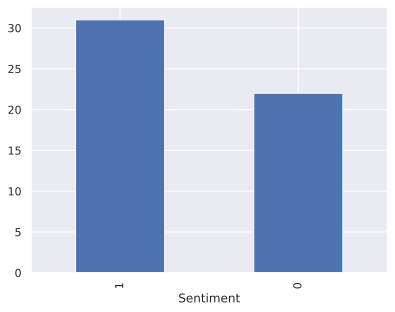

In [252]:
newdata_sml.Sentiment.value_counts().plot.bar()

It appeared my dataset contained more positive reviews than negative

In [253]:
words = newdata_sml['Breakdown'].values.tolist()

vocab_holder = set()
for s in words:
  vocab_holder.update(s.split(' '))

print(sorted(vocab_holder))

['', '(when', '-', '1', '100%.', 'A', "A's", 'A-', 'Canvas', 'Class', "Doesn't", 'Exams', 'Extremely', 'Great', 'Highly', 'However,', 'I', 'If', 'It', "It's", 'Lab', 'Love', 'MCAT', 'MCAT.', 'Material', 'Not', 'Online', 'Otherwise', 'Overall', 'Premed', 'Professor', 'Really.', 'STEM', 'Simple', 'Take', 'The', 'Their', 'They', 'This', 'Totally', 'You', 'a', 'about', 'absolute', 'abundantly', 'accommodate', 'accommodating', 'accordingly,', 'actually', 'again', 'all', 'all,', 'also', 'always', 'amazing', 'an', 'and', 'another', 'answer', 'anymore', 'anything', 'anything,', 'apply', 'are', "aren't", 'around', 'arrogant', 'as', 'asked', 'aspect.', 'assessment', 'assignment', 'assignments', 'assignments.', 'at', 'attendance', 'back', 'based', 'be', 'because', 'best', 'biochem', 'break', 'but', 'by', 'can', 'cares', 'case', 'checked', 'chunks', 'class', 'class,', 'class.', 'classes,', 'classwork', 'classwork.', 'clear', 'comes', 'complete', 'complete.', 'confusing', 'could', 'creative', 'cred

In [254]:
# getting information out of df and into usable format

total = []
positive = []
negative = []

for entry in range(len(newdata_sml)):
  if newdata_sml['Sentiment'][entry] == 0:
    negative.append(newdata_sml['Breakdown'][entry])
    neg_tuple = (newdata_sml['Breakdown'][entry], 0)
    total.append(neg_tuple)
  elif newdata_sml['Sentiment'][entry] == 1:
    positive.append(newdata_sml['Breakdown'][entry])
    pos_tuple = (newdata_sml['Breakdown'][entry], 1)
    total.append(pos_tuple)
  else:
    sentence = newdata_sml['Breakdown'][entry].split('but')
    if len(sentence) == 1:
      print('check this manually, except for testing the one case hehe')
      sent = []
      try:
        sent = sentence[0].split('although')
        print(sent)
        positive.append(sent[0])
        total.append((sent[0], 1))
        negative.append(sent[1])
        total.append((sent[1], 0))
      except:
        sent = sentence[0].split('and')
        print(sent)
        positive.append(sent[0])
        total.append((sent[0], 1))
        negative.append(sent[1])
        total.append((sent[1], 0))

    else:
      positive.append(sentence[1])
      negative.append(sentence[0])
      total.append((sentence[0], 0))
      total.append((sentence[1], 1))

print('number of positive cases: ', len(positive))
print('number of negative cases: ', len(negative))
print(total)

number of positive cases:  31
number of negative cases:  22
[('Take the other biochem professor!!', 0), ("The professor doesn't teach you anything, you just draw pictures in class. ", 0), ("The tests aren't take-home anymore and were so unreasonable.", 0), ("You have to teach yourself everything, but still its hard to prepare for the tests because the professor doesn't give enough resources. ", 0), ("Doesn't prepare you well for the future if you are premed.", 0), ("It won't be hard to get at least an A- in this class. ", 1), ('However, the professor is extremely lazy, and instead of teaching, they make their students draw pictures. ', 0), ('Exams are take-home but take a full day to complete.', 0), ("Overall it's a pretty relaxed class", 1), (' They can be very rude. ', 0), ("Premed students should know they won't learn anything for the MCAT.", 0), ("Extremely easy to get an A as you get credit for attendance and there's a lot of little assignments.", 1), ("lectures aren't great and y

In [255]:
#made my own makeshift list of stop words
maddiestop = ['a', "to", 'an', 'that', 'the', 'you', 'me', 'and', 'it', 'be', 'i']


sentences_from_breakdown = newdata_sml['Breakdown'].values.tolist()
print(sentences_from_breakdown)

temp_vocab = []

stripped_sentences = []

for x in sentences_from_breakdown:

  x = str(x).lower()
  if "an a " in x:
    x = x.replace("an a", "an a+")

  testing_tokens = x.split()
  #testing_tokens2 = [tok.strip('.!,') for tok in testing_tokens if tok not in maddiestop]
  testing_tokens2 = [tok.strip('.!,-\()') for tok in testing_tokens]

  for q in testing_tokens2:
    q = q.strip()

    if '/' in q:
      #print(testing_tokens2)
      one, two = q.split('/')
      temp_vocab.append(one)
      temp_vocab.append(two)
    else:
      if q != '':
        temp_vocab.append(q)

  sent = ' '.join(testing_tokens2)
  if '/' not in sent:
    stripped_sentences.append(sent)
  else:
    newsent = sent.replace('/', ' ')
    print(newsent)
    stripped_sentences.append(newsent)

  #print(testing_tokens)
  #print(testing_tokens2)

print('total number of words in docs is: ', len(temp_vocab))

set_of_temp_vocab = sorted(set(temp_vocab))

print('total unique words is ', len(set_of_temp_vocab))
print(set_of_temp_vocab)
print(stripped_sentences)

['Take the other biochem professor!!', "The professor doesn't teach you anything, you just draw pictures in class. ", "The tests aren't take-home anymore and were so unreasonable.", "You have to teach yourself everything, but still its hard to prepare for the tests because the professor doesn't give enough resources. ", "Doesn't prepare you well for the future if you are premed.", "It won't be hard to get at least an A- in this class. ", 'However, the professor is extremely lazy, and instead of teaching, they make their students draw pictures. ', 'Exams are take-home but take a full day to complete.', "Overall it's a pretty relaxed class", ' They can be very rude. ', "Premed students should know they won't learn anything for the MCAT.", "Extremely easy to get an A as you get credit for attendance and there's a lot of little assignments.", "lectures aren't great and you really don't learn anything from the class, so take another prof if you're taking this for MCAT review. ", "Otherwise 

once I was able to access each part of my sentences, I wanted to proceed with building a model.

My first idea was simple - could I use the skills I had built through HW1 to derive any insights from my data?

In [256]:
# even though I solved this above, I figured I'd try out the og tokenizer I wrote

def tokenize(document, strip_punct=True, ignore_case=True):
    wordlist = document.split()
    if strip_punct and ignore_case:
        new_wordlist = []
        for x in wordlist:
            try:
                x = re.sub(r'^\W+', '', x)
            except:
                pass
            try:
                x = re.sub(r'\W+$', '', x)
            except:
                pass
            x = x.lower()
            x = x.strip(':\"')
            new_wordlist.append(x)
        return new_wordlist
    elif ignore_case:
        new_wordlist = [x.lower() for x in wordlist]
        return new_wordlist
    elif strip_punct:
        new_wordlist = []
        for x in wordlist:
            try:
                x = re.sub(r'^\W+', '', x)
            except:
                pass
            try:
                x = re.sub(r'\W+$', '', x)
            except:
                pass
            new_wordlist.append(x)
        return new_wordlist
    else:
        return wordlist

In [257]:
newdata_sml_copy = newdata_sml.copy()

newdata_sml_copy['tokens'] = [tokenize(d, strip_punct=True, ignore_case=True) for d in newdata_sml_copy.Breakdown]

newdata_sml_copy

,Class,Quality,Difficulty,Breakdown,Sentiment,tokens
0,CELL,1.0,3.0,Take the other biochem professor!!,0,"[take, the, other, biochem, professor]"
1,CELL,1.0,2.0,"The professor doesn't teach you anything, you ...",0,"[the, professor, doesn't, teach, you, anything..."
2,CELL,2.0,2.0,The tests aren't take-home anymore and were so...,0,"[the, tests, aren't, take-home, anymore, and, ..."
3,CELL,5.0,2.0,"You have to teach yourself everything, but sti...",0,"[you, have, to, teach, yourself, everything, b..."
4,CELL,3.0,2.0,Doesn't prepare you well for the future if you...,0,"[doesn't, prepare, you, well, for, the, future..."
5,CELL,5.0,2.0,It won't be hard to get at least an A- in this...,1,"[it, won't, be, hard, to, get, at, least, an, ..."
6,CELL,4.0,2.0,"However, the professor is extremely lazy, and ...",0,"[however, the, professor, is, extremely, lazy,..."
7,CELL,5.0,3.0,Exams are take-home but take a full day to com...,0,"[exams, are, take-home, but, take, a, full, da..."
8,CELL,5.0,4.0,Overall it's a pretty relaxed class,1,"[overall, it's, a, pretty, relaxed, class]"
9,CELL,5.0,4.0,They can be very rude.,0,"[they, can, be, very, rude]"


In [258]:
# my featurize function from hw1

def featurize(tokens):
    token_dict = {}
    for t in tokens:
        #if t not in token_dict:
         #   token_dict[t] = 1
        token_dict[t] = 1
    return token_dict

newdata_sml_copy['raw_features'] = [featurize(t) for t in newdata_sml_copy.tokens]
newdata_sml_copy

,Class,Quality,Difficulty,Breakdown,Sentiment,tokens,raw_features
0,CELL,1.0,3.0,Take the other biochem professor!!,0,"[take, the, other, biochem, professor]","{'take': 1, 'the': 1, 'other': 1, 'biochem': 1..."
1,CELL,1.0,2.0,"The professor doesn't teach you anything, you ...",0,"[the, professor, doesn't, teach, you, anything...","{'the': 1, 'professor': 1, 'doesn't': 1, 'teac..."
2,CELL,2.0,2.0,The tests aren't take-home anymore and were so...,0,"[the, tests, aren't, take-home, anymore, and, ...","{'the': 1, 'tests': 1, 'aren't': 1, 'take-home..."
3,CELL,5.0,2.0,"You have to teach yourself everything, but sti...",0,"[you, have, to, teach, yourself, everything, b...","{'you': 1, 'have': 1, 'to': 1, 'teach': 1, 'yo..."
4,CELL,3.0,2.0,Doesn't prepare you well for the future if you...,0,"[doesn't, prepare, you, well, for, the, future...","{'doesn't': 1, 'prepare': 1, 'you': 1, 'well':..."
5,CELL,5.0,2.0,It won't be hard to get at least an A- in this...,1,"[it, won't, be, hard, to, get, at, least, an, ...","{'it': 1, 'won't': 1, 'be': 1, 'hard': 1, 'to'..."
6,CELL,4.0,2.0,"However, the professor is extremely lazy, and ...",0,"[however, the, professor, is, extremely, lazy,...","{'however': 1, 'the': 1, 'professor': 1, 'is':..."
7,CELL,5.0,3.0,Exams are take-home but take a full day to com...,0,"[exams, are, take-home, but, take, a, full, da...","{'exams': 1, 'are': 1, 'take-home': 1, 'but': ..."
8,CELL,5.0,4.0,Overall it's a pretty relaxed class,1,"[overall, it's, a, pretty, relaxed, class]","{'overall': 1, 'it's': 1, 'a': 1, 'pretty': 1,..."
9,CELL,5.0,4.0,They can be very rude.,0,"[they, can, be, very, rude]","{'they': 1, 'can': 1, 'be': 1, 'very': 1, 'rud..."


In [259]:
# my word document frequency function

def count_word_document_frequency(dict_list):
    count = Counter()
    for w in dict_list:
      count.update(w)

    return count

word_counts_sml = count_word_document_frequency(newdata_sml_copy.raw_features)
print(word_counts_sml)
print(len(word_counts_sml))

Counter({'the': 27, 'professor': 21, 'and': 19, 'for': 17, 'class': 16, 'to': 16, 'is': 16, 'a': 14, 'you': 13, 'in': 9, 'of': 9, 'students': 9, 'tests': 8, 'they': 8, 'their': 8, 'that': 8, 'this': 7, 'really': 7, 'take': 6, 'so': 6, 'but': 6, 'if': 6, 'are': 6, 'lab': 6, 'not': 6, 'hard': 5, 'get': 5, 'great': 5, "don't": 5, 'makes': 5, 'have': 4, 'it': 4, 'very': 4, 'mcat': 4, 'as': 4, 'little': 4, 'all': 4, 'material': 4, "doesn't": 3, 'anything': 3, "aren't": 3, 'prepare': 3, 'well': 3, 'at': 3, 'an': 3, 'make': 3, 'easy': 3, 'credit': 3, 'assignments': 3, 'them': 3, 'which': 3, 'on': 3, 'i': 3, 'with': 3, 'would': 3, 'gives': 3, 'up': 3, 'other': 2, 'biochem': 2, 'teach': 2, 'just': 2, 'draw': 2, 'pictures': 2, 'take-home': 2, 'were': 2, 'premed': 2, "won't": 2, 'be': 2, 'extremely': 2, 'instead': 2, 'complete': 2, "it's": 2, 'can': 2, 'know': 2, 'learn': 2, 'lectures': 2, 'stem': 2, "they're": 2, 'cares': 2, 'about': 2, 'wants': 2, 'super': 2, 'recommend': 2, 'based': 2, 'most':

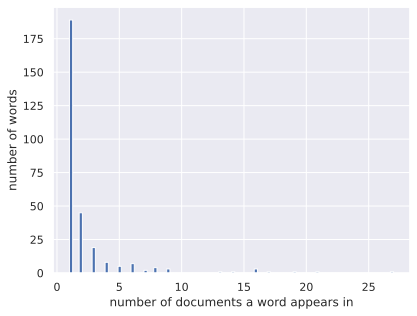

[(1, 189), (2, 45), (3, 19), (4, 8), (6, 7)]

In [260]:
plt.figure()
plt.hist(word_counts_sml.values(), bins=100)
plt.xlabel('number of documents a word appears in')
plt.ylabel('number of words')
plt.show()
Counter(word_counts_sml.values()).most_common(5)

# evidently, there are a lot of words that only appear once
# working with a small data set at the moment, so this makes sense

In this assignment, I built a function for defining a vocabulary [vs above I wrote a class]. I am going to try to use the function now, but may revert to my og class

In [261]:
def create_vocabulary_hw1(word_counts, min_count=2, max_count=100):
    vocab = {}
    for x in word_counts:
        if word_counts[x] >= 2 and word_counts[x] <= 100:
            vocab[x] = word_counts[x]

    vocab_sort_items = sorted(vocab.items())
    final_vocab = {}
    counter = 0
    for v in vocab_sort_items:
        value = v[0]
        final_vocab[value] = counter
        counter += 1

    return final_vocab


vocabulary_sml = create_vocabulary_hw1(word_counts_sml, min_count=2, max_count=100)
list(vocabulary_sml.items())[:10]

[('a', 0),
 ('about', 1),
 ('accommodating', 2),
 ('all', 3),
 ('also', 4),
 ('an', 5),
 ('and', 6),
 ('anything', 7),
 ('are', 8),
 ("aren't", 9)]

In [262]:
def prune_features(vocabulary, raw_feature_dict):
    return {k:v for k,v in raw_feature_dict.items() if k in vocabulary}

newdata_sml_copy['features'] = [prune_features(vocabulary_sml, f) for f in newdata_sml_copy.raw_features]
newdata_sml_copy

,Class,Quality,Difficulty,Breakdown,Sentiment,tokens,raw_features,features
0,CELL,1.0,3.0,Take the other biochem professor!!,0,"[take, the, other, biochem, professor]","{'take': 1, 'the': 1, 'other': 1, 'biochem': 1...","{'take': 1, 'the': 1, 'other': 1, 'biochem': 1..."
1,CELL,1.0,2.0,"The professor doesn't teach you anything, you ...",0,"[the, professor, doesn't, teach, you, anything...","{'the': 1, 'professor': 1, 'doesn't': 1, 'teac...","{'the': 1, 'professor': 1, 'doesn't': 1, 'teac..."
2,CELL,2.0,2.0,The tests aren't take-home anymore and were so...,0,"[the, tests, aren't, take-home, anymore, and, ...","{'the': 1, 'tests': 1, 'aren't': 1, 'take-home...","{'the': 1, 'tests': 1, 'aren't': 1, 'take-home..."
3,CELL,5.0,2.0,"You have to teach yourself everything, but sti...",0,"[you, have, to, teach, yourself, everything, b...","{'you': 1, 'have': 1, 'to': 1, 'teach': 1, 'yo...","{'you': 1, 'have': 1, 'to': 1, 'teach': 1, 'bu..."
4,CELL,3.0,2.0,Doesn't prepare you well for the future if you...,0,"[doesn't, prepare, you, well, for, the, future...","{'doesn't': 1, 'prepare': 1, 'you': 1, 'well':...","{'doesn't': 1, 'prepare': 1, 'you': 1, 'well':..."
5,CELL,5.0,2.0,It won't be hard to get at least an A- in this...,1,"[it, won't, be, hard, to, get, at, least, an, ...","{'it': 1, 'won't': 1, 'be': 1, 'hard': 1, 'to'...","{'it': 1, 'won't': 1, 'be': 1, 'hard': 1, 'to'..."
6,CELL,4.0,2.0,"However, the professor is extremely lazy, and ...",0,"[however, the, professor, is, extremely, lazy,...","{'however': 1, 'the': 1, 'professor': 1, 'is':...","{'the': 1, 'professor': 1, 'is': 1, 'extremely..."
7,CELL,5.0,3.0,Exams are take-home but take a full day to com...,0,"[exams, are, take-home, but, take, a, full, da...","{'exams': 1, 'are': 1, 'take-home': 1, 'but': ...","{'are': 1, 'take-home': 1, 'but': 1, 'take': 1..."
8,CELL,5.0,4.0,Overall it's a pretty relaxed class,1,"[overall, it's, a, pretty, relaxed, class]","{'overall': 1, 'it's': 1, 'a': 1, 'pretty': 1,...","{'it's': 1, 'a': 1, 'class': 1}"
9,CELL,5.0,4.0,They can be very rude.,0,"[they, can, be, very, rude]","{'they': 1, 'can': 1, 'be': 1, 'very': 1, 'rud...","{'they': 1, 'can': 1, 'be': 1, 'very': 1}"


In [263]:
# my probability funct from hw1

def p_x_given_y(train_df, vocabulary, label, epsilon=0):

    pos_df = train_df[(train_df.Sentiment==1)]
    neg_df = train_df[(train_df.Sentiment==0)]

    docs_withword_pos = count_word_document_frequency(pos_df.features)

    docs_withword_neg = count_word_document_frequency(neg_df.features)

    print(docs_withword_neg)

    docs_withword_all = count_word_document_frequency(train_df.features)

    pword_given_pos = {}
    pword_given_neg = {}
    for i in docs_withword_all:
        data_given_class_p = (docs_withword_pos[i]) + epsilon
        data_given_class_n = (docs_withword_neg[i]) + epsilon
        #print('probability that word', i, 'is in a document given that the label is pos: ',data_given_class)
        denom =  200 + 2*epsilon
        #print('probability that word', i, 'is in a document given all labels: ',denom)
        prob_p = data_given_class_p / denom
        prob_n = data_given_class_n / denom

        pword_given_pos[i] = prob_p

        pword_given_neg[i] = prob_n

    print(pword_given_pos)
    print(pword_given_neg)
    if label == 1:
        return pword_given_pos
    else:
        return pword_given_neg



p_x_given_pos = p_x_given_y(newdata_sml_copy, vocabulary_sml, 1, epsilon=1)
p_x_given_neg = p_x_given_y(newdata_sml_copy, vocabulary_sml, 0, epsilon=1)

Counter({'the': 13, 'for': 11, 'class': 9, 'is': 8, 'professor': 7, 'a': 7, 'you': 6, 'and': 6, 'tests': 5, 'they': 5, 'to': 4, 'are': 4, 'their': 4, 'mcat': 4, 'take': 3, "doesn't": 3, 'anything': 3, 'in': 3, 'so': 3, 'but': 3, 'hard': 3, 'if': 3, 'of': 3, 'really': 3, "don't": 3, 'this': 3, 'not': 3, 'teach': 2, 'just': 2, 'draw': 2, 'pictures': 2, "aren't": 2, 'take-home': 2, 'prepare': 2, 'premed': 2, 'instead': 2, 'make': 2, 'students': 2, 'very': 2, 'learn': 2, 'lectures': 2, 'great': 2, 'material': 2, 'that': 2, 'online': 2, 'lab': 2, 'i': 2, 'would': 2, 'gives': 2, 'unorganized': 2, 'little': 2, 'guidance': 2, 'other': 1, 'biochem': 1, 'were': 1, 'have': 1, 'well': 1, 'extremely': 1, 'complete': 1, 'can': 1, 'be': 1, 'know': 1, "won't": 1, 'based': 1, 'which': 1, 'stem': 1, 'also': 1, 'each': 1, 'recommend': 1, 'at': 1, 'all': 1, 'as': 1, 'makes': 1, 'fair': 1, "it's": 1, 'has': 1, 'on': 1})
{'take': 0.019801980198019802, 'the': 0.07425742574257425, 'other': 0.00990099009900990

In [264]:
print('top p(x|pos)')
print(sorted(p_x_given_pos.items(), key=lambda x: -x[1])[:5])

print('top p(x|neg)')
print(sorted(p_x_given_neg.items(), key=lambda x: -x[1])[:5])

top p(x|pos)
[('the', 0.07425742574257425), ('professor', 0.07425742574257425), ('and', 0.06930693069306931), ('to', 0.06435643564356436), ('is', 0.04455445544554455)]
top p(x|neg)
[('the', 0.06930693069306931), ('for', 0.0594059405940594), ('class', 0.04950495049504951), ('is', 0.04455445544554455), ('professor', 0.039603960396039604)]


In [265]:
word_scores = pd.DataFrame([{'word':w, 'pos_score': p_x_given_pos[w] - p_x_given_neg[w]} for w in vocabulary_sml])
print('positive terms')
display(word_scores.sort_values('pos_score', ascending=False).head(10))

print('negative terms')
display(word_scores.sort_values('pos_score', ascending=True).head(10))

positive terms


,word,pos_score
88,to,0.039604
6,and,0.034653
69,professor,0.034653
75,students,0.024752
33,get,0.024752
81,that,0.019802
46,it,0.019802
43,in,0.014851
62,of,0.014851
57,makes,0.014851


negative terms


,word,pos_score
32,for,-0.024752
59,mcat,-0.019802
25,doesn't,-0.014851
7,anything,-0.014851
8,are,-0.009901
19,class,-0.009901
44,instead,-0.009901
66,pictures,-0.009901
37,guidance,-0.009901
27,draw,-0.009901


Frankly, these predictions were awful, but I realized I hadn't removed any stop tokens. I decided to redo this and see if removing the common words would help [bc the threshold of 100 was too high for my small dataset]

In [266]:
def refining_vocabulary(original_vocab, word_counts):
    stop = nltk.corpus.stopwords.words('english')
    newvocab = []
    for t in original_vocab:
      if t not in stop and word_counts[t] > 1:
        newvocab.append(t)

    return newvocab


new_vocab_sml = refining_vocabulary(vocabulary_sml, word_counts_sml)
print(word_counts_sml)
print(new_vocab_sml)

Counter({'the': 27, 'professor': 21, 'and': 19, 'for': 17, 'class': 16, 'to': 16, 'is': 16, 'a': 14, 'you': 13, 'in': 9, 'of': 9, 'students': 9, 'tests': 8, 'they': 8, 'their': 8, 'that': 8, 'this': 7, 'really': 7, 'take': 6, 'so': 6, 'but': 6, 'if': 6, 'are': 6, 'lab': 6, 'not': 6, 'hard': 5, 'get': 5, 'great': 5, "don't": 5, 'makes': 5, 'have': 4, 'it': 4, 'very': 4, 'mcat': 4, 'as': 4, 'little': 4, 'all': 4, 'material': 4, "doesn't": 3, 'anything': 3, "aren't": 3, 'prepare': 3, 'well': 3, 'at': 3, 'an': 3, 'make': 3, 'easy': 3, 'credit': 3, 'assignments': 3, 'them': 3, 'which': 3, 'on': 3, 'i': 3, 'with': 3, 'would': 3, 'gives': 3, 'up': 3, 'other': 2, 'biochem': 2, 'teach': 2, 'just': 2, 'draw': 2, 'pictures': 2, 'take-home': 2, 'were': 2, 'premed': 2, "won't": 2, 'be': 2, 'extremely': 2, 'instead': 2, 'complete': 2, "it's": 2, 'can': 2, 'know': 2, 'learn': 2, 'lectures': 2, 'stem': 2, "they're": 2, 'cares': 2, 'about': 2, 'wants': 2, 'super': 2, 'recommend': 2, 'based': 2, 'most':

In [267]:
newdata_sml_copy['features clean'] = [prune_features(new_vocab_sml, f) for f in newdata_sml_copy.raw_features]
newdata_sml_copy

p_x_given_pos_clean = p_x_given_y(newdata_sml_copy, new_vocab_sml, 1, epsilon=1)
p_x_given_neg_clean = p_x_given_y(newdata_sml_copy, new_vocab_sml, 0, epsilon=1)

word_scores_clean = pd.DataFrame([{'word':w, 'pos_score': p_x_given_pos_clean[w] - p_x_given_neg_clean[w]} for w in new_vocab_sml])
print('positive terms')
display(word_scores_clean.sort_values('pos_score', ascending=False).head(10))

print('negative terms')
display(word_scores_clean.sort_values('pos_score', ascending=True).head(10))

Counter({'the': 13, 'for': 11, 'class': 9, 'is': 8, 'professor': 7, 'a': 7, 'you': 6, 'and': 6, 'tests': 5, 'they': 5, 'to': 4, 'are': 4, 'their': 4, 'mcat': 4, 'take': 3, "doesn't": 3, 'anything': 3, 'in': 3, 'so': 3, 'but': 3, 'hard': 3, 'if': 3, 'of': 3, 'really': 3, "don't": 3, 'this': 3, 'not': 3, 'teach': 2, 'just': 2, 'draw': 2, 'pictures': 2, "aren't": 2, 'take-home': 2, 'prepare': 2, 'premed': 2, 'instead': 2, 'make': 2, 'students': 2, 'very': 2, 'learn': 2, 'lectures': 2, 'great': 2, 'material': 2, 'that': 2, 'online': 2, 'lab': 2, 'i': 2, 'would': 2, 'gives': 2, 'unorganized': 2, 'little': 2, 'guidance': 2, 'other': 1, 'biochem': 1, 'were': 1, 'have': 1, 'well': 1, 'extremely': 1, 'complete': 1, 'can': 1, 'be': 1, 'know': 1, "won't": 1, 'based': 1, 'which': 1, 'stem': 1, 'also': 1, 'each': 1, 'recommend': 1, 'at': 1, 'all': 1, 'as': 1, 'makes': 1, 'fair': 1, "it's": 1, 'has': 1, 'on': 1})
{'take': 0.019801980198019802, 'the': 0.07425742574257425, 'other': 0.00990099009900990

,word,pos_score
38,professor,0.034653
43,students,0.024752
16,get,0.024752
31,makes,0.014851
3,assignments,0.014851
11,credit,0.014851
13,easy,0.014851
24,lab,0.009901
52,us,0.009901
50,understands,0.009901


negative terms


,word,pos_score
33,mcat,-0.019802
2,anything,-0.014851
7,class,-0.009901
36,premed,-0.009901
20,guidance,-0.009901
26,lectures,-0.009901
34,online,-0.009901
35,pictures,-0.009901
12,draw,-0.009901
22,instead,-0.009901


this looks slightly better - now to build a model!

I decided to manually split the samples into training and testing sets, which I load below

In [268]:
train_sml = pd.read_excel('/content/drive/MyDrive/nlp/train-data-cleaned.xlsx')
test_sml = pd.read_excel('/content/drive/MyDrive/nlp/test-data-cleaned.xlsx')



now: Naive Bayes and Logistic Regression

In [269]:
# my prior compute funct

def compute_prior(df):
    """
    Compute the prior probability p(y=1) given a training set DataFrame.
    """
    # YOUR CODE HERE
    return len(df[df.Sentiment == 1]) / len(df)


prior = compute_prior(train_sml)
prior

0.5909090909090909

In [270]:
# my math functions lol

def log_p_y_given_x_numerator(features, p_x_given_y, prior, vocabulary):
    """
    returns log(p(y)) + \sum_j \log p(x_j|y). This is the numerator in the equation
    for p(y|x) above.

    note that p_x_given_y and prior can be values for y=1 or y=0, depending on what
    is passed in. see usage in pr_pos_given_x below.
    """

    num = math.log(prior) + sum([math.log(p_x_given_y[feat]) if feat in features else math.log(1 - p_x_given_y[feat]) for feat in vocabulary])
    #print(num)
    return num


def pr_pos_given_x(features, p_x_given_pos, p_x_given_neg, prior, vocabulary):
    """
    Returns the probability p(y=1|x). This is complete and should not need to be modified.
    """
    pos_numerator = log_p_y_given_x_numerator(features, p_x_given_pos, prior, vocabulary)
    neg_numerator = log_p_y_given_x_numerator(features, p_x_given_neg, 1-prior, vocabulary)

    maxv = max((pos_numerator, neg_numerator))
    log_p_x = maxv + math.log(math.exp(pos_numerator-maxv) + math.exp(neg_numerator-maxv))
    v = pos_numerator - log_p_x
    return math.exp(v)

In [271]:
# now actually running on the training and testing


train_sml['tokens'] = [tokenize(d, strip_punct=True, ignore_case=True) for d in train_sml.Breakdown]
train_sml['raw_features'] = [featurize(t) for t in train_sml.tokens]
train_sml['features'] = [prune_features(vocabulary_sml, f) for f in train_sml.raw_features]
#print(train_sml.head(2))

test_sml['tokens'] = [tokenize(d, strip_punct=True, ignore_case=True) for d in test_sml.Breakdown]
test_sml['raw_features'] = [featurize(t) for t in test_sml.tokens]
test_sml['features'] = [prune_features(vocabulary_sml, f) for f in test_sml.raw_features]
test_sml.head(2)

,Class,Quality,Difficulty,Breakdown,Sentiment,tokens,raw_features,features
0,NaN,NaN,NaN,makes up for it in their willingness to accom...,1,"[makes, up, for, it, in, their, willingness, t...","{'makes': 1, 'up': 1, 'for': 1, 'it': 1, 'in':...","{'makes': 1, 'up': 1, 'for': 1, 'it': 1, 'in':..."
1,NaN,NaN,NaN,"If you keep up with readings, the tests are mo...",1,"[if, you, keep, up, with, readings, the, tests...","{'if': 1, 'you': 1, 'keep': 1, 'up': 1, 'with'...","{'if': 1, 'you': 1, 'up': 1, 'with': 1, 'the':..."


In [272]:
train_sml['pr_pos'] = [pr_pos_given_x(f, p_x_given_pos, p_x_given_neg, prior, vocabulary_sml)
                      for f in train_sml.features]
test_sml['pr_pos'] = [pr_pos_given_x(f, p_x_given_pos, p_x_given_neg, prior, vocabulary_sml)
                     for f in test_sml.features]
test_sml.head(2)

,Class,Quality,Difficulty,Breakdown,Sentiment,tokens,raw_features,features,pr_pos
0,NaN,NaN,NaN,makes up for it in their willingness to accom...,1,"[makes, up, for, it, in, their, willingness, t...","{'makes': 1, 'up': 1, 'for': 1, 'it': 1, 'in':...","{'makes': 1, 'up': 1, 'for': 1, 'it': 1, 'in':...",0.997570
1,NaN,NaN,NaN,"If you keep up with readings, the tests are mo...",1,"[if, you, keep, up, with, readings, the, tests...","{'if': 1, 'you': 1, 'keep': 1, 'up': 1, 'with'...","{'if': 1, 'you': 1, 'up': 1, 'with': 1, 'the':...",0.961943


In [273]:
train_sml['predicted_label'] = [1.0 if v >= .5 else 0.0 for v in train_sml.pr_pos]
test_sml['predicted_label'] = [1.0 if v >= .5 else 0.0 for v in test_sml.pr_pos]
test_sml.head(2)

,Class,Quality,Difficulty,Breakdown,Sentiment,tokens,raw_features,features,pr_pos,predicted_label
0,NaN,NaN,NaN,makes up for it in their willingness to accom...,1,"[makes, up, for, it, in, their, willingness, t...","{'makes': 1, 'up': 1, 'for': 1, 'it': 1, 'in':...","{'makes': 1, 'up': 1, 'for': 1, 'it': 1, 'in':...",0.997570,1.0
1,NaN,NaN,NaN,"If you keep up with readings, the tests are mo...",1,"[if, you, keep, up, with, readings, the, tests...","{'if': 1, 'you': 1, 'keep': 1, 'up': 1, 'with'...","{'if': 1, 'you': 1, 'up': 1, 'with': 1, 'the':...",0.961943,1.0


In [274]:
print('results on training data')
print(classification_report(train_sml.Sentiment, train_sml.predicted_label))
print('results on testing data')
print(classification_report(test_sml.Sentiment, test_sml.predicted_label))

results on training data
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        18
           1       0.89      0.96      0.93        26

    accuracy                           0.91        44
   macro avg       0.92      0.90      0.90        44
weighted avg       0.91      0.91      0.91        44

results on testing data
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.71      1.00      0.83         5

    accuracy                           0.80        10
   macro avg       0.86      0.80      0.79        10
weighted avg       0.86      0.80      0.79        10



now what about for the cleaned vocabulary?

In [275]:

train_sml['clean features'] = [prune_features(new_vocab_sml, f) for f in train_sml.raw_features]

test_sml['clean features'] = [prune_features(new_vocab_sml, f) for f in test_sml.raw_features]

test_sml

,Class,Quality,Difficulty,Breakdown,Sentiment,tokens,raw_features,features,pr_pos,predicted_label,clean features
0,NaN,NaN,NaN,makes up for it in their willingness to accom...,1,"[makes, up, for, it, in, their, willingness, t...","{'makes': 1, 'up': 1, 'for': 1, 'it': 1, 'in':...","{'makes': 1, 'up': 1, 'for': 1, 'it': 1, 'in':...",0.997570,1.0,"{'makes': 1, 'students': 1}"
1,NaN,NaN,NaN,"If you keep up with readings, the tests are mo...",1,"[if, you, keep, up, with, readings, the, tests...","{'if': 1, 'you': 1, 'keep': 1, 'up': 1, 'with'...","{'if': 1, 'you': 1, 'up': 1, 'with': 1, 'the':...",0.961943,1.0,"{'tests': 1, 'straightforward': 1}"
2,NaN,NaN,NaN,The professor understands that we all have lot...,1,"[the, professor, understands, that, we, all, h...","{'the': 1, 'professor': 1, 'understands': 1, '...","{'the': 1, 'professor': 1, 'understands': 1, '...",0.999999,1.0,"{'professor': 1, 'understands': 1, 'lots': 1, ..."
3,NaN,NaN,NaN,Their lecture is really dry,0,"[their, lecture, is, really, dry]","{'their': 1, 'lecture': 1, 'is': 1, 'really': ...","{'their': 1, 'is': 1, 'really': 1}",0.567177,1.0,{'really': 1}
4,NaN,NaN,NaN,the professor makes it abundantly clear what t...,1,"[the, professor, makes, it, abundantly, clear,...","{'the': 1, 'professor': 1, 'makes': 1, 'it': 1...","{'the': 1, 'professor': 1, 'makes': 1, 'it': 1...",0.999098,1.0,"{'professor': 1, 'makes': 1, 'clear': 1, 'know..."
5,NaN,NaN,NaN,"It's a hard class,",0,"[it's, a, hard, class]","{'it's': 1, 'a': 1, 'hard': 1, 'class': 1}","{'it's': 1, 'a': 1, 'hard': 1, 'class': 1}",0.381286,0.0,"{'hard': 1, 'class': 1}"
6,NaN,NaN,NaN,the work you put in is proportionate to the gr...,1,"[the, work, you, put, in, is, proportionate, t...","{'the': 1, 'work': 1, 'you': 1, 'put': 1, 'in'...","{'the': 1, 'you': 1, 'in': 1, 'is': 1, 'to': 1...",0.990027,1.0,"{'get': 1, 'class': 1}"
7,NaN,NaN,NaN,Most students have to take this class as a pre...,0,"[most, students, have, to, take, this, class, ...","{'most': 1, 'students': 1, 'have': 1, 'to': 1,...","{'most': 1, 'students': 1, 'have': 1, 'to': 1,...",0.981838,1.0,"{'students': 1, 'take': 1, 'class': 1}"
8,NaN,NaN,NaN,"If this is the case for you, I would this clas...",0,"[if, this, is, the, case, for, you, i, would, ...","{'if': 1, 'this': 1, 'is': 1, 'the': 1, 'case'...","{'if': 1, 'this': 1, 'is': 1, 'the': 1, 'for':...",0.243038,0.0,"{'would': 1, 'class': 1}"
9,NaN,NaN,NaN,"The professor is very unorganized, has unclear...",0,"[the, professor, is, very, unorganized, has, u...","{'the': 1, 'professor': 1, 'is': 1, 'very': 1,...","{'the': 1, 'professor': 1, 'is': 1, 'very': 1,...",0.033421,0.0,"{'professor': 1, 'unorganized': 1, 'gives': 1,..."


In [276]:
train_sml['pr_pos clean'] = [pr_pos_given_x(f, p_x_given_pos_clean, p_x_given_neg_clean, prior, new_vocab_sml)
                      for f in train_sml['clean features']]
test_sml['pr_pos clean'] = [pr_pos_given_x(f, p_x_given_pos_clean, p_x_given_neg_clean, prior, new_vocab_sml)
                     for f in test_sml['clean features']]

train_sml['predicted_label_clean'] = [1.0 if v >= .5 else 0.0 for v in train_sml['pr_pos clean']]
test_sml['predicted_label_clean'] = [1.0 if v >= .5 else 0.0 for v in test_sml['pr_pos clean']]


print('results on training data')
print(classification_report(train_sml.Sentiment, train_sml.predicted_label_clean))
print('results on testing data')
print(classification_report(test_sml.Sentiment, test_sml.predicted_label_clean))

results on training data
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        18
           1       0.89      0.96      0.93        26

    accuracy                           0.91        44
   macro avg       0.92      0.90      0.90        44
weighted avg       0.91      0.91      0.91        44

results on testing data
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.71      1.00      0.83         5

    accuracy                           0.80        10
   macro avg       0.86      0.80      0.79        10
weighted avg       0.86      0.80      0.79        10



It gave the exact same predictions, but output slightly different decimals representing confidence. for the next step, I'm just going to work with the original vocab

In [277]:
#from hw1, which grabbed code from the lecture slides

def gradient_descent(gradient_fn, error_fn, theta,
                     learning_rate, D, tolerance, max_iters):
    errori = error_fn(theta, D)
    iters = 0
    trace = [] # for debugging
    while True:
        iters += 1
        theta_cp = copy.copy(theta)
        print('\n\niteration %d' % iters)
        grad = gradient_fn(theta, D)
        trace.append((theta.copy(), grad, errori))
        print('gradient=', grad)
        theta -= learning_rate * grad  # UPDATE!
        newerror = error_fn(theta, D)
        print('old error=%g   new error=%g  theta=%s\n\n' %
              (errori, newerror, str(theta)))
        error_diff = errori - newerror
        # stopping criteria
        if error_diff < 0:
            learning_rate *= .5
            print('error got worse. reducing learning rate to %g' % learning_rate)
            theta = theta_cp
            errori = error_fn(theta, D)
        elif errori - newerror < tolerance:
            print('error change is too small')
            break
        elif iters >= max_iters:
            print('max iterations reached')
            break
        else:
            errori = newerror
    trace = pd.DataFrame(trace, columns=['theta', 'gradient', 'error'])
    display(trace)
    plt.plot(trace.error, 'bo-')
    plt.xlabel('iteration')
    plt.ylabel('error')
    return theta

def f(x, theta):
    # dot product
    return x.dot(theta)

def logistic(x, theta):
    # logistic function: p(y=1|x)
    return 1 / (1 + math.exp(-f(x, theta)))

def nll(theta, D):
    # negative log likelihood
    total = 0
    predictions = [] # for debugging
    for xi, yi in D:
        pred = logistic(xi, theta) if yi==1 else 1-logistic(xi, theta)
        total += math.log(pred)
        predictions.append((xi, yi, pred, 1-pred))
    display(pd.DataFrame(predictions, columns=['x', 'y', 'prediction', 'error']))
    return -total

def gradient_logistic(theta, D):
    # gradient function for logistic regression
    # updated from lecture to use csr_matrix as feature vectors,
    # instead of numpy arrays.
    result = np.zeros(len(theta), dtype=np.float64)
    for xi, yi in D:
        p_y_g_x = logistic(xi, theta) if yi==1 else 1-logistic(xi, theta)
        error = yi * (1-p_y_g_x)
        for j, xij in zip(xi.indices, xi.data):
            result[j] += error * xij
    return -result

In [278]:
def features2array(features, vocabulary):

    size = len(vocabulary)
    new = np.zeros(size, dtype=float)

    for word, val in features.items():
        if word in vocabulary:
            #print('found', word)
            new[vocabulary[word]] = 1.0
        #else:
            #new[word] = 0.0
    return new

def features2sparse_array(features, vocabulary):
    return csr_matrix(features2array(features, vocabulary), shape=(1, len(vocabulary)))

dense_array = features2array(train_sml.features[0], vocabulary_sml)
sparse_array = features2sparse_array(train_sml.features[0], vocabulary_sml)
print('document contains %d/%d words' % (sparse_array.nnz, len(vocabulary_sml)))
print('dense array requires %d bytes, sparse array requires %d bytes' %
      (dense_array.nbytes, sparse_array.data.nbytes + sparse_array.indices.nbytes + sparse_array.indptr.nbytes))

document contains 5/102 words
dense array requires 816 bytes, sparse array requires 68 bytes


In [279]:
train_sml['feature_vector'] = [features2sparse_array(f, vocabulary_sml) for f in train_sml.features]
test_sml['feature_vector'] = [features2sparse_array(f, vocabulary_sml) for f in test_sml.features]
train_sml.head(1)

,Class,Quality,Difficulty,Breakdown,Sentiment,tokens,raw_features,features,pr_pos,predicted_label,clean features,pr_pos clean,predicted_label_clean,feature_vector
0,CELL,1.0,3.0,Take the other biochem professor!!,0,"[take, the, other, biochem, professor]","{'take': 1, 'the': 1, 'other': 1, 'biochem': 1...","{'take': 1, 'the': 1, 'other': 1, 'biochem': 1...",0.686072,1.0,"{'take': 1, 'biochem': 1, 'professor': 1}",0.715245,1.0,"(0, 15)\t1.0\n (0, 65)\t1.0\n (0, 69)\t1.0..."


<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 15)\t1.0\n (0, 65)\t1.0\n (0, 69)\t1.0...",-1,0.5,0.5
1,"(0, 7)\t1.0\n (0, 19)\t1.0\n (0, 25)\t1.0\...",-1,0.5,0.5
2,"(0, 6)\t1.0\n (0, 9)\t1.0\n (0, 72)\t1.0\n...",-1,0.5,0.5
3,"(0, 16)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0...",-1,0.5,0.5
4,"(0, 8)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0\...",-1,0.5,0.5
5,"(0, 0)\t1.0\n (0, 5)\t1.0\n (0, 12)\t1.0\n...",1,0.5,0.5
6,"(0, 6)\t1.0\n (0, 27)\t1.0\n (0, 30)\t1.0\...",-1,0.5,0.5
7,"(0, 0)\t1.0\n (0, 8)\t1.0\n (0, 16)\t1.0\n...",-1,0.5,0.5
8,"(0, 0)\t1.0\n (0, 19)\t1.0\n (0, 47)\t1.0",1,0.5,0.5
9,"(0, 14)\t1.0\n (0, 17)\t1.0\n (0, 85)\t1.0...",-1,0.5,0.5




iteration 1
gradient= [-0.  -1.  -1.  -0.  -0.  -1.5 -3.   1.5  1.5  0.5 -1.  -1.5 -0.  -0.
 -0.  -0.  -0.   0.5 -1.   0.5 -1.  -0.5 -0.  -1.  -0.5  1.5 -0.   1.
 -0.  -1.5 -0.  -0.   2.5 -2.  -0.  -0.5 -0.5  0.5 -0.  -0.5 -0.5 -0.
  0.5 -0.5  1.  -0.5 -1.  -0.5  0.5  0.5 -1.   1.   1.  -0.5 -0.5 -1.
  0.5 -0.5 -0.   2.  -1.   1.  -1.  -1.   1.   0.5  1.   1.   1.  -3.
 -1.  -0.   1.  -0.  -0.5 -2.  -1.  -0.   1.   1.   1.  -1.5  0.5 -0.
 -1.5  1.5 -1.  -0.5 -2.  -0.5  0.5 -0.  -0.5 -0.  -1.  -0.  -0.  -0.
 -0.5 -0.  -0.  -0. ]


<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 15)\t1.0\n (0, 65)\t1.0\n (0, 69)\t1.0...",-1,0.354344,0.645656
1,"(0, 7)\t1.0\n (0, 19)\t1.0\n (0, 25)\t1.0\...",-1,0.768525,0.231475
2,"(0, 6)\t1.0\n (0, 9)\t1.0\n (0, 72)\t1.0\n...",-1,0.574443,0.425557
3,"(0, 16)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0...",-1,0.645656,0.354344
4,"(0, 8)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0\...",-1,0.927574,0.072426
5,"(0, 0)\t1.0\n (0, 5)\t1.0\n (0, 12)\t1.0\n...",1,0.890903,0.109097
6,"(0, 6)\t1.0\n (0, 27)\t1.0\n (0, 30)\t1.0\...",-1,0.231475,0.768525
7,"(0, 0)\t1.0\n (0, 8)\t1.0\n (0, 16)\t1.0\n...",-1,0.537430,0.462570
8,"(0, 0)\t1.0\n (0, 19)\t1.0\n (0, 47)\t1.0",1,0.500000,0.500000
9,"(0, 14)\t1.0\n (0, 17)\t1.0\n (0, 85)\t1.0...",-1,0.645656,0.354344


<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


old error=30.4985   new error=17.2986  theta=[ 0.    0.3   0.3   0.    0.    0.45  0.9  -0.45 -0.45 -0.15  0.3   0.45
  0.    0.    0.    0.    0.   -0.15  0.3  -0.15  0.3   0.15  0.    0.3
  0.15 -0.45  0.   -0.3   0.    0.45  0.    0.   -0.75  0.6   0.    0.15
  0.15 -0.15  0.    0.15  0.15  0.   -0.15  0.15 -0.3   0.15  0.3   0.15
 -0.15 -0.15  0.3  -0.3  -0.3   0.15  0.15  0.3  -0.15  0.15  0.   -0.6
  0.3  -0.3   0.3   0.3  -0.3  -0.15 -0.3  -0.3  -0.3   0.9   0.3   0.
 -0.3   0.    0.15  0.6   0.3   0.   -0.3  -0.3  -0.3   0.45 -0.15  0.
  0.45 -0.45  0.3   0.15  0.6   0.15 -0.15  0.    0.15  0.    0.3   0.
  0.    0.    0.15  0.    0.    0.  ]




iteration 2
gradient= [ 1.68173581 -0.03893143 -0.2206444   0.69968362  0.18679862 -0.14684822
  1.93394517  0.44575277  1.13890104  0.36153818  0.45972532 -0.30127423
  0.63167808 -0.13839578  0.24524687  0.25629554  0.71284921  0.35434369
 -0.03893143  1.23844277 -0.23246737 -0.06297336  0.42147888 -0.25445259
 -0.3208213   0.6582454

,x,y,prediction,error
0,"(0, 15)\t1.0\n (0, 65)\t1.0\n (0, 69)\t1.0...",-1,0.769821,0.230179
1,"(0, 7)\t1.0\n (0, 19)\t1.0\n (0, 25)\t1.0\...",-1,0.989531,0.010469
2,"(0, 6)\t1.0\n (0, 9)\t1.0\n (0, 72)\t1.0\n...",-1,0.933757,0.066243
3,"(0, 16)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0...",-1,0.986427,0.013573
4,"(0, 8)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0\...",-1,0.990217,0.009783
5,"(0, 0)\t1.0\n (0, 5)\t1.0\n (0, 12)\t1.0\n...",1,0.509027,0.490973
6,"(0, 6)\t1.0\n (0, 27)\t1.0\n (0, 30)\t1.0\...",-1,0.982225,0.017775
7,"(0, 0)\t1.0\n (0, 8)\t1.0\n (0, 16)\t1.0\n...",-1,0.906315,0.093685
8,"(0, 0)\t1.0\n (0, 19)\t1.0\n (0, 47)\t1.0",1,0.326061,0.673939
9,"(0, 14)\t1.0\n (0, 17)\t1.0\n (0, 85)\t1.0...",-1,0.763405,0.236595


old error=17.2986   new error=20.5859  theta=[-0.50452074  0.31167943  0.36619332 -0.20990509 -0.05603958  0.49405447
  0.31981645 -0.58372583 -0.79167031 -0.25846145  0.1620824   0.54038227
 -0.18950342  0.04151873 -0.07357406 -0.07688866 -0.21385476 -0.25630311
  0.31167943 -0.52153283  0.36974021  0.16889201 -0.12644366  0.37633578
  0.24624639 -0.64747362 -0.14829902 -0.6         0.01847886  0.60364336
 -0.22366422 -0.09178639 -1.23281543  0.65992874 -0.22257834  0.1579791
  0.17804954 -0.38055744 -0.15092845  0.17172795  0.14792238 -0.10542424
 -0.09747504 -0.16366673 -0.76111487 -0.14007199  0.35162105  0.3
 -0.21944256 -0.17172795  0.33115387 -0.36428327 -0.57311275 -0.06568513
  0.1579791   0.41648877 -0.45507588 -0.03993748 -0.16630483 -0.80886234
  0.3740885  -0.55208629 -0.11467872  0.32155804 -0.51653858 -0.34369689
 -0.6        -0.34345589 -0.42803105  0.32536207  0.37953338 -0.07223247
 -0.55848986 -0.04674856  0.23671515  0.47084789  0.35915987 -0.19115999
 -0.56643829 -

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 15)\t1.0\n (0, 65)\t1.0\n (0, 69)\t1.0...",-1,0.354344,0.645656
1,"(0, 7)\t1.0\n (0, 19)\t1.0\n (0, 25)\t1.0\...",-1,0.768525,0.231475
2,"(0, 6)\t1.0\n (0, 9)\t1.0\n (0, 72)\t1.0\n...",-1,0.574443,0.425557
3,"(0, 16)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0...",-1,0.645656,0.354344
4,"(0, 8)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0\...",-1,0.927574,0.072426
5,"(0, 0)\t1.0\n (0, 5)\t1.0\n (0, 12)\t1.0\n...",1,0.890903,0.109097
6,"(0, 6)\t1.0\n (0, 27)\t1.0\n (0, 30)\t1.0\...",-1,0.231475,0.768525
7,"(0, 0)\t1.0\n (0, 8)\t1.0\n (0, 16)\t1.0\n...",-1,0.537430,0.462570
8,"(0, 0)\t1.0\n (0, 19)\t1.0\n (0, 47)\t1.0",1,0.500000,0.500000
9,"(0, 14)\t1.0\n (0, 17)\t1.0\n (0, 85)\t1.0...",-1,0.645656,0.354344




iteration 3


<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


gradient= [ 1.68173581 -0.03893143 -0.2206444   0.69968362  0.18679862 -0.14684822
  1.93394517  0.44575277  1.13890104  0.36153818  0.45972532 -0.30127423
  0.63167808 -0.13839578  0.24524687  0.25629554  0.71284921  0.35434369
 -0.03893143  1.23844277 -0.23246737 -0.06297336  0.42147888 -0.25445259
 -0.3208213   0.6582454   0.49433007  1.         -0.0615962  -0.51214452
  0.74554741  0.30595463  1.60938478 -0.19976246  0.74192779 -0.02659699
 -0.09349845  0.76852478  0.50309482 -0.07242649  0.0069254   0.35141413
 -0.17508322  1.04555578  1.53704957  0.96690663 -0.17207018 -0.5
  0.23147522  0.07242649 -0.10384623  0.21427755  0.91037585  0.71895042
 -0.02659699 -0.3882959   1.0169196   0.63312494  0.55434944  0.6962078
 -0.24696165  0.84028765  1.38226241 -0.07186014  0.72179526  0.64565631
  1.          0.14485297  0.42677018  1.91545975 -0.26511125  0.2407749
  0.86163286  0.15582853 -0.2890505   0.43050704 -0.19719956  0.63719996
  0.88812764  0.58581891  1.24168434  0.20440583  

,x,y,prediction,error
0,"(0, 15)\t1.0\n (0, 65)\t1.0\n (0, 69)\t1.0...",-1,0.575335,0.424665
1,"(0, 7)\t1.0\n (0, 19)\t1.0\n (0, 25)\t1.0\...",-1,0.946567,0.053433
2,"(0, 6)\t1.0\n (0, 9)\t1.0\n (0, 72)\t1.0\n...",-1,0.813505,0.186495
3,"(0, 16)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0...",-1,0.920049,0.079951
4,"(0, 8)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0\...",-1,0.972976,0.027024
5,"(0, 0)\t1.0\n (0, 5)\t1.0\n (0, 12)\t1.0\n...",1,0.744227,0.255773
6,"(0, 6)\t1.0\n (0, 27)\t1.0\n (0, 30)\t1.0\...",-1,0.803137,0.196863
7,"(0, 0)\t1.0\n (0, 8)\t1.0\n (0, 16)\t1.0\n...",-1,0.770250,0.229750
8,"(0, 0)\t1.0\n (0, 19)\t1.0\n (0, 47)\t1.0",1,0.410227,0.589773
9,"(0, 14)\t1.0\n (0, 17)\t1.0\n (0, 85)\t1.0...",-1,0.708006,0.291994


old error=17.2986   new error=14.5072  theta=[-0.25226037  0.30583971  0.33309666 -0.10495254 -0.02801979  0.47202723
  0.60990822 -0.51686292 -0.62083516 -0.20423073  0.2310412   0.49519113
 -0.09475171  0.02075937 -0.03678703 -0.03844433 -0.10692738 -0.20315155
  0.30583971 -0.33576642  0.3348701   0.159446   -0.06322183  0.33816789
  0.1981232  -0.54873681 -0.07414951 -0.45        0.00923943  0.52682168
 -0.11183211 -0.04589319 -0.99140772  0.62996437 -0.11128917  0.15398955
  0.16402477 -0.26527872 -0.07546422  0.16086397  0.14896119 -0.05271212
 -0.12373752 -0.00683337 -0.53055744  0.00496401  0.32581053  0.225
 -0.18472128 -0.16086397  0.31557693 -0.33214163 -0.43655638  0.04215744
  0.15398955  0.35824438 -0.30253794  0.05503126 -0.08315242 -0.70443117
  0.33704425 -0.42604315  0.09266064  0.31077902 -0.40826929 -0.24684845
 -0.45       -0.32172795 -0.36401553  0.61268104  0.33976669 -0.03611623
 -0.42924493 -0.02337428  0.19335757  0.53542394  0.32957993 -0.09557999
 -0.4332191

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 15)\t1.0\n (0, 65)\t1.0\n (0, 69)\t1.0...",-1,0.443721,0.556279
1,"(0, 7)\t1.0\n (0, 19)\t1.0\n (0, 25)\t1.0\...",-1,0.887074,0.112926
2,"(0, 6)\t1.0\n (0, 9)\t1.0\n (0, 72)\t1.0\n...",-1,0.715231,0.284769
3,"(0, 16)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0...",-1,0.790520,0.209480
4,"(0, 8)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0\...",-1,0.955632,0.044368
5,"(0, 0)\t1.0\n (0, 5)\t1.0\n (0, 12)\t1.0\n...",1,0.867189,0.132811
6,"(0, 6)\t1.0\n (0, 27)\t1.0\n (0, 30)\t1.0\...",-1,0.603142,0.396858
7,"(0, 0)\t1.0\n (0, 8)\t1.0\n (0, 16)\t1.0\n...",-1,0.732796,0.267204
8,"(0, 0)\t1.0\n (0, 19)\t1.0\n (0, 47)\t1.0",1,0.505696,0.494304
9,"(0, 14)\t1.0\n (0, 17)\t1.0\n (0, 85)\t1.0...",-1,0.720035,0.279965


<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


old error=14.5072   new error=12.4896  theta=[-0.13448255  0.32504855  0.38908325 -0.14956052  0.00129428  0.53001337
  0.77187872 -0.53230822 -0.68209239 -0.17226134  0.31993801  0.61785547
 -0.1286248   0.09081479 -0.0422202  -0.04053689 -0.03462481 -0.24695067
  0.32504855 -0.15619805  0.40737176  0.19114001 -0.07005325  0.39981307
  0.27761866 -0.57279816 -0.03173357 -0.48754453  0.07185996  0.64849835
 -0.12858421  0.0437024  -0.86244739  0.73209663 -0.09870056  0.17734741
  0.23191089 -0.27604797 -0.02704254  0.20705298  0.2398218  -0.06334389
 -0.06993812  0.09774002 -0.5708562   0.19281254  0.39587047  0.31346594
 -0.1927363  -0.16454003  0.46272512 -0.33957192 -0.45107986  0.05270002
  0.17734741  0.43967891 -0.295524    0.12214502  0.04298663 -0.73241253
  0.4138191  -0.44656717  0.20383533  0.35516432 -0.46607637 -0.31054826
 -0.48754453 -0.32945762 -0.38006186  0.86357021  0.45620436 -0.03200105
 -0.44726115 -0.02427991  0.25113882  0.64888861  0.39113401 -0.05354691
 -0.49

,x,y,prediction,error
0,"(0, 15)\t1.0\n (0, 65)\t1.0\n (0, 69)\t1.0...",-1,0.548158,0.451842
1,"(0, 7)\t1.0\n (0, 19)\t1.0\n (0, 25)\t1.0\...",-1,0.939400,0.060600
2,"(0, 6)\t1.0\n (0, 9)\t1.0\n (0, 72)\t1.0\n...",-1,0.809312,0.190688
3,"(0, 16)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0...",-1,0.887465,0.112535
4,"(0, 8)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0\...",-1,0.971191,0.028809
5,"(0, 0)\t1.0\n (0, 5)\t1.0\n (0, 12)\t1.0\n...",1,0.823297,0.176703
6,"(0, 6)\t1.0\n (0, 27)\t1.0\n (0, 30)\t1.0\...",-1,0.819824,0.180176
7,"(0, 0)\t1.0\n (0, 8)\t1.0\n (0, 16)\t1.0\n...",-1,0.817960,0.182040
8,"(0, 0)\t1.0\n (0, 19)\t1.0\n (0, 47)\t1.0",1,0.486954,0.513046
9,"(0, 14)\t1.0\n (0, 17)\t1.0\n (0, 85)\t1.0...",-1,0.752466,0.247534


old error=12.4896   new error=11.2549  theta=[-0.245169    0.33205658  0.42088723 -0.22592603 -0.0139264   0.55619019
  0.66023209 -0.56667171 -0.78532319 -0.2023586   0.32053129  0.65840715
 -0.19822248  0.11521927 -0.06429335 -0.0703728  -0.07266587 -0.28894545
  0.33205658 -0.19464002  0.44248476  0.20226194 -0.0969801   0.42793916
  0.32024769 -0.62781432 -0.08128007 -0.56401221  0.08682936  0.71607148
 -0.18435025  0.05352827 -0.95341168  0.77473626 -0.14368335  0.18314888
  0.25426437 -0.32683224 -0.05770821  0.21949193  0.25683025 -0.09925733
 -0.03471943  0.04933186 -0.68116922  0.12582139  0.42691404  0.38761153
 -0.20967523 -0.17023258  0.48579508 -0.35699648 -0.51359614  0.00887873
  0.18314888  0.49257221 -0.37290098  0.09492163  0.03496427 -0.79648593
  0.45628442 -0.53747873  0.1367566   0.37443784 -0.54516024 -0.39399004
 -0.56401221 -0.34180535 -0.41813909  0.76098879  0.50343433 -0.04532043
 -0.52619414 -0.03930418  0.2955263   0.65995238  0.42098127 -0.09468688
 -0.57

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 15)\t1.0\n (0, 65)\t1.0\n (0, 69)\t1.0...",-1,0.530289,0.469711
1,"(0, 7)\t1.0\n (0, 19)\t1.0\n (0, 25)\t1.0\...",-1,0.931049,0.068951
2,"(0, 6)\t1.0\n (0, 9)\t1.0\n (0, 72)\t1.0\n...",-1,0.799547,0.200453
3,"(0, 16)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0...",-1,0.861903,0.138097
4,"(0, 8)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0\...",-1,0.969400,0.030600
5,"(0, 0)\t1.0\n (0, 5)\t1.0\n (0, 12)\t1.0\n...",1,0.859753,0.140247
6,"(0, 6)\t1.0\n (0, 27)\t1.0\n (0, 30)\t1.0\...",-1,0.798453,0.201547
7,"(0, 0)\t1.0\n (0, 8)\t1.0\n (0, 16)\t1.0\n...",-1,0.825828,0.174172
8,"(0, 0)\t1.0\n (0, 19)\t1.0\n (0, 47)\t1.0",1,0.530509,0.469491
9,"(0, 14)\t1.0\n (0, 17)\t1.0\n (0, 85)\t1.0...",-1,0.766983,0.233017


old error=11.2549   new error=10.3531  theta=[-2.31973184e-01  3.42439523e-01  4.57450371e-01 -2.71632569e-01
 -1.09370959e-02  5.91684240e-01  7.03900482e-01 -5.85171737e-01
 -8.45878617e-01 -2.04025127e-01  3.69639748e-01  7.18408614e-01
 -2.39868423e-01  1.55360548e-01 -7.49179369e-02 -8.50131611e-02
 -4.76948761e-02 -3.26075532e-01  3.42439523e-01 -1.10408681e-01
  4.86255543e-01  2.19187930e-01 -1.01841148e-01  4.61363714e-01
  3.72176121e-01 -6.58105945e-01 -8.56402198e-02 -6.00128666e-01
  1.19999212e-01  7.94654353e-01 -2.05908067e-01  1.05585770e-01
 -9.24437919e-01  8.39882861e-01 -1.50270346e-01  1.93876502e-01
  2.91945806e-01 -3.44146848e-01 -4.68867903e-02  2.41239813e-01
  3.02606102e-01 -1.14272890e-01  8.24673565e-03  8.17867609e-02
 -7.25510229e-01  1.74880399e-01  4.70345526e-01  4.64568489e-01
 -2.18765284e-01 -1.73794200e-01  5.52386656e-01 -3.66406452e-01
 -5.36759100e-01  7.74888567e-04  1.93876502e-01  5.51074273e-01
 -3.93909364e-01  1.16280896e-01  9.30397865e

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 15)\t1.0\n (0, 65)\t1.0\n (0, 69)\t1.0...",-1,0.568136,0.431864
1,"(0, 7)\t1.0\n (0, 19)\t1.0\n (0, 25)\t1.0\...",-1,0.942949,0.057051
2,"(0, 6)\t1.0\n (0, 9)\t1.0\n (0, 72)\t1.0\n...",-1,0.827510,0.172490
3,"(0, 16)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0...",-1,0.884362,0.115638
4,"(0, 8)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0\...",-1,0.973789,0.026211
5,"(0, 0)\t1.0\n (0, 5)\t1.0\n (0, 12)\t1.0\n...",1,0.859444,0.140556
6,"(0, 6)\t1.0\n (0, 27)\t1.0\n (0, 30)\t1.0\...",-1,0.845927,0.154073
7,"(0, 0)\t1.0\n (0, 8)\t1.0\n (0, 16)\t1.0\n...",-1,0.854141,0.145859
8,"(0, 0)\t1.0\n (0, 19)\t1.0\n (0, 47)\t1.0",1,0.544283,0.455717
9,"(0, 14)\t1.0\n (0, 17)\t1.0\n (0, 85)\t1.0...",-1,0.784542,0.215458


old error=10.3531   new error=9.64226  theta=[-0.27502673  0.34968953  0.48630144 -0.32301432 -0.01664568  0.61860376
  0.68772577 -0.60698224 -0.91296598 -0.21853264  0.39777969  0.75980513
 -0.28785335  0.18200561 -0.0888335  -0.10701742 -0.05095877 -0.36102809
  0.34968953 -0.08236761  0.51957972  0.23095422 -0.11032676  0.48658132
  0.41249822 -0.69375324 -0.10937425 -0.64070349  0.13995533  0.85506614
 -0.2326753   0.13384509 -0.94940277  0.88891566 -0.16962491  0.20076725
  0.31729452 -0.37039215 -0.055416    0.25589722  0.32910441 -0.13484241
  0.04439534  0.07868631 -0.78198765  0.15882643  0.50314881  0.53499218
 -0.22910799 -0.17754825  0.59002457 -0.37787425 -0.57071816 -0.01956325
  0.20076725  0.60093376 -0.43010203  0.11645928  0.11533856 -0.87794263
  0.55584609 -0.64575724  0.17438169  0.4305778  -0.66420531 -0.53222295
 -0.64070349 -0.35803244 -0.46464525  0.82401903  0.62516684 -0.02941575
 -0.61715686 -0.05858391  0.38551955  0.78086945  0.49350095 -0.0916582
 -0.690

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 15)\t1.0\n (0, 65)\t1.0\n (0, 69)\t1.0...",-1,0.586052,0.413948
1,"(0, 7)\t1.0\n (0, 19)\t1.0\n (0, 25)\t1.0\...",-1,0.946682,0.053318
2,"(0, 6)\t1.0\n (0, 9)\t1.0\n (0, 72)\t1.0\n...",-1,0.839687,0.160313
3,"(0, 16)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0...",-1,0.889680,0.110320
4,"(0, 8)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0\...",-1,0.975681,0.024319
5,"(0, 0)\t1.0\n (0, 5)\t1.0\n (0, 12)\t1.0\n...",1,0.869997,0.130003
6,"(0, 6)\t1.0\n (0, 27)\t1.0\n (0, 30)\t1.0\...",-1,0.861598,0.138402
7,"(0, 0)\t1.0\n (0, 8)\t1.0\n (0, 16)\t1.0\n...",-1,0.869367,0.130633
8,"(0, 0)\t1.0\n (0, 19)\t1.0\n (0, 47)\t1.0",1,0.566561,0.433439
9,"(0, 14)\t1.0\n (0, 17)\t1.0\n (0, 85)\t1.0...",-1,0.797997,0.202003


old error=9.64226   new error=9.03706  theta=[-0.29856513  0.35678608  0.51357009 -0.36566312 -0.01899549  0.64519264
  0.69641414 -0.62535697 -0.9685717  -0.22829915  0.43229977  0.80131007
 -0.32808365  0.20932905 -0.10006882 -0.12592045 -0.04385856 -0.3933468
  0.35678608 -0.03695127  0.55169078  0.24272584 -0.11354078  0.51081064
  0.45189917 -0.7235884  -0.1239857  -0.6723721   0.16143365  0.91264756
 -0.25257619  0.16551233 -0.95710025  0.93901185 -0.18309063  0.20790512
  0.34307993 -0.39099575 -0.05740693  0.27147003  0.35829748 -0.15027961
  0.07972497  0.08705735 -0.82570217  0.1579238   0.53600383  0.60334971
 -0.23766568 -0.18075013  0.63261863 -0.38769129 -0.59793691 -0.03485628
  0.20790512  0.64940076 -0.45514033  0.12320011  0.14507842 -0.91650053
  0.59948418 -0.69683327  0.18767164  0.45584739 -0.71851041 -0.59700248
 -0.6723721  -0.36516603 -0.48592271  0.83846576  0.67823466 -0.01462643
 -0.66000779 -0.06856088  0.42613036  0.83655041  0.5263917  -0.08979512
 -0.738

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 15)\t1.0\n (0, 65)\t1.0\n (0, 69)\t1.0...",-1,0.608162,0.391838
1,"(0, 7)\t1.0\n (0, 19)\t1.0\n (0, 25)\t1.0\...",-1,0.951326,0.048674
2,"(0, 6)\t1.0\n (0, 9)\t1.0\n (0, 72)\t1.0\n...",-1,0.853199,0.146801
3,"(0, 16)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0...",-1,0.898298,0.101702
4,"(0, 8)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0\...",-1,0.977792,0.022208
5,"(0, 0)\t1.0\n (0, 5)\t1.0\n (0, 12)\t1.0\n...",1,0.876612,0.123388
6,"(0, 6)\t1.0\n (0, 27)\t1.0\n (0, 30)\t1.0\...",-1,0.878795,0.121205
7,"(0, 0)\t1.0\n (0, 8)\t1.0\n (0, 16)\t1.0\n...",-1,0.883534,0.116466
8,"(0, 0)\t1.0\n (0, 19)\t1.0\n (0, 47)\t1.0",1,0.584618,0.415382
9,"(0, 14)\t1.0\n (0, 17)\t1.0\n (0, 85)\t1.0...",-1,0.810243,0.189757


old error=9.03706   new error=8.50884  theta=[-3.27680669e-01  3.63008774e-01  5.38052088e-01 -4.06157766e-01
 -2.16665291e-02  6.69309579e-01  7.00416839e-01 -6.42945864e-01
 -1.02057195e+00 -2.38843780e-01  4.64279257e-01  8.38435549e-01
 -3.66458834e-01  2.33611133e-01 -1.10868702e-01 -1.45206303e-01
 -3.92968587e-02 -4.23647196e-01  3.63008774e-01  1.07677244e-03
  5.80532548e-01  2.53207996e-01 -1.15754716e-01  5.32688182e-01
  4.87843697e-01 -7.51782027e-01 -1.39304259e-01 -7.01130085e-01
  1.80350558e-01  9.64283813e-01 -2.70686347e-01  1.92393785e-01
 -9.70349275e-01  9.84869601e-01 -1.97200551e-01  2.14231219e-01
  3.65906236e-01 -4.11431770e-01 -6.10999530e-02  2.85826609e-01
  3.84020096e-01 -1.65348935e-01  1.12266942e-01  9.16867347e-02
 -8.66898443e-01  1.48278808e-01  5.65986489e-01  6.68365577e-01
 -2.45663412e-01 -1.83724796e-01  6.70536439e-01 -3.97282452e-01
 -6.24989427e-01 -5.09735122e-02  2.14231219e-01  6.94824507e-01
 -4.78671686e-01  1.27602835e-01  1.69188772e

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 15)\t1.0\n (0, 65)\t1.0\n (0, 69)\t1.0...",-1,0.627780,0.372220
1,"(0, 7)\t1.0\n (0, 19)\t1.0\n (0, 25)\t1.0\...",-1,0.954921,0.045079
2,"(0, 6)\t1.0\n (0, 9)\t1.0\n (0, 72)\t1.0\n...",-1,0.864258,0.135742
3,"(0, 16)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0...",-1,0.905132,0.094868
4,"(0, 8)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0\...",-1,0.979524,0.020476
5,"(0, 0)\t1.0\n (0, 5)\t1.0\n (0, 12)\t1.0\n...",1,0.883171,0.116829
6,"(0, 6)\t1.0\n (0, 27)\t1.0\n (0, 30)\t1.0\...",-1,0.891589,0.108411
7,"(0, 0)\t1.0\n (0, 8)\t1.0\n (0, 16)\t1.0\n...",-1,0.894872,0.105128
8,"(0, 0)\t1.0\n (0, 19)\t1.0\n (0, 47)\t1.0",1,0.601984,0.398016
9,"(0, 14)\t1.0\n (0, 17)\t1.0\n (0, 85)\t1.0...",-1,0.820993,0.179007


old error=8.50884   new error=8.04199  theta=[-0.35542231  0.36867443  0.56057159 -0.44373464 -0.02367321  0.69185623
  0.70636228 -0.65933525 -1.06811306 -0.24874441  0.49621975  0.87310523
 -0.40211126  0.25646635 -0.120824   -0.16379898 -0.03401095 -0.45211075
  0.36867443  0.03848849  0.60719708  0.26293669 -0.11664083  0.55307712
  0.52165014 -0.77766966 -0.15304052 -0.72661197  0.19825414  1.01202045
 -0.28657674  0.21741251 -0.98265088  1.02814509 -0.21036008  0.22012424
  0.3871746  -0.43048432 -0.06418322  0.29972279  0.40846419 -0.1793266
  0.14275516  0.09677635 -0.9041318   0.13771978  0.59422344  0.73067282
 -0.25296449 -0.18644948  0.70700572 -0.40637076 -0.6504056  -0.06636071
  0.22012424  0.73809397 -0.49902115  0.13217516  0.19203885 -0.989178
  0.6767362  -0.79285464  0.20655606  0.50103877 -0.81828946 -0.71787039
 -0.72661197 -0.37784446 -0.52470516  0.84929476  0.77399956  0.02377144
 -0.74002833 -0.08813092  0.49964835  0.9386336   0.58746581 -0.08639403
 -0.82143

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 15)\t1.0\n (0, 65)\t1.0\n (0, 69)\t1.0...",-1,0.646215,0.353785
1,"(0, 7)\t1.0\n (0, 19)\t1.0\n (0, 25)\t1.0\...",-1,0.958021,0.041979
2,"(0, 6)\t1.0\n (0, 9)\t1.0\n (0, 72)\t1.0\n...",-1,0.873978,0.126022
3,"(0, 16)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0...",-1,0.911277,0.088723
4,"(0, 8)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0\...",-1,0.981046,0.018954
5,"(0, 0)\t1.0\n (0, 5)\t1.0\n (0, 12)\t1.0\n...",1,0.888987,0.111013
6,"(0, 6)\t1.0\n (0, 27)\t1.0\n (0, 30)\t1.0\...",-1,0.902207,0.097793
7,"(0, 0)\t1.0\n (0, 8)\t1.0\n (0, 16)\t1.0\n...",-1,0.904439,0.095561
8,"(0, 0)\t1.0\n (0, 19)\t1.0\n (0, 47)\t1.0",1,0.618051,0.381949
9,"(0, 14)\t1.0\n (0, 17)\t1.0\n (0, 85)\t1.0...",-1,0.830607,0.169393


old error=8.04199   new error=7.62558  theta=[-0.38310589  0.37382329  0.5813429  -0.47921164 -0.02527295  0.71291763
  0.71225567 -0.67481248 -1.1122075  -0.25834108  0.5276643   0.90541872
 -0.43573084  0.27795999 -0.13015076 -0.18186146 -0.02879205 -0.47896181
  0.37382329  0.07401321  0.63187023  0.27194729 -0.11674321  0.57213624
  0.55348374 -0.80173315 -0.16594804 -0.74963555  0.21511495  1.05626382
 -0.30085498  0.24045242 -0.9951259   1.06877522 -0.22298615  0.22557974
  0.40692661 -0.44856589 -0.06709617  0.31309584  0.43152315 -0.1926999
  0.17126195  0.10154261 -0.93847504  0.12549384  0.62075834  0.79037521
 -0.2597264  -0.18897246  0.74174668 -0.41508608 -0.67467951 -0.08132037
  0.22557974  0.7793387  -0.5171275   0.13647724  0.21323407 -1.02260637
  0.71162075 -0.83663305  0.21578925  0.52162515 -0.86384289 -0.77370346
 -0.74963555 -0.38343889 -0.54200675  0.85399826  0.81850146  0.04673616
 -0.77634425 -0.09733241  0.53319642  0.98684795  0.61649118 -0.08327952
 -0.857

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 15)\t1.0\n (0, 65)\t1.0\n (0, 69)\t1.0...",-1,0.663290,0.336710
1,"(0, 7)\t1.0\n (0, 19)\t1.0\n (0, 25)\t1.0\...",-1,0.960679,0.039321
2,"(0, 6)\t1.0\n (0, 9)\t1.0\n (0, 72)\t1.0\n...",-1,0.882495,0.117505
3,"(0, 16)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0...",-1,0.916695,0.083305
4,"(0, 8)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0\...",-1,0.982379,0.017621
5,"(0, 0)\t1.0\n (0, 5)\t1.0\n (0, 12)\t1.0\n...",1,0.894247,0.105753
6,"(0, 6)\t1.0\n (0, 27)\t1.0\n (0, 30)\t1.0\...",-1,0.911042,0.088958
7,"(0, 0)\t1.0\n (0, 8)\t1.0\n (0, 16)\t1.0\n...",-1,0.912562,0.087438
8,"(0, 0)\t1.0\n (0, 19)\t1.0\n (0, 47)\t1.0",1,0.633030,0.366970
9,"(0, 14)\t1.0\n (0, 17)\t1.0\n (0, 85)\t1.0...",-1,0.839252,0.160748


old error=7.62558   new error=7.25133  theta=[-0.41041326  0.37853134  0.60062223 -0.51288302 -0.0264874   0.73269533
  0.71806506 -0.68948419 -1.15329038 -0.26762736  0.55870767  0.93571842
 -0.46755808  0.29835544 -0.13890769 -0.19932674 -0.02359147 -0.50437071
  0.37853134  0.10798471  0.6548331   0.28034453 -0.11626957  0.59007402
  0.58363738 -0.82418167 -0.17809285 -0.77060141  0.23113431  1.09754464
 -0.3137892   0.26187016 -1.00749962  1.10704427 -0.23508729  0.23065422
  0.42539233 -0.46574151 -0.0697722   0.32601567  0.45344276 -0.2055766
  0.19799317  0.10614716 -0.97031967  0.11228441  0.64580755  0.8476676
 -0.26602325 -0.19131922  0.77506112 -0.42346094 -0.69788324 -0.09580853
  0.23065422  0.81877603 -0.53329341  0.14061869  0.23315492 -1.05435577
  0.74431695 -0.8780507   0.22464857  0.54095769 -0.90693234 -0.82677123
 -0.77060141 -0.38862881 -0.55815843  0.85818526  0.86103243  0.07150468
 -0.81061784 -0.10613794  0.56483251  1.03301887  0.64459954 -0.07958185
 -0.8908

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 15)\t1.0\n (0, 65)\t1.0\n (0, 69)\t1.0...",-1,0.679086,0.320914
1,"(0, 7)\t1.0\n (0, 19)\t1.0\n (0, 25)\t1.0\...",-1,0.962986,0.037014
2,"(0, 6)\t1.0\n (0, 9)\t1.0\n (0, 72)\t1.0\n...",-1,0.890020,0.109980
3,"(0, 16)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0...",-1,0.921505,0.078495
4,"(0, 8)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0\...",-1,0.983556,0.016444
5,"(0, 0)\t1.0\n (0, 5)\t1.0\n (0, 12)\t1.0\n...",1,0.899011,0.100989
6,"(0, 6)\t1.0\n (0, 27)\t1.0\n (0, 30)\t1.0\...",-1,0.918518,0.081482
7,"(0, 0)\t1.0\n (0, 8)\t1.0\n (0, 16)\t1.0\n...",-1,0.919536,0.080464
8,"(0, 0)\t1.0\n (0, 19)\t1.0\n (0, 47)\t1.0",1,0.647008,0.352992
9,"(0, 14)\t1.0\n (0, 17)\t1.0\n (0, 85)\t1.0...",-1,0.847070,0.152930


old error=7.25133   new error=6.91277  theta=[-0.43729326  0.38285626  0.61860562 -0.54500334 -0.02737191  0.75133985
  0.72362333 -0.70345275 -1.19175096 -0.276639    0.58934701  0.96424028
 -0.49781905  0.31781603 -0.14715698 -0.21618539 -0.01845726 -0.52848296
  0.38285626  0.14049293  0.67629691  0.28820364 -0.11538169  0.60703756
  0.61231655 -0.8452187  -0.18959532 -0.78984314  0.24642798  1.13624774
 -0.32560367  0.28187357 -1.01974915  1.14317283 -0.24672071  0.23538704
  0.44272343 -0.48210774 -0.07223186  0.33851666  0.47435902 -0.21805263
  0.22312023  0.11059664 -1.00002954  0.09840098  0.66952961  0.90271306
 -0.27192134 -0.19351205  0.80709976 -0.43153142 -0.72012711 -0.10984132
  0.23538704  0.85656916 -0.54782205  0.14461255  0.25197332 -1.08457457
  0.77505156 -0.91734328  0.23312777  0.55913805 -0.94780453 -0.87727778
 -0.78984314 -0.39346485 -0.57329736  0.86196513  0.901782    0.09770046
 -0.84307437 -0.11455222  0.59472255  1.07719423  0.67185931 -0.07542287
 -0.92

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 15)\t1.0\n (0, 65)\t1.0\n (0, 69)\t1.0...",-1,0.693681,0.306319
1,"(0, 7)\t1.0\n (0, 19)\t1.0\n (0, 25)\t1.0\...",-1,0.965007,0.034993
2,"(0, 6)\t1.0\n (0, 9)\t1.0\n (0, 72)\t1.0\n...",-1,0.896711,0.103289
3,"(0, 16)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0...",-1,0.925793,0.074207
4,"(0, 8)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0\...",-1,0.984601,0.015399
5,"(0, 0)\t1.0\n (0, 5)\t1.0\n (0, 12)\t1.0\n...",1,0.903344,0.096656
6,"(0, 6)\t1.0\n (0, 27)\t1.0\n (0, 30)\t1.0\...",-1,0.924922,0.075078
7,"(0, 0)\t1.0\n (0, 8)\t1.0\n (0, 16)\t1.0\n...",-1,0.925576,0.074424
8,"(0, 0)\t1.0\n (0, 19)\t1.0\n (0, 47)\t1.0",1,0.660072,0.339928
9,"(0, 14)\t1.0\n (0, 17)\t1.0\n (0, 85)\t1.0...",-1,0.854178,0.145822


old error=6.91277   new error=6.60476  theta=[-0.46369013  0.38684692  0.63545505 -0.57576034 -0.02797355  0.76897946
  0.72885923 -0.71679907 -1.22789831 -0.28540044  0.61958196  0.99118196
 -0.52668894  0.33646857 -0.15494812 -0.2324393  -0.01341271 -0.55142241
  0.38684692  0.17164299  0.69643843  0.29558808 -0.11419015  0.62314424
  0.63968823 -0.86501171 -0.2005402  -0.80761741  0.26108681  1.17268593
 -0.33646832  0.30063479 -1.03184922  1.17736573 -0.25792966  0.23981284
  0.45904579 -0.49774251 -0.07449167  0.35062787  0.49438219 -0.2301876
  0.24679951  0.1149052  -1.02788653  0.084087    0.69206237  0.95566188
 -0.27747338 -0.19556902  0.83798699 -0.43932569 -0.74149917 -0.12343387
  0.23981284  0.89285799 -0.56095133  0.14847344  0.26982749 -1.11339196
  0.80402848 -0.95470752  0.24124967  0.57626891 -0.98667047 -0.92541494
 -0.80761741 -0.39798848 -0.58753833  0.86543949  0.94091304  0.1250214
 -0.87390115 -0.12258673  0.6230193   1.11946409  0.69833077 -0.0708848
 -0.95011

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 15)\t1.0\n (0, 65)\t1.0\n (0, 69)\t1.0...",-1,0.707163,0.292837
1,"(0, 7)\t1.0\n (0, 19)\t1.0\n (0, 25)\t1.0\...",-1,0.966791,0.033209
2,"(0, 6)\t1.0\n (0, 9)\t1.0\n (0, 72)\t1.0\n...",-1,0.902696,0.097304
3,"(0, 16)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0...",-1,0.929637,0.070363
4,"(0, 8)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0\...",-1,0.985536,0.014464
5,"(0, 0)\t1.0\n (0, 5)\t1.0\n (0, 12)\t1.0\n...",1,0.907300,0.092700
6,"(0, 6)\t1.0\n (0, 27)\t1.0\n (0, 30)\t1.0\...",-1,0.930467,0.069533
7,"(0, 0)\t1.0\n (0, 8)\t1.0\n (0, 16)\t1.0\n...",-1,0.930851,0.069149
8,"(0, 0)\t1.0\n (0, 19)\t1.0\n (0, 47)\t1.0",1,0.672302,0.327698
9,"(0, 14)\t1.0\n (0, 17)\t1.0\n (0, 85)\t1.0...",-1,0.860667,0.139333


old error=6.60476   new error=6.32313  theta=[-0.48956659  0.39054432  0.65130466 -0.60530087 -0.02833409  0.78572227
  0.73374145 -0.72958947 -1.26198769 -0.29393131  0.649409    1.01670825
 -0.55431064  0.35441066 -0.1623231  -0.24810153 -0.0084733  -0.57329578
  0.39054432  0.20152963  0.71540542  0.30255096 -0.11277413  0.63848855
  0.66588828 -0.88370148 -0.21099461 -0.82412802  0.27518092  1.2071153
 -0.3465169   0.31829375 -1.04378606  1.20980546 -0.26875106  0.24396159
  0.47446336 -0.51271265 -0.07656925  0.36237327  0.51360002 -0.24202205
  0.26917001  0.11908251 -1.05411831  0.0695209   0.71352364  1.00665109
 -0.28272236 -0.19750511  0.86782142 -0.44686711 -0.76207465 -0.13660375
  0.24396159  0.92776281 -0.57287542  0.15221159  0.28682399 -1.14092353
  0.83142627 -0.99031578  0.24903991  0.59244609 -1.02371405 -0.9713628
 -0.82412802 -0.40223438 -0.60097912  0.86867979  0.97856399  0.15321911
 -0.90325897 -0.13025747  0.64986083  1.1599324   0.72406533 -0.06603317
 -0.9767

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 15)\t1.0\n (0, 65)\t1.0\n (0, 69)\t1.0...",-1,0.719623,0.280377
1,"(0, 7)\t1.0\n (0, 19)\t1.0\n (0, 25)\t1.0\...",-1,0.968380,0.031620
2,"(0, 6)\t1.0\n (0, 9)\t1.0\n (0, 72)\t1.0\n...",-1,0.908079,0.091921
3,"(0, 16)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0...",-1,0.933100,0.066900
4,"(0, 8)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0\...",-1,0.986376,0.013624
5,"(0, 0)\t1.0\n (0, 5)\t1.0\n (0, 12)\t1.0\n...",1,0.910927,0.089073
6,"(0, 6)\t1.0\n (0, 27)\t1.0\n (0, 30)\t1.0\...",-1,0.935310,0.064690
7,"(0, 0)\t1.0\n (0, 8)\t1.0\n (0, 16)\t1.0\n...",-1,0.935488,0.064512
8,"(0, 0)\t1.0\n (0, 19)\t1.0\n (0, 47)\t1.0",1,0.683769,0.316231
9,"(0, 14)\t1.0\n (0, 17)\t1.0\n (0, 85)\t1.0...",-1,0.866615,0.133385


old error=6.32313   new error=6.06448  theta=[-5.14898777e-01  3.93983066e-01  6.66266634e-01 -6.33742921e-01
 -2.84898623e-02  8.01660037e-01  7.38263045e-01 -7.41878912e-01
 -1.29423325e+00 -3.02247407e-01  6.78823886e-01  1.04095857e+00
 -5.80802765e-01  3.71719109e-01 -1.69318113e-01 -2.63192339e-01
 -3.64880601e-03 -5.94195747e-01  3.93983066e-01  2.30239243e-01
  7.33322618e-01  3.09137112e-01 -1.11191510e-01  6.53148145e-01
  6.91029195e-01 -9.01406783e-01 -2.21012524e-01 -8.39539326e-01
  2.88765818e-01  1.23974894e+00 -3.55856673e-01  3.34966836e-01
 -1.05555162e+00  1.24065350e+00 -2.79216369e-01  2.47859389e-01
  4.89063687e-01 -5.27075759e-01 -7.84815024e-02  3.73773515e-01
  5.32084348e-01 -2.53584449e-01  2.90354705e-01  1.23136213e-01
 -1.07891143e+00  5.48355787e-02  7.34014745e-01  1.05580582e+00
 -2.87703654e-01 -1.99332905e-01  8.96683719e-01 -4.54175258e-01
 -7.81918112e-01 -1.49369413e-01  2.47859389e-01  9.61388413e-01
 -5.83754168e-01  1.55834868e-01  3.03048340e

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 15)\t1.0\n (0, 65)\t1.0\n (0, 69)\t1.0...",-1,0.731147,0.268853
1,"(0, 7)\t1.0\n (0, 19)\t1.0\n (0, 25)\t1.0\...",-1,0.969803,0.030197
2,"(0, 6)\t1.0\n (0, 9)\t1.0\n (0, 72)\t1.0\n...",-1,0.912945,0.087055
3,"(0, 16)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0...",-1,0.936234,0.063766
4,"(0, 8)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0\...",-1,0.987134,0.012866
5,"(0, 0)\t1.0\n (0, 5)\t1.0\n (0, 12)\t1.0\n...",1,0.914263,0.085737
6,"(0, 6)\t1.0\n (0, 27)\t1.0\n (0, 30)\t1.0\...",-1,0.939576,0.060424
7,"(0, 0)\t1.0\n (0, 8)\t1.0\n (0, 16)\t1.0\n...",-1,0.939591,0.060409
8,"(0, 0)\t1.0\n (0, 19)\t1.0\n (0, 47)\t1.0",1,0.694537,0.305463
9,"(0, 14)\t1.0\n (0, 17)\t1.0\n (0, 85)\t1.0...",-1,0.872087,0.127913


old error=6.06448   new error=5.82599  theta=[-5.39673225e-01  3.97192458e-01  6.80435571e-01 -6.61183526e-01
 -2.84721329e-02  8.16871121e-01  7.42431270e-01 -7.53713556e-01
 -1.32481706e+00 -3.10361634e-01  7.07822600e-01  1.06405226e+00
 -6.06265338e-01  3.88455461e-01 -1.75964815e-01 -2.77736323e-01
  1.05500695e-03 -6.14203460e-01  3.97192458e-01  2.57850589e-01
  7.50296274e-01  3.15384669e-01 -1.09485358e-01  6.67187801e-01
  7.15205433e-01 -9.18228513e-01 -2.30638171e-01 -8.53985838e-01
  3.01886442e-01  1.27076642e+00 -3.64575054e-01  3.50752314e-01
 -1.06714117e+00  1.27005228e+00 -2.89352662e-01  2.51529114e-01
  5.02921534e-01 -5.40881776e-01 -8.02440362e-02  3.84846858e-01
  5.49895318e-01 -2.64895444e-01  3.10462227e-01  1.27072699e-01
 -1.10242089e+00  4.01306265e-02  7.53623315e-01  1.10324050e+00
 -2.92446720e-01 -2.01063086e-01  9.24641492e-01 -4.61266836e-01
 -8.01085526e-01 -1.61749446e-01  2.51529114e-01  9.93827047e-01
 -5.93720381e-01  1.59349751e-01  3.18571051e

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 15)\t1.0\n (0, 65)\t1.0\n (0, 69)\t1.0...",-1,0.741819,0.258181
1,"(0, 7)\t1.0\n (0, 19)\t1.0\n (0, 25)\t1.0\...",-1,0.971086,0.028914
2,"(0, 6)\t1.0\n (0, 9)\t1.0\n (0, 72)\t1.0\n...",-1,0.917362,0.082638
3,"(0, 16)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0...",-1,0.939084,0.060916
4,"(0, 8)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0\...",-1,0.987822,0.012178
5,"(0, 0)\t1.0\n (0, 5)\t1.0\n (0, 12)\t1.0\n...",1,0.917344,0.082656
6,"(0, 6)\t1.0\n (0, 27)\t1.0\n (0, 30)\t1.0\...",-1,0.943359,0.056641
7,"(0, 0)\t1.0\n (0, 8)\t1.0\n (0, 16)\t1.0\n...",-1,0.943243,0.056757
8,"(0, 0)\t1.0\n (0, 19)\t1.0\n (0, 47)\t1.0",1,0.704665,0.295335
9,"(0, 14)\t1.0\n (0, 17)\t1.0\n (0, 85)\t1.0...",-1,0.877138,0.122862


old error=5.82599   new error=5.60529  theta=[-0.56388439  0.40019748  0.69389193 -0.68770406 -0.0283077   0.83142287
  0.74626136 -0.76513256 -1.3538955  -0.31828478  0.73640194  1.08609236
 -0.63078383  0.40466994 -0.18229117 -0.29176033  0.0056352  -0.63339036
  0.40019748  0.28443554  0.76641755  0.32132634 -0.1076882   0.68066236
  0.73849738 -0.93425291 -0.23990831 -0.867579    0.31457988  1.30032079
 -0.37274431  0.3657342  -1.07855213  1.29812744 -0.29918343  0.25499091
  0.51610152 -0.55417434 -0.08187101  0.3956098   0.56708417 -0.27597053
  0.32958854  0.1308976  -1.12477705  0.0254809   0.77242552  1.14905992
 -0.29697629 -0.20270482  0.95175256 -0.46815627 -0.81962579 -0.1737621
  0.25499091  1.0251606  -0.60288532  0.16276179  0.33345158 -1.21677786
  0.9056056  -1.08803231  0.27066786  0.63608428 -1.12542486 -1.09767281
 -0.867579   -0.41357732 -0.63727662  0.87745094  1.08375571  0.2411753
 -0.98381045 -0.15127359  0.72283301  1.27160047  0.79726727 -0.05009799
 -1.0473

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 15)\t1.0\n (0, 65)\t1.0\n (0, 69)\t1.0...",-1,0.751717,0.248283
1,"(0, 7)\t1.0\n (0, 19)\t1.0\n (0, 25)\t1.0\...",-1,0.972250,0.027750
2,"(0, 6)\t1.0\n (0, 9)\t1.0\n (0, 72)\t1.0\n...",-1,0.921389,0.078611
3,"(0, 16)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0...",-1,0.941686,0.058314
4,"(0, 8)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0\...",-1,0.988448,0.011552
5,"(0, 0)\t1.0\n (0, 5)\t1.0\n (0, 12)\t1.0\n...",1,0.920198,0.079802
6,"(0, 6)\t1.0\n (0, 27)\t1.0\n (0, 30)\t1.0\...",-1,0.946735,0.053265
7,"(0, 0)\t1.0\n (0, 8)\t1.0\n (0, 16)\t1.0\n...",-1,0.946510,0.053490
8,"(0, 0)\t1.0\n (0, 19)\t1.0\n (0, 47)\t1.0",1,0.714203,0.285797
9,"(0, 14)\t1.0\n (0, 17)\t1.0\n (0, 85)\t1.0...",-1,0.881813,0.118187


old error=5.60529   new error=5.40041  theta=[-0.58753272  0.40301955  0.70670465 -0.71337388 -0.02801943  0.84537354
  0.74977275 -0.7761695  -1.38160409 -0.32602605  0.76455976  1.1071686
 -0.65443206  0.4204042  -0.18832209 -0.30529201  0.01009085 -0.65181971
  0.40301955  0.31005978  0.78176525  0.32699034 -0.1058249   0.69361883
  0.76097421 -0.94955419 -0.2488539  -0.88041218  0.32687734  1.32854373
 -0.38042492  0.37998505 -1.08978326  1.32498993 -0.30872926  0.25826259
  0.52866003 -0.56699185 -0.08337515  0.40607744  0.58369522 -0.28682174
  0.34781854  0.134616   -1.14609069  0.01094267  0.79048796  1.1933602
 -0.30131334 -0.20426604  0.97806728 -0.47485617 -0.83758198 -0.18542502
  0.25826259  1.05546227 -0.61134292  0.16607593  0.34774097 -1.24009004
  0.92805846 -1.11796469  0.27736859  0.64923311 -1.15660679 -1.13639995
 -0.88041218 -0.4169653  -0.64824085  0.88015507  1.11653924  0.27112815
 -1.00850222 -0.15767711  0.74497339  1.30591792  0.82045067 -0.04445836
 -1.0682

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 15)\t1.0\n (0, 65)\t1.0\n (0, 69)\t1.0...",-1,0.760910,0.239090
1,"(0, 7)\t1.0\n (0, 19)\t1.0\n (0, 25)\t1.0\...",-1,0.973312,0.026688
2,"(0, 6)\t1.0\n (0, 9)\t1.0\n (0, 72)\t1.0\n...",-1,0.925074,0.074926
3,"(0, 16)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0...",-1,0.944071,0.055929
4,"(0, 8)\t1.0\n (0, 25)\t1.0\n (0, 32)\t1.0\...",-1,0.989021,0.010979
5,"(0, 0)\t1.0\n (0, 5)\t1.0\n (0, 12)\t1.0\n...",1,0.922850,0.077150
6,"(0, 6)\t1.0\n (0, 27)\t1.0\n (0, 30)\t1.0\...",-1,0.949764,0.050236
7,"(0, 0)\t1.0\n (0, 8)\t1.0\n (0, 16)\t1.0\n...",-1,0.949448,0.050552
8,"(0, 0)\t1.0\n (0, 19)\t1.0\n (0, 47)\t1.0",1,0.723200,0.276800
9,"(0, 14)\t1.0\n (0, 17)\t1.0\n (0, 85)\t1.0...",-1,0.886153,0.113847


old error=5.40041   new error=5.20965  theta=[-0.61062314  0.40567709  0.71893321 -0.73825288 -0.02762687  0.85877381
  0.75298673 -0.78685346 -1.4080611  -0.3335935   0.79229505  1.12735965
 -0.67727442  0.43569333 -0.19407985 -0.31835883  0.01442251 -0.66954778
  0.40567709  0.33478341  0.7964079   0.33240119 -0.10391468  0.7060979
  0.78269611 -0.9641966  -0.2575013  -0.89256437  0.33880547  1.35554948
 -0.387668    0.39356806 -1.10083438  1.35073797 -0.31800828  0.26135998
  0.54064668 -0.57936826 -0.08476783  0.41626377  0.59976734 -0.29745871
  0.36522753  0.13823261 -1.16645685 -0.00344198  0.80786912  1.2362297
 -0.30547578 -0.20575364  1.0036302  -0.48137768 -0.85499229 -0.1967551
  0.26135998  1.08479786 -0.61917302  0.1692967   0.36148363 -1.26253202
  0.94953738 -1.14674302  0.28384563  0.66178142 -1.18660221 -1.17364247
 -0.89256437 -0.42018572 -0.65872082  0.88278056  1.14831027  0.30121001
 -1.032257   -0.1638102   0.76616344  1.33893853  0.84307509 -0.03870775
 -1.08804

,theta,gradient,error
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0, -1.0, -1.0, -0.0, -0.0, -1.5, -3.0, 1.5...",30.498476
1,"[0.0, 0.3, 0.3, 0.0, 0.0, 0.44999999999999996,...","[1.6817358133272355, -0.038931430510307896, -0...",17.298588
2,"[0.0, 0.3, 0.3, 0.0, 0.0, 0.44999999999999996,...","[1.6817358133272355, -0.038931430510307896, -0...",17.298588
3,"[-0.2522603719990853, 0.3058397145765462, 0.33...","[-0.7851854860688261, -0.1280589249953894, -0....",14.507216
4,"[-0.1344825490887614, 0.3250485533258546, 0.38...","[0.7379096643164632, -0.046720159832119856, -0...",12.489639
5,"[-0.24516899873623088, 0.33205657730067256, 0....","[-0.08797209828814889, -0.06921963673030074, -...",11.254881
6,"[-0.23197318399300854, 0.34243952281021767, 0....","[0.2870236355996362, -0.04833337635094037, -0....",10.353106
7,"[-0.27502672933295397, 0.34968952926285873, 0....","[0.15692266346655004, -0.04731037066709676, -0...",9.642265
8,"[-0.29856512885293646, 0.35678608486292324, 0....","[0.1941036018719423, -0.041484593738702946, -0...",9.037063
9,"[-0.3276806691337278, 0.36300877392372866, 0.5...","[0.18494424733625348, -0.03777102064587523, -0...",8.508842


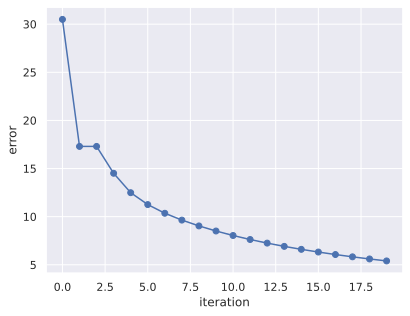

In [280]:
# full training set D
import copy
D = [(fv, 1 if label==1 else -1) for label, fv in train_sml[['Sentiment', 'feature_vector']].values]
theta = np.zeros(len(vocabulary_sml))
theta = gradient_descent(gradient_logistic, nll, theta, .3, D, .01, 20)

In [281]:
print('results on training data')
train_sml['pr_pos_lr'] = [logistic(features2sparse_array(f, vocabulary_sml), theta) for f in train_sml.features]
train_sml['predicted_label_lr'] = [1.0 if v >= .5 else 0.0 for v in train_sml.pr_pos_lr]
print(classification_report(train_sml.Sentiment, train_sml.predicted_label_lr))

print('results on testing data')
test_sml['pr_pos_lr'] = [logistic(features2sparse_array(f, vocabulary_sml), theta) for f in test_sml.features]
test_sml['predicted_label_lr'] = [1.0 if v >= .5 else 0.0 for v in test_sml.pr_pos_lr]
print(classification_report(test_sml.Sentiment, test_sml.predicted_label_lr))

results on training data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        26

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44

results on testing data
              precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       0.40      0.40      0.40         5

    accuracy                           0.40        10
   macro avg       0.40      0.40      0.40        10
weighted avg       0.40      0.40      0.40        10



<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))
<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


In [282]:
# print top coefficients for each class.
reverse_vocab = {i:v for v,i in vocabulary_sml.items()}
for i in np.argsort(theta)[::-1][:15]:
    print(reverse_vocab[i], theta[i])
print()
for i in np.argsort(theta)[:15]:
    print(reverse_vocab[i], theta[i])

them 1.4281582315990413
easy 1.3555494848267942
get 1.3507379667089106
students 1.338938534992531
it's 1.2362296978611003
really 1.148310267025014
assignments 1.1273596468930838
wants 1.102921472190545
love 1.0847978603784825
lab 1.0036301987198009
most 0.949537376816856
professor 0.8827805612684219
an 0.8587738149125829
with 0.8552836347610464
super 0.8430750851446231

they -1.491791185271853
are -1.40806110328956
mcat -1.2625320197694807
online -1.186602213500375
other -1.1736424662847187
instead -1.16645684922768
not -1.1467430211012202
for -1.1008343842345554
take-home -1.0880488962560444
so -1.0322570042744894
doesn't -0.9641966028137761
pictures -0.8925643673306803
draw -0.8925643673306803
lectures -0.8549922942859725
anything -0.7868534571516589


I love how mcat is associated with negative sentiment [bc I completely agree]

In [283]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(max_df=100, min_df=2, binary=True)
print(vec)
X_train = vec.fit_transform(train_sml.Breakdown)
X_test = vec.transform(test_sml.Breakdown)
nb = BernoulliNB(alpha=1)
nb.fit(X_train, train_sml.Sentiment)
y_pred = nb.predict(X_test)
print(classification_report(test_sml.Sentiment, y_pred))

CountVectorizer(binary=True, max_df=100, min_df=2)
              precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.50      0.60      0.55         5

    accuracy                           0.50        10
   macro avg       0.50      0.50      0.49        10
weighted avg       0.50      0.50      0.49        10



In [284]:
lr = LogisticRegression(C=1) #penalty of None was giving lower scores
lr.fit(X_train, train_sml.Sentiment)
y_pred = lr.predict(X_test)
print(classification_report(test_sml.Sentiment, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       0.40      0.40      0.40         5

    accuracy                           0.40        10
   macro avg       0.40      0.40      0.40        10
weighted avg       0.40      0.40      0.40        10



In [285]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

parameters = {'classifier__alpha': [1E5,1E4, 1E3, 1E2, 0, 0.5, 1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6, 1E-7, 1E-8], 'vectorizer__max_df': [1, 100], 'vectorizer__min_df': [1, 2], 'vectorizer__binary': [True, False]}
testmodel = MultinomialNB()


pipeline = Pipeline([('vectorizer', CountVectorizer()), ('classifier', testmodel)])

grid_search = GridSearchCV(estimator=pipeline, param_grid=parameters, cv=5, scoring='accuracy')
grid_search.fit(train_sml.Breakdown, train_sml.Sentiment)


bestparam = grid_search.best_params_
bestmodel = grid_search.best_estimator_

accuracy_win = bestmodel.score(test_sml.Breakdown, test_sml.Sentiment)
print("Accuracy = ", accuracy_win)
print("Best parameters = ", bestparam)

#failed attempt at cross val


/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default val

Accuracy =  0.7
Best parameters =  {'classifier__alpha': 0, 'vectorizer__binary': False, 'vectorizer__max_df': 100, 'vectorizer__min_df': 1}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
140 fits failed out of a total of 560.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/dist-

## second trial run - new data edition

The size of my dataset is incredibly small, so I've been worried about building more complex models. This led me to a new idea: supplementing my information!

I expanded and collected more reviews relating to Tulane CELL professors [outside of just my target prof]

In [286]:
newdata = pd.read_excel('/content/drive/MyDrive/nlp/biggeerdata-cleaned.xlsx')

newdata

,Class,Quality,Difficulty,Breakdown,Sentiment,Who?
0,CELL,1.0,3.0,Take the other biochem professor!!,0,1
1,CELL,1.0,2.0,"The professor doesn't teach you anything, you ...",0,1
2,CELL,2.0,2.0,The tests aren't take-home anymore and were so...,0,1
3,CELL,5.0,2.0,"You have to teach yourself everything, but sti...",0,1
4,CELL,3.0,2.0,Doesn't prepare you well for the future if you...,0,1
...,...,...,...,...,...,...
168,NaN,NaN,NaN,Incredibly dry lectures that do not help at al...,0,0
169,NaN,NaN,NaN,incredibly lazy and makes the TA's do everythi...,0,0
170,NaN,NaN,NaN,will call on you throughout the lecture and wi...,0,0
171,NaN,NaN,NaN,"Alarmingly disorganized class, homework assign...",0,0


<Axes: xlabel='Sentiment'>

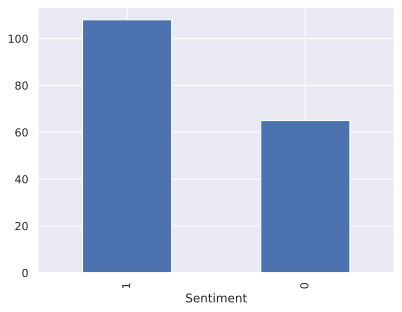

In [287]:
newdata.Sentiment.value_counts().plot.bar()

I now have significantly more data to work with

<Axes: xlabel='Who?'>

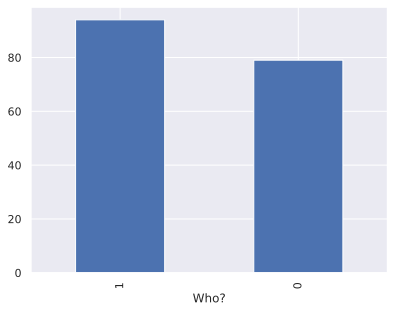

In [288]:
newdata['Who?'].value_counts().plot.bar()

I additionally added a new binary value to represent whether the review pertained to my original target biochem professor [label = 1] or a different Tulane cell professor [label = 0]

In [289]:
sentences_from_breakdown = newdata['Breakdown'].values.tolist()
#print(sentences_from_breakdown)

temp_vocab = []
stripped_sentences = []

for x in sentences_from_breakdown:
  x = str(x).lower()
  if "an a " in x:
    x = x.replace("an a", "an a+")

  testing_tokens = x.split()
  #testing_tokens2 = [tok.strip('.!,') for tok in testing_tokens if tok not in maddiestop]
  testing_tokens2 = [tok.strip('."!,-\()') for tok in testing_tokens]

  for q in testing_tokens2:
    q = q.strip()

    if '/' in q:
      #print(testing_tokens2)

      one, two = q.split('/')
      temp_vocab.append(one)
      temp_vocab.append(two)

    else:
      if q != '':
        temp_vocab.append(q)

  sent = ' '.join(testing_tokens2)
  if '/' not in sent:
    stripped_sentences.append(sent)
  else:
    newsent = sent.replace('/', ' ')
    #print(newsent)
    stripped_sentences.append(newsent)



print('total number of words in docs is: ', len(temp_vocab))

set_of_temp_vocab = sorted(set(temp_vocab))

print('total unique words is ', len(set_of_temp_vocab))
print(set_of_temp_vocab)
print(stripped_sentences)

total number of words in docs is:  2427
total unique words is  707
['', '&', '1', '100%', '120', 'a', "a's", 'a+', 'ability', 'about', 'absolute', 'absolutely', 'abstract', 'abundantly', 'access', 'accessibility', 'accomadation', 'accommodate', 'accommodating', 'accordingly', 'account', 'across', 'actual', 'actually', 'adult', 'after', 'again', 'alarmingly', 'all', 'allowed', 'already', 'also', 'although', 'always', 'amazing', 'amount', 'amounts', 'an', 'analytical', 'analyze', 'and', 'angry', 'another', 'answer', 'answering', 'answers', 'any', 'anymore', 'anything', 'applications', 'apply', 'appreciate', 'appreciation', 'approach', 'approachable', 'are', "aren't", 'around', 'arrogant', 'articles', 'as', 'asked', 'aspect', 'assessment', 'assignment', 'assignments', 'assist', 'at', 'atmosphere', 'attendance', 'attending', 'attitude', 'back', 'backgrounds', 'based', 'basically', 'be', 'because', 'been', 'before', 'began', 'behind', 'being', 'belittles', 'beneficial', 'best', 'better', 'b

In [290]:
nonclean_vocab = MakeVocab(set_of_temp_vocab)

nonclean_vocab.vocabulary[0:10]

['', '&', '1', '100%', '120', 'a', "a's", 'a+', 'ability', 'about']

I was curious how my original approach would fare with more data to use

In [291]:
newdata_copy = newdata.copy()
newdata_copy['tokens'] = [tokenize(d, strip_punct=True, ignore_case=True) for d in newdata_copy.Breakdown]
newdata_copy['raw_features'] = [featurize(t) for t in newdata_copy.tokens]
word_counts = count_word_document_frequency(newdata_copy.raw_features)

print(word_counts)
print(len(word_counts))
word_counts.most_common(10)

Counter({'and': 87, 'the': 84, 'to': 62, 'professor': 55, 'class': 44, 'a': 44, 'in': 43, 'is': 42, 'you': 39, 'i': 38, 'for': 32, 'of': 32, 'are': 24, 'this': 23, 'very': 22, 'not': 22, 'tests': 18, 'they': 18, 'that': 18, 'have': 17, 'material': 17, 'so': 15, 'students': 15, 'as': 15, 'if': 14, 'it': 14, 'really': 14, 'be': 13, 'lectures': 13, 'on': 13, 'learned': 13, 'but': 12, 'about': 12, 'at': 11, 'hard': 10, 'their': 10, 'great': 10, 'take': 9, 'biochem': 9, 'an': 9, 'mcat': 9, 'do': 9, 'my': 9, 'course': 9, 'them': 8, 'makes': 8, 'with': 8, 'understand': 8, 'science': 8, 'well': 7, 'get': 7, 'make': 7, 'can': 7, 'know': 7, 'lot': 7, 'most': 7, 'all': 7, 'fair': 7, 'lecture': 7, 'will': 7, 'learning': 7, 'more': 7, 'me': 7, 'just': 6, 'from': 6, 'stem': 6, 'lab': 6, 'has': 6, 'way': 6, 'was': 6, 'one': 6, 'through': 6, 'no': 6, 'what': 6, 'gained': 6, 'interesting': 6, 'teach': 5, 'anything': 5, 'were': 5, 'yourself': 5, 'because': 5, 'extremely': 5, 'learn': 5, 'easy': 5, 'litt

[('and', 87),
 ('the', 84),
 ('to', 62),
 ('professor', 55),
 ('class', 44),
 ('a', 44),
 ('in', 43),
 ('is', 42),
 ('you', 39),
 ('i', 38)]

In [292]:
big_vocabulary = create_vocabulary_hw1(word_counts, min_count=2, max_count=100)
list(big_vocabulary.items())[:10]

[('', 0),
 ('a', 1),
 ('ability', 2),
 ('about', 3),
 ('abstract', 4),
 ('accommodate', 5),
 ('accommodating', 6),
 ('after', 7),
 ('again', 8),
 ('all', 9)]

In [293]:
newdata_copy['features'] = [prune_features(big_vocabulary, f) for f in newdata_copy.raw_features]

p_x_given_pos_big = p_x_given_y(newdata_copy, big_vocabulary, 1, epsilon=1)
p_x_given_neg_big = p_x_given_y(newdata_copy, big_vocabulary, 0, epsilon=1)

word_scores_big = pd.DataFrame([{'word':w, 'pos_score': p_x_given_pos_big[w] - p_x_given_neg_big[w]} for w in big_vocabulary])
print('positive terms')
display(word_scores_big.sort_values('pos_score', ascending=False).head(10))

print('negative terms')
display(word_scores_big.sort_values('pos_score', ascending=True).head(10))

Counter({'the': 35, 'and': 26, 'class': 23, 'is': 17, 'a': 17, 'professor': 16, 'you': 16, 'in': 15, 'to': 15, 'for': 15, 'of': 15, 'not': 13, 'i': 13, 'tests': 11, 'are': 11, 'this': 11, 'material': 9, 'they': 8, 'so': 7, 'have': 7, 'but': 7, 'very': 7, 'lectures': 7, 'on': 7, 'take': 5, 'teach': 5, 'anything': 5, 'yourself': 5, 'hard': 5, 'if': 5, 'be': 5, 'as': 5, 'no': 5, "doesn't": 4, 'make': 4, 'their': 4, 'students': 4, 'mcat': 4, 'would': 4, 'at': 4, 'all': 4, 'never': 4, 'lecture': 4, 'will': 4, 'do': 4, 'more': 4, 'just': 3, 'everything': 3, 'instead': 3, 'learn': 3, 'really': 3, "don't": 3, 'that': 3, 'little': 3, 'exam': 3, 'makes': 3, 'dry': 3, 'your': 3, 'one': 3, 'it': 3, 'most': 3, 'slides': 3, 'teacher': 3, 'answers': 3, 'biochem': 2, 'draw': 2, 'pictures': 2, "aren't": 2, 'take-home': 2, 'were': 2, 'prepare': 2, 'because': 2, 'premed': 2, 'extremely': 2, 'lazy': 2, 'teaching': 2, 'rude': 2, 'great': 2, 'from': 2, 'definitely': 2, 'online': 2, 'lab': 2, 'there': 2, 'th

,word,pos_score
14,and,0.173267
245,to,0.158416
189,professor,0.113861
233,the,0.069307
113,in,0.064356
232,that,0.059406
109,i,0.059406
130,learned,0.054455
1,a,0.049505
121,is,0.039604


negative terms


,word,pos_score
284,yourself,-0.024752
18,anything,-0.024752
226,teach,-0.024752
165,not,-0.019802
161,never,-0.019802
63,doesn't,-0.019802
230,tests,-0.019802
164,no,-0.019802
281,would,-0.014851
227,teacher,-0.014851


Just like in the small vocab set, the words that rank the highest are often stopwords

In [294]:
new_vocab_big = refining_vocabulary(big_vocabulary, word_counts)

newdata_copy['features clean'] = [prune_features(new_vocab_big, f) for f in newdata_copy.raw_features]
newdata_copy

p_x_given_pos_bigclean = p_x_given_y(newdata_copy, new_vocab_big, 1, epsilon=1)
p_x_given_neg_bigclean = p_x_given_y(newdata_copy, new_vocab_big, 0, epsilon=1)

word_scores_bigclean = pd.DataFrame([{'word':w, 'pos_score': p_x_given_pos_bigclean[w] - p_x_given_neg_bigclean[w]} for w in new_vocab_big])
print('positive terms')
display(word_scores_bigclean.sort_values('pos_score', ascending=False).head(10))

print('negative terms')
display(word_scores_bigclean.sort_values('pos_score', ascending=True).head(10))

Counter({'the': 35, 'and': 26, 'class': 23, 'is': 17, 'a': 17, 'professor': 16, 'you': 16, 'in': 15, 'to': 15, 'for': 15, 'of': 15, 'not': 13, 'i': 13, 'tests': 11, 'are': 11, 'this': 11, 'material': 9, 'they': 8, 'so': 7, 'have': 7, 'but': 7, 'very': 7, 'lectures': 7, 'on': 7, 'take': 5, 'teach': 5, 'anything': 5, 'yourself': 5, 'hard': 5, 'if': 5, 'be': 5, 'as': 5, 'no': 5, "doesn't": 4, 'make': 4, 'their': 4, 'students': 4, 'mcat': 4, 'would': 4, 'at': 4, 'all': 4, 'never': 4, 'lecture': 4, 'will': 4, 'do': 4, 'more': 4, 'just': 3, 'everything': 3, 'instead': 3, 'learn': 3, 'really': 3, "don't": 3, 'that': 3, 'little': 3, 'exam': 3, 'makes': 3, 'dry': 3, 'your': 3, 'one': 3, 'it': 3, 'most': 3, 'slides': 3, 'teacher': 3, 'answers': 3, 'biochem': 2, 'draw': 2, 'pictures': 2, "aren't": 2, 'take-home': 2, 'were': 2, 'prepare': 2, 'because': 2, 'premed': 2, 'extremely': 2, 'lazy': 2, 'teaching': 2, 'rude': 2, 'great': 2, 'from': 2, 'definitely': 2, 'online': 2, 'lab': 2, 'there': 2, 'th

,word,pos_score
139,professor,0.113861
93,learned,0.054455
146,really,0.039604
64,get,0.034653
94,learning,0.034653
37,course,0.034653
160,students,0.034653
200,way,0.029703
63,gained,0.029703
152,science,0.029703


negative terms


,word,pos_score
11,anything,-0.024752
173,teach,-0.024752
119,never,-0.019802
177,tests,-0.019802
205,would,-0.014851
174,teacher,-0.014851
45,dry,-0.014851
10,answers,-0.014851
85,instead,-0.014851
52,everything,-0.014851


these definitely look better - "dry" is a word that could reasonably describe a boring lecture

I also manually split the information into training and testing df's

In [295]:
train_big = pd.read_excel('/content/drive/MyDrive/nlp/train-biggeerdata-cleaned.xlsx')
test_big = pd.read_excel('/content/drive/MyDrive/nlp/test-biggeerdata-cleaned.xlsx')

In [296]:
prior = compute_prior(train_big)

train_big['tokens'] = [tokenize(d, strip_punct=True, ignore_case=True) for d in train_big.Breakdown]
train_big['raw_features'] = [featurize(t) for t in train_big.tokens]
train_big['features'] = [prune_features(big_vocabulary, f) for f in train_big.raw_features]

test_big['tokens'] = [tokenize(d, strip_punct=True, ignore_case=True) for d in test_big.Breakdown]
test_big['raw_features'] = [featurize(t) for t in test_big.tokens]
test_big['features'] = [prune_features(big_vocabulary, f) for f in test_big.raw_features]
test_big.head(2)

,Class,Quality,Difficulty,Breakdown,Sentiment,Who?,tokens,raw_features,features
0,CELL,1.0,3.0,"yes, the professor is a straight-from-the-text...",0,1,"[yes, the, professor, is, a, straight-from-the...","{'yes': 1, 'the': 1, 'professor': 1, 'is': 1, ...","{'the': 1, 'professor': 1, 'is': 1, 'a': 1}"
1,CELL,1.0,2.0,makes up for it in their willingness to accom...,1,1,"[makes, up, for, it, in, their, willingness, t...","{'makes': 1, 'up': 1, 'for': 1, 'it': 1, 'in':...","{'makes': 1, 'up': 1, 'for': 1, 'it': 1, 'in':..."


In [297]:
train_big['pr_pos'] = [pr_pos_given_x(f, p_x_given_pos_big, p_x_given_neg_big, prior, big_vocabulary)
                      for f in train_big.features]
test_big['pr_pos'] = [pr_pos_given_x(f, p_x_given_pos_big, p_x_given_neg_big, prior, big_vocabulary)
                     for f in test_big.features]
test_big.head(2)

,Class,Quality,Difficulty,Breakdown,Sentiment,Who?,tokens,raw_features,features,pr_pos
0,CELL,1.0,3.0,"yes, the professor is a straight-from-the-text...",0,1,"[yes, the, professor, is, a, straight-from-the...","{'yes': 1, 'the': 1, 'professor': 1, 'is': 1, ...","{'the': 1, 'professor': 1, 'is': 1, 'a': 1}",0.571555
1,CELL,1.0,2.0,makes up for it in their willingness to accom...,1,1,"[makes, up, for, it, in, their, willingness, t...","{'makes': 1, 'up': 1, 'for': 1, 'it': 1, 'in':...","{'makes': 1, 'up': 1, 'for': 1, 'it': 1, 'in':...",0.986232


In [298]:
train_big['predicted_label'] = [1.0 if v >= .5 else 0.0 for v in train_big['pr_pos']]
test_big['predicted_label'] = [1.0 if v >= .5 else 0.0 for v in test_big['pr_pos']]


print('results on training data')
print(classification_report(train_big.Sentiment, train_big.predicted_label))
print('results on testing data')
print(classification_report(test_big.Sentiment, test_big.predicted_label))

results on training data
              precision    recall  f1-score   support

           0       0.96      0.78      0.86        55
           1       0.88      0.98      0.93        90

    accuracy                           0.90       145
   macro avg       0.92      0.88      0.89       145
weighted avg       0.91      0.90      0.90       145

results on testing data
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.93      1.00      0.96        25

    accuracy                           0.94        35
   macro avg       0.96      0.90      0.93        35
weighted avg       0.95      0.94      0.94        35



Looks a lot better than with the smaller datast

In [299]:
dense_array = features2array(train_big.features[0], big_vocabulary)
sparse_array = features2sparse_array(train_big.features[0], big_vocabulary)
print('document contains %d/%d words' % (sparse_array.nnz, len(big_vocabulary)))
print('dense array requires %d bytes, sparse array requires %d bytes' %
      (dense_array.nbytes, sparse_array.data.nbytes + sparse_array.indices.nbytes + sparse_array.indptr.nbytes))

document contains 5/285 words
dense array requires 2280 bytes, sparse array requires 68 bytes


<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 32)\t1.0\n (0, 176)\t1.0\n (0, 189)\t1...",-1,0.5,0.5
1,"(0, 18)\t1.0\n (0, 42)\t1.0\n (0, 63)\t1.0...",-1,0.5,0.5
2,"(0, 14)\t1.0\n (0, 20)\t1.0\n (0, 207)\t1....",-1,0.5,0.5
3,"(0, 29)\t1.0\n (0, 36)\t1.0\n (0, 63)\t1.0...",-1,0.5,0.5
4,"(0, 19)\t1.0\n (0, 63)\t1.0\n (0, 85)\t1.0...",-1,0.5,0.5
...,...,...,...,...
140,"(0, 16)\t1.0\n (0, 17)\t1.0\n (0, 42)\t1.0...",-1,0.5,0.5
141,"(0, 1)\t1.0\n (0, 14)\t1.0\n (0, 34)\t1.0\...",-1,0.5,0.5
142,"(0, 3)\t1.0\n (0, 17)\t1.0\n (0, 72)\t1.0\...",-1,0.5,0.5
143,"(0, 9)\t1.0\n (0, 14)\t1.0\n (0, 23)\t1.0\...",-1,0.5,0.5




iteration 1
gradient= [ -1.   -4.   -2.   -2.5  -0.    0.5  -1.   -1.   -0.    1.5  -0.5   0.5
  -1.   -3.  -15.   -0.    1.    1.    2.5  -1.5   0.5  -2.5  -1.5  -1.
  -0.    1.   -0.5  -0.5  -0.   -0.5  -0.   -1.5  -2.5  -1.   -0.   -0.
   0.5  -0.5  -0.5  -2.   -2.5  -0.5   1.5  -0.   -0.5  -1.   -1.    1.
  -0.5  -0.   -0.5  -0.    0.5  -0.   -3.   -1.5  -1.    1.   -0.   -0.
  -0.    0.5   1.    2.   -0.    1.   -1.    1.    0.5  -2.5  -1.   -1.
  -0.    0.5  -1.    1.5   1.   -1.   -1.   -0.5   0.5  -2.   -1.5   1.
  -0.5  -1.5  -0.5  -0.5  -2.5  -3.    1.   -0.5  -0.5  -1.5  -0.   -0.
  -3.    0.5  -0.   -0.5  -1.5  -0.   -0.5  -1.   -0.5  -0.5   0.5  -0.5
  -0.   -4.   -1.   -1.   -1.   -2.    0.5   0.5   1.    1.5  -2.   -0.5
  -0.5  -4.   -2.   -1.   -0.5  -2.   -1.   -1.    1.    0.5  -4.5  -2.5
  -0.5  -0.   -0.   -0.   -0.5  -0.5  -1.5  -2.   -0.5  -1.    0.5  -0.
  -0.   -1.    0.5  -0.5  -2.   -1.   -1.5  -0.   -0.    1.   -0.5  -0.5
  -0.5  -2.5   0.5  -0.   -1.    2.

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 32)\t1.0\n (0, 176)\t1.0\n (0, 189)\t1...",-1,0.008163,0.991837
1,"(0, 18)\t1.0\n (0, 42)\t1.0\n (0, 63)\t1.0...",-1,0.054681,0.945319
2,"(0, 14)\t1.0\n (0, 20)\t1.0\n (0, 207)\t1....",-1,0.004496,0.995504
3,"(0, 29)\t1.0\n (0, 36)\t1.0\n (0, 63)\t1.0...",-1,0.001833,0.998167
4,"(0, 19)\t1.0\n (0, 63)\t1.0\n (0, 85)\t1.0...",-1,0.041091,0.958909
...,...,...,...,...
140,"(0, 16)\t1.0\n (0, 17)\t1.0\n (0, 42)\t1.0...",-1,0.289050,0.710950
141,"(0, 1)\t1.0\n (0, 14)\t1.0\n (0, 34)\t1.0\...",-1,0.003872,0.996128
142,"(0, 3)\t1.0\n (0, 17)\t1.0\n (0, 72)\t1.0\...",-1,0.574443,0.425557
143,"(0, 9)\t1.0\n (0, 14)\t1.0\n (0, 23)\t1.0\...",-1,0.010987,0.989013


<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


old error=100.506   new error=286.487  theta=[ 0.3   1.2   0.6   0.75  0.   -0.15  0.3   0.3   0.   -0.45  0.15 -0.15
  0.3   0.9   4.5   0.   -0.3  -0.3  -0.75  0.45 -0.15  0.75  0.45  0.3
  0.   -0.3   0.15  0.15  0.    0.15  0.    0.45  0.75  0.3   0.    0.
 -0.15  0.15  0.15  0.6   0.75  0.15 -0.45  0.    0.15  0.3   0.3  -0.3
  0.15  0.    0.15  0.   -0.15  0.    0.9   0.45  0.3  -0.3   0.    0.
  0.   -0.15 -0.3  -0.6   0.   -0.3   0.3  -0.3  -0.15  0.75  0.3   0.3
  0.   -0.15  0.3  -0.45 -0.3   0.3   0.3   0.15 -0.15  0.6   0.45 -0.3
  0.15  0.45  0.15  0.15  0.75  0.9  -0.3   0.15  0.15  0.45  0.    0.
  0.9  -0.15  0.    0.15  0.45  0.    0.15  0.3   0.15  0.15 -0.15  0.15
  0.    1.2   0.3   0.3   0.3   0.6  -0.15 -0.15 -0.3  -0.45  0.6   0.15
  0.15  1.2   0.6   0.3   0.15  0.6   0.3   0.3  -0.3  -0.15  1.35  0.75
  0.15  0.    0.    0.    0.15  0.15  0.45  0.6   0.15  0.3  -0.15  0.
  0.    0.3  -0.15  0.15  0.6   0.3   0.45  0.    0.   -0.3   0.15  0.15
  0.15  0.75 -0.15

,x,y,prediction,error
0,"(0, 32)\t1.0\n (0, 176)\t1.0\n (0, 189)\t1...",-1,0.5,0.5
1,"(0, 18)\t1.0\n (0, 42)\t1.0\n (0, 63)\t1.0...",-1,0.5,0.5
2,"(0, 14)\t1.0\n (0, 20)\t1.0\n (0, 207)\t1....",-1,0.5,0.5
3,"(0, 29)\t1.0\n (0, 36)\t1.0\n (0, 63)\t1.0...",-1,0.5,0.5
4,"(0, 19)\t1.0\n (0, 63)\t1.0\n (0, 85)\t1.0...",-1,0.5,0.5
...,...,...,...,...
140,"(0, 16)\t1.0\n (0, 17)\t1.0\n (0, 42)\t1.0...",-1,0.5,0.5
141,"(0, 1)\t1.0\n (0, 14)\t1.0\n (0, 34)\t1.0\...",-1,0.5,0.5
142,"(0, 3)\t1.0\n (0, 17)\t1.0\n (0, 72)\t1.0\...",-1,0.5,0.5
143,"(0, 9)\t1.0\n (0, 14)\t1.0\n (0, 23)\t1.0\...",-1,0.5,0.5




iteration 2
gradient= [ -1.   -4.   -2.   -2.5  -0.    0.5  -1.   -1.   -0.    1.5  -0.5   0.5
  -1.   -3.  -15.   -0.    1.    1.    2.5  -1.5   0.5  -2.5  -1.5  -1.
  -0.    1.   -0.5  -0.5  -0.   -0.5  -0.   -1.5  -2.5  -1.   -0.   -0.
   0.5  -0.5  -0.5  -2.   -2.5  -0.5   1.5  -0.   -0.5  -1.   -1.    1.
  -0.5  -0.   -0.5  -0.    0.5  -0.   -3.   -1.5  -1.    1.   -0.   -0.
  -0.    0.5   1.    2.   -0.    1.   -1.    1.    0.5  -2.5  -1.   -1.
  -0.    0.5  -1.    1.5   1.   -1.   -1.   -0.5   0.5  -2.   -1.5   1.
  -0.5  -1.5  -0.5  -0.5  -2.5  -3.    1.   -0.5  -0.5  -1.5  -0.   -0.
  -3.    0.5  -0.   -0.5  -1.5  -0.   -0.5  -1.   -0.5  -0.5   0.5  -0.5
  -0.   -4.   -1.   -1.   -1.   -2.    0.5   0.5   1.    1.5  -2.   -0.5
  -0.5  -4.   -2.   -1.   -0.5  -2.   -1.   -1.    1.    0.5  -4.5  -2.5
  -0.5  -0.   -0.   -0.   -0.5  -0.5  -1.5  -2.   -0.5  -1.    0.5  -0.
  -0.   -1.    0.5  -0.5  -2.   -1.   -1.5  -0.   -0.    1.   -0.5  -0.5
  -0.5  -2.5   0.5  -0.   -1.    2.

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 32)\t1.0\n (0, 176)\t1.0\n (0, 189)\t1...",-1,0.083173,0.916827
1,"(0, 18)\t1.0\n (0, 42)\t1.0\n (0, 63)\t1.0...",-1,0.193879,0.806121
2,"(0, 14)\t1.0\n (0, 20)\t1.0\n (0, 207)\t1....",-1,0.062973,0.937027
3,"(0, 29)\t1.0\n (0, 36)\t1.0\n (0, 63)\t1.0...",-1,0.041091,0.958909
4,"(0, 19)\t1.0\n (0, 63)\t1.0\n (0, 85)\t1.0...",-1,0.171505,0.828495
...,...,...,...,...
140,"(0, 16)\t1.0\n (0, 17)\t1.0\n (0, 42)\t1.0...",-1,0.389361,0.610639
141,"(0, 1)\t1.0\n (0, 14)\t1.0\n (0, 34)\t1.0\...",-1,0.058690,0.941310
142,"(0, 3)\t1.0\n (0, 17)\t1.0\n (0, 72)\t1.0\...",-1,0.537430,0.462570
143,"(0, 9)\t1.0\n (0, 14)\t1.0\n (0, 23)\t1.0\...",-1,0.095349,0.904651


old error=100.506   new error=154.46  theta=[ 0.15   0.6    0.3    0.375  0.    -0.075  0.15   0.15   0.    -0.225
  0.075 -0.075  0.15   0.45   2.25   0.    -0.15  -0.15  -0.375  0.225
 -0.075  0.375  0.225  0.15   0.    -0.15   0.075  0.075  0.     0.075
  0.     0.225  0.375  0.15   0.     0.    -0.075  0.075  0.075  0.3
  0.375  0.075 -0.225  0.     0.075  0.15   0.15  -0.15   0.075  0.
  0.075  0.    -0.075  0.     0.45   0.225  0.15  -0.15   0.     0.
  0.    -0.075 -0.15  -0.3    0.    -0.15   0.15  -0.15  -0.075  0.375
  0.15   0.15   0.    -0.075  0.15  -0.225 -0.15   0.15   0.15   0.075
 -0.075  0.3    0.225 -0.15   0.075  0.225  0.075  0.075  0.375  0.45
 -0.15   0.075  0.075  0.225  0.     0.     0.45  -0.075  0.     0.075
  0.225  0.     0.075  0.15   0.075  0.075 -0.075  0.075  0.     0.6
  0.15   0.15   0.15   0.3   -0.075 -0.075 -0.15  -0.225  0.3    0.075
  0.075  0.6    0.3    0.15   0.075  0.3    0.15   0.15  -0.15  -0.075
  0.675  0.375  0.075  0.     0.     0.     

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 32)\t1.0\n (0, 176)\t1.0\n (0, 189)\t1...",-1,0.5,0.5
1,"(0, 18)\t1.0\n (0, 42)\t1.0\n (0, 63)\t1.0...",-1,0.5,0.5
2,"(0, 14)\t1.0\n (0, 20)\t1.0\n (0, 207)\t1....",-1,0.5,0.5
3,"(0, 29)\t1.0\n (0, 36)\t1.0\n (0, 63)\t1.0...",-1,0.5,0.5
4,"(0, 19)\t1.0\n (0, 63)\t1.0\n (0, 85)\t1.0...",-1,0.5,0.5
...,...,...,...,...
140,"(0, 16)\t1.0\n (0, 17)\t1.0\n (0, 42)\t1.0...",-1,0.5,0.5
141,"(0, 1)\t1.0\n (0, 14)\t1.0\n (0, 34)\t1.0\...",-1,0.5,0.5
142,"(0, 3)\t1.0\n (0, 17)\t1.0\n (0, 72)\t1.0\...",-1,0.5,0.5
143,"(0, 9)\t1.0\n (0, 14)\t1.0\n (0, 23)\t1.0\...",-1,0.5,0.5


<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))




iteration 3
gradient= [ -1.   -4.   -2.   -2.5  -0.    0.5  -1.   -1.   -0.    1.5  -0.5   0.5
  -1.   -3.  -15.   -0.    1.    1.    2.5  -1.5   0.5  -2.5  -1.5  -1.
  -0.    1.   -0.5  -0.5  -0.   -0.5  -0.   -1.5  -2.5  -1.   -0.   -0.
   0.5  -0.5  -0.5  -2.   -2.5  -0.5   1.5  -0.   -0.5  -1.   -1.    1.
  -0.5  -0.   -0.5  -0.    0.5  -0.   -3.   -1.5  -1.    1.   -0.   -0.
  -0.    0.5   1.    2.   -0.    1.   -1.    1.    0.5  -2.5  -1.   -1.
  -0.    0.5  -1.    1.5   1.   -1.   -1.   -0.5   0.5  -2.   -1.5   1.
  -0.5  -1.5  -0.5  -0.5  -2.5  -3.    1.   -0.5  -0.5  -1.5  -0.   -0.
  -3.    0.5  -0.   -0.5  -1.5  -0.   -0.5  -1.   -0.5  -0.5   0.5  -0.5
  -0.   -4.   -1.   -1.   -1.   -2.    0.5   0.5   1.    1.5  -2.   -0.5
  -0.5  -4.   -2.   -1.   -0.5  -2.   -1.   -1.    1.    0.5  -4.5  -2.5
  -0.5  -0.   -0.   -0.   -0.5  -0.5  -1.5  -2.   -0.5  -1.    0.5  -0.
  -0.   -1.    0.5  -0.5  -2.   -1.   -1.5  -0.   -0.    1.   -0.5  -0.5
  -0.5  -2.5   0.5  -0.   -1.    2.

,x,y,prediction,error
0,"(0, 32)\t1.0\n (0, 176)\t1.0\n (0, 189)\t1...",-1,0.231475,0.768525
1,"(0, 18)\t1.0\n (0, 42)\t1.0\n (0, 63)\t1.0...",-1,0.329047,0.670953
2,"(0, 14)\t1.0\n (0, 20)\t1.0\n (0, 207)\t1....",-1,0.205870,0.794130
3,"(0, 29)\t1.0\n (0, 36)\t1.0\n (0, 63)\t1.0...",-1,0.171505,0.828495
4,"(0, 19)\t1.0\n (0, 63)\t1.0\n (0, 85)\t1.0...",-1,0.312706,0.687294
...,...,...,...,...
140,"(0, 16)\t1.0\n (0, 17)\t1.0\n (0, 42)\t1.0...",-1,0.443986,0.556014
141,"(0, 1)\t1.0\n (0, 14)\t1.0\n (0, 34)\t1.0\...",-1,0.199807,0.800193
142,"(0, 3)\t1.0\n (0, 17)\t1.0\n (0, 72)\t1.0\...",-1,0.518741,0.481259
143,"(0, 9)\t1.0\n (0, 14)\t1.0\n (0, 23)\t1.0\...",-1,0.245085,0.754915


old error=100.506   new error=100.034  theta=[ 0.075   0.3     0.15    0.1875  0.     -0.0375  0.075   0.075   0.
 -0.1125  0.0375 -0.0375  0.075   0.225   1.125   0.     -0.075  -0.075
 -0.1875  0.1125 -0.0375  0.1875  0.1125  0.075   0.     -0.075   0.0375
  0.0375  0.      0.0375  0.      0.1125  0.1875  0.075   0.      0.
 -0.0375  0.0375  0.0375  0.15    0.1875  0.0375 -0.1125  0.      0.0375
  0.075   0.075  -0.075   0.0375  0.      0.0375  0.     -0.0375  0.
  0.225   0.1125  0.075  -0.075   0.      0.      0.     -0.0375 -0.075
 -0.15    0.     -0.075   0.075  -0.075  -0.0375  0.1875  0.075   0.075
  0.     -0.0375  0.075  -0.1125 -0.075   0.075   0.075   0.0375 -0.0375
  0.15    0.1125 -0.075   0.0375  0.1125  0.0375  0.0375  0.1875  0.225
 -0.075   0.0375  0.0375  0.1125  0.      0.      0.225  -0.0375  0.
  0.0375  0.1125  0.      0.0375  0.075   0.0375  0.0375 -0.0375  0.0375
  0.      0.3     0.075   0.075   0.075   0.15   -0.0375 -0.0375 -0.075
 -0.1125  0.15    0.0375  0

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 32)\t1.0\n (0, 176)\t1.0\n (0, 189)\t1...",-1,0.783262,0.216738
1,"(0, 18)\t1.0\n (0, 42)\t1.0\n (0, 63)\t1.0...",-1,0.992578,0.007422
2,"(0, 14)\t1.0\n (0, 20)\t1.0\n (0, 207)\t1....",-1,0.918796,0.081204
3,"(0, 29)\t1.0\n (0, 36)\t1.0\n (0, 63)\t1.0...",-1,0.993661,0.006339
4,"(0, 19)\t1.0\n (0, 63)\t1.0\n (0, 85)\t1.0...",-1,0.949708,0.050292
...,...,...,...,...
140,"(0, 16)\t1.0\n (0, 17)\t1.0\n (0, 42)\t1.0...",-1,0.984476,0.015524
141,"(0, 1)\t1.0\n (0, 14)\t1.0\n (0, 34)\t1.0\...",-1,0.996351,0.003649
142,"(0, 3)\t1.0\n (0, 17)\t1.0\n (0, 72)\t1.0\...",-1,0.964657,0.035343
143,"(0, 9)\t1.0\n (0, 14)\t1.0\n (0, 23)\t1.0\...",-1,0.936904,0.063096


old error=100.034   new error=153.705  theta=[ 0.1106149  -0.31030238  0.16284794  0.14067287  0.         -0.09513936
  0.09408394  0.0833796  -0.02501814 -0.34010707  0.01274552 -0.16183556
  0.07920475  0.19295088 -0.02937275 -0.06334575 -0.1886192  -0.15279545
 -0.4775926  -0.30882927 -0.15853406 -0.05369741  0.12170873 -0.1010068
 -0.06542584 -0.17208995  0.04069459  0.03037675 -0.2546903  -0.04829577
 -0.13586716  0.15918022  0.14553467  0.06148184 -0.10208409 -0.05644829
 -0.32792881  0.01933899  0.01187898  0.17668127  0.20353902 -0.01430213
 -1.09024475 -0.07173812 -0.01911921  0.09374313  0.09556773 -0.20455751
  0.04489752 -0.05431478 -0.01500231 -0.08291529 -0.15405389 -0.03331645
  0.26571081  0.12574387  0.09504266 -0.17501814 -0.04169372 -0.05859188
 -0.04426465 -0.21046373 -0.18765254 -0.37766359 -0.11018008 -0.19317029
  0.0799179  -0.18131526 -0.11406051  0.21654699  0.08559211  0.01215789
 -0.03437111 -0.09139458  0.08910512 -0.27885852 -0.25867087  0.04375769
  0.090

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 32)\t1.0\n (0, 176)\t1.0\n (0, 189)\t1...",-1,0.231475,0.768525
1,"(0, 18)\t1.0\n (0, 42)\t1.0\n (0, 63)\t1.0...",-1,0.329047,0.670953
2,"(0, 14)\t1.0\n (0, 20)\t1.0\n (0, 207)\t1....",-1,0.205870,0.794130
3,"(0, 29)\t1.0\n (0, 36)\t1.0\n (0, 63)\t1.0...",-1,0.171505,0.828495
4,"(0, 19)\t1.0\n (0, 63)\t1.0\n (0, 85)\t1.0...",-1,0.312706,0.687294
...,...,...,...,...
140,"(0, 16)\t1.0\n (0, 17)\t1.0\n (0, 42)\t1.0...",-1,0.443986,0.556014
141,"(0, 1)\t1.0\n (0, 14)\t1.0\n (0, 34)\t1.0\...",-1,0.199807,0.800193
142,"(0, 3)\t1.0\n (0, 17)\t1.0\n (0, 72)\t1.0\...",-1,0.518741,0.481259
143,"(0, 9)\t1.0\n (0, 14)\t1.0\n (0, 23)\t1.0\...",-1,0.245085,0.754915




iteration 5
gradient= [-4.74865295e-01  8.13736502e+00 -1.71305867e-01  6.24361720e-01
 -0.00000000e+00  7.68524783e-01 -2.54452586e-01 -1.11727968e-01
  3.33575170e-01  3.03476089e+00  3.30059797e-01  1.65780744e+00
 -5.60633483e-02  4.27321614e-01  1.53916367e+01  8.44610017e-01
  1.51492261e+00  1.03727267e+00  3.86790134e+00  5.61772366e+00
  1.61378753e+00  3.21596541e+00 -1.22783076e-01  2.34675732e+00
  8.72344502e-01  1.29453262e+00 -4.25945769e-02  9.49767002e-02
  3.39587071e+00  1.14394359e+00  1.81156210e+00 -6.22402947e-01
  5.59537763e-01  1.80242137e-01  1.36112114e+00  7.52643844e-01
  3.87238416e+00  2.42146790e-01  3.41613624e-01 -3.55750251e-01
 -2.13853584e-01  6.90695097e-01  1.30365966e+01  9.56508326e-01
  7.54922845e-01 -2.49908357e-01 -2.74236407e-01  1.72743351e+00
 -9.86335875e-02  7.24197083e-01  7.00030778e-01  1.10553720e+00
  1.55405190e+00  4.44219301e-01 -5.42810778e-01 -1.76584950e-01
 -2.67235420e-01  1.33357517e+00  5.55916309e-01  7.81225056e-01
 

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 32)\t1.0\n (0, 176)\t1.0\n (0, 189)\t1...",-1,0.510596,0.489404
1,"(0, 18)\t1.0\n (0, 42)\t1.0\n (0, 63)\t1.0...",-1,0.890094,0.109906
2,"(0, 14)\t1.0\n (0, 20)\t1.0\n (0, 207)\t1....",-1,0.631358,0.368642
3,"(0, 29)\t1.0\n (0, 36)\t1.0\n (0, 63)\t1.0...",-1,0.850662,0.149338
4,"(0, 19)\t1.0\n (0, 63)\t1.0\n (0, 85)\t1.0...",-1,0.745624,0.254376
...,...,...,...,...
140,"(0, 16)\t1.0\n (0, 17)\t1.0\n (0, 42)\t1.0...",-1,0.876789,0.123211
141,"(0, 1)\t1.0\n (0, 14)\t1.0\n (0, 34)\t1.0\...",-1,0.891976,0.108024
142,"(0, 3)\t1.0\n (0, 17)\t1.0\n (0, 72)\t1.0\...",-1,0.844334,0.155666
143,"(0, 9)\t1.0\n (0, 14)\t1.0\n (0, 23)\t1.0\...",-1,0.687072,0.312928


old error=100.034   new error=68.9068  theta=[ 0.09280745 -0.00515119  0.15642397  0.16408644  0.         -0.06631968
  0.08454197  0.0791898  -0.01250907 -0.22630353  0.02512276 -0.09966778
  0.07710238  0.20897544  0.54781362 -0.03167288 -0.1318096  -0.11389773
 -0.3325463  -0.09816464 -0.09801703  0.0669013   0.11710437 -0.0130034
 -0.03271292 -0.12354497  0.0390973   0.03393837 -0.12734515 -0.00539788
 -0.06793358  0.13584011  0.16651733  0.06824092 -0.05104204 -0.02822414
 -0.18271441  0.0284195   0.02468949  0.16334063  0.19551951  0.01159893
 -0.60137237 -0.03586906  0.00919039  0.08437156  0.08528387 -0.13977876
  0.04119876 -0.02715739  0.01124885 -0.04145764 -0.09577695 -0.01665822
  0.2453554   0.11912194  0.08502133 -0.12500907 -0.02084686 -0.02929594
 -0.02213233 -0.12398187 -0.13132627 -0.2638318  -0.05509004 -0.13408515
  0.07745895 -0.12815763 -0.07578025  0.2020235   0.08029606  0.04357894
 -0.01718555 -0.06444729  0.08205256 -0.19567926 -0.16683544  0.05937885
  0.082

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 32)\t1.0\n (0, 176)\t1.0\n (0, 189)\t1...",-1,0.352496,0.647504
1,"(0, 18)\t1.0\n (0, 42)\t1.0\n (0, 63)\t1.0...",-1,0.745446,0.254554
2,"(0, 14)\t1.0\n (0, 20)\t1.0\n (0, 207)\t1....",-1,0.435055,0.564945
3,"(0, 29)\t1.0\n (0, 36)\t1.0\n (0, 63)\t1.0...",-1,0.610664,0.389336
4,"(0, 19)\t1.0\n (0, 63)\t1.0\n (0, 85)\t1.0...",-1,0.565745,0.434255
...,...,...,...,...
140,"(0, 16)\t1.0\n (0, 17)\t1.0\n (0, 42)\t1.0...",-1,0.768854,0.231146
141,"(0, 1)\t1.0\n (0, 14)\t1.0\n (0, 34)\t1.0\...",-1,0.664144,0.335856
142,"(0, 3)\t1.0\n (0, 17)\t1.0\n (0, 72)\t1.0\...",-1,0.761908,0.238092
143,"(0, 9)\t1.0\n (0, 14)\t1.0\n (0, 23)\t1.0\...",-1,0.531662,0.468338


old error=68.9068   new error=62.3659  theta=[ 1.32414959e-01  1.59001369e-01  1.91957852e-01  2.36154838e-01
  0.00000000e+00 -8.44586484e-02  1.07054321e-01  1.03848228e-01
 -2.31163131e-03 -2.60827555e-01  4.36592454e-02 -1.32667199e-01
  9.06401555e-02  2.64660153e-01  8.83798650e-01 -3.15098474e-02
 -1.39720549e-01 -1.24355613e-01 -3.58644957e-01 -3.89433645e-02
 -1.03210636e-01  1.61089644e-01  1.54319804e-01  3.58011089e-02
 -4.15951346e-02 -1.48508717e-01  4.67141422e-02  7.98638741e-02
 -1.08305666e-01  2.02986163e-02 -6.24911426e-02  1.80923009e-01
  2.38772276e-01  1.12234633e-01 -1.97575873e-02 -2.84489964e-02
 -1.37862960e-01  6.43105743e-02  3.88141214e-02  2.05787991e-01
  2.40925277e-01  2.44838740e-02 -4.13342845e-01 -3.32722612e-02
  1.10467087e-02  1.16209798e-01  1.17941714e-01 -1.61208250e-01
  5.39619163e-02 -2.87086160e-02  2.08150779e-02 -6.60428274e-03
 -1.05539941e-01 -1.33671647e-02  3.23828905e-01  1.50432209e-01
  1.11175790e-01 -1.42203657e-01 -3.27355276e

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 32)\t1.0\n (0, 176)\t1.0\n (0, 189)\t1...",-1,0.460646,0.539354
1,"(0, 18)\t1.0\n (0, 42)\t1.0\n (0, 63)\t1.0...",-1,0.889319,0.110681
2,"(0, 14)\t1.0\n (0, 20)\t1.0\n (0, 207)\t1....",-1,0.608631,0.391369
3,"(0, 29)\t1.0\n (0, 36)\t1.0\n (0, 63)\t1.0...",-1,0.844720,0.155280
4,"(0, 19)\t1.0\n (0, 63)\t1.0\n (0, 85)\t1.0...",-1,0.719636,0.280364
...,...,...,...,...
140,"(0, 16)\t1.0\n (0, 17)\t1.0\n (0, 42)\t1.0...",-1,0.877184,0.122816
141,"(0, 1)\t1.0\n (0, 14)\t1.0\n (0, 34)\t1.0\...",-1,0.864082,0.135918
142,"(0, 3)\t1.0\n (0, 17)\t1.0\n (0, 72)\t1.0\...",-1,0.842440,0.157560
143,"(0, 9)\t1.0\n (0, 14)\t1.0\n (0, 23)\t1.0\...",-1,0.701914,0.298086


old error=62.3659   new error=56.7729  theta=[ 1.60359237e-01  6.70459583e-02  2.05564406e-01  2.49267700e-01
  0.00000000e+00 -1.06845779e-01  1.20719735e-01  1.13530998e-01
  1.19486111e-04 -3.31264866e-01  4.17848229e-02 -1.80916512e-01
  9.50732689e-02  2.73088072e-01  6.70974771e-01 -4.64036924e-02
 -1.66559480e-01 -1.41952055e-01 -4.24574474e-01 -1.33979545e-01
 -1.36732554e-01  1.31203880e-01  1.65350399e-01  7.58935494e-03
 -6.53924345e-02 -1.82479613e-01  4.98808394e-02  1.02989935e-01
 -1.75719947e-01  8.92649169e-03 -1.03672632e-01  2.09872657e-01
  2.44922996e-01  1.30464079e-01 -2.13406677e-02 -4.49035633e-02
 -1.82773496e-01  8.44455238e-02  3.71389793e-02  2.26780325e-01
  2.57394971e-01  1.06165710e-02 -5.69031013e-01 -5.86192892e-02
 -5.75723774e-03  1.31331449e-01  1.35135291e-01 -2.01766334e-01
  5.99443815e-02 -4.54112691e-02  1.81108616e-02 -2.19567471e-03
 -1.43112638e-01 -1.96994325e-02  3.62644252e-01  1.62308660e-01
  1.24483752e-01 -1.70442003e-01 -5.14373499e

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 32)\t1.0\n (0, 176)\t1.0\n (0, 189)\t1...",-1,0.397760,0.602240
1,"(0, 18)\t1.0\n (0, 42)\t1.0\n (0, 63)\t1.0...",-1,0.846989,0.153011
2,"(0, 14)\t1.0\n (0, 20)\t1.0\n (0, 207)\t1....",-1,0.538355,0.461645
3,"(0, 29)\t1.0\n (0, 36)\t1.0\n (0, 63)\t1.0...",-1,0.776259,0.223741
4,"(0, 19)\t1.0\n (0, 63)\t1.0\n (0, 85)\t1.0...",-1,0.655338,0.344662
...,...,...,...,...
140,"(0, 16)\t1.0\n (0, 17)\t1.0\n (0, 42)\t1.0...",-1,0.842082,0.157918
141,"(0, 1)\t1.0\n (0, 14)\t1.0\n (0, 34)\t1.0\...",-1,0.779523,0.220477
142,"(0, 3)\t1.0\n (0, 17)\t1.0\n (0, 72)\t1.0\...",-1,0.815333,0.184667
143,"(0, 9)\t1.0\n (0, 14)\t1.0\n (0, 23)\t1.0\...",-1,0.656814,0.343186


old error=56.7729   new error=52.9892  theta=[ 0.19452214  0.14457706  0.22940221  0.29206723  0.         -0.12469334
  0.13841171  0.13155293  0.00996424 -0.36963393  0.05014276 -0.21605316
  0.10349463  0.30592858  0.8048079  -0.04905631 -0.17560211 -0.15246616
 -0.45306654 -0.12610916 -0.14935201  0.1868      0.18741092  0.03449532
 -0.0787568  -0.2075613   0.05554153  0.14128191 -0.18117742  0.02063196
 -0.11030828  0.24557003  0.28555254  0.16347985 -0.00147404 -0.04913522
 -0.15958876  0.11302891  0.04436929  0.2566625   0.28824616  0.01205023
 -0.47651672 -0.06455863 -0.01119404  0.15466201  0.1610272  -0.22405092
  0.06903952 -0.05053208  0.02237973  0.02260724 -0.16020269 -0.01814911
  0.41870091  0.1828871   0.14223317 -0.18814703  0.0054169  -0.04032899
 -0.04394952 -0.07841004 -0.19557804 -0.38303619 -0.05475818 -0.19625215
  0.1024639  -0.2240951  -0.05229561  0.34829088  0.12039552  0.03837104
 -0.02791801 -0.09618461  0.1547987  -0.30087953 -0.20026634  0.10323908
  0.12

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 32)\t1.0\n (0, 176)\t1.0\n (0, 189)\t1...",-1,0.439987,0.560013
1,"(0, 18)\t1.0\n (0, 42)\t1.0\n (0, 63)\t1.0...",-1,0.893395,0.106605
2,"(0, 14)\t1.0\n (0, 20)\t1.0\n (0, 207)\t1....",-1,0.610875,0.389125
3,"(0, 29)\t1.0\n (0, 36)\t1.0\n (0, 63)\t1.0...",-1,0.854637,0.145363
4,"(0, 19)\t1.0\n (0, 63)\t1.0\n (0, 85)\t1.0...",-1,0.715093,0.284907
...,...,...,...,...
140,"(0, 16)\t1.0\n (0, 17)\t1.0\n (0, 42)\t1.0...",-1,0.878918,0.121082
141,"(0, 1)\t1.0\n (0, 14)\t1.0\n (0, 34)\t1.0\...",-1,0.844046,0.155954
142,"(0, 3)\t1.0\n (0, 17)\t1.0\n (0, 72)\t1.0\...",-1,0.845236,0.154764
143,"(0, 9)\t1.0\n (0, 14)\t1.0\n (0, 23)\t1.0\...",-1,0.725135,0.274865


old error=52.9892   new error=49.9434  theta=[ 2.22763305e-01  1.20575431e-01  2.44997403e-01  3.11864050e-01
  0.00000000e+00 -1.43879547e-01  1.52425221e-01  1.43593655e-01
  1.70548406e-02 -4.20906283e-01  5.03552104e-02 -2.56086865e-01
  1.08646169e-01  3.21927081e-01  7.29711896e-01 -5.69215929e-02
 -1.91054955e-01 -1.65313131e-01 -4.94660693e-01 -1.77716818e-01
 -1.72050966e-01  1.95645756e-01  1.99875366e-01  3.00366721e-02
 -9.72961237e-02 -2.35638106e-01  5.94469502e-02  1.69087728e-01
 -2.21940138e-01  1.87307489e-02 -1.35457475e-01  2.74231933e-01
  3.00175480e-01  1.84834816e-01  5.80737726e-03 -5.98995744e-02
 -1.72693775e-01  1.34712698e-01  4.50084346e-02  2.77860582e-01
  3.07986642e-01  3.45840591e-03 -5.24377006e-01 -8.20112926e-02
 -2.31373004e-02  1.71182517e-01  1.79919915e-01 -2.52768042e-01
  7.53936870e-02 -6.18066371e-02  2.26359889e-02  3.45053422e-02
 -1.88314182e-01 -2.04697299e-02  4.58164862e-01  1.96143018e-01
  1.54821103e-01 -2.09843682e-01  7.38397317e

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 32)\t1.0\n (0, 176)\t1.0\n (0, 189)\t1...",-1,0.424529,0.575471
1,"(0, 18)\t1.0\n (0, 42)\t1.0\n (0, 63)\t1.0...",-1,0.888911,0.111089
2,"(0, 14)\t1.0\n (0, 20)\t1.0\n (0, 207)\t1....",-1,0.602497,0.397503
3,"(0, 29)\t1.0\n (0, 36)\t1.0\n (0, 63)\t1.0...",-1,0.849608,0.150392
4,"(0, 19)\t1.0\n (0, 63)\t1.0\n (0, 85)\t1.0...",-1,0.704795,0.295205
...,...,...,...,...
140,"(0, 16)\t1.0\n (0, 17)\t1.0\n (0, 42)\t1.0...",-1,0.874348,0.125652
141,"(0, 1)\t1.0\n (0, 14)\t1.0\n (0, 34)\t1.0\...",-1,0.822906,0.177094
142,"(0, 3)\t1.0\n (0, 17)\t1.0\n (0, 72)\t1.0\...",-1,0.842870,0.157130
143,"(0, 9)\t1.0\n (0, 14)\t1.0\n (0, 23)\t1.0\...",-1,0.725595,0.274405


old error=49.9434   new error=47.3929  theta=[ 2.52326903e-01  1.50931811e-01  2.63472440e-01  3.39551810e-01
  0.00000000e+00 -1.61034822e-01  1.67337868e-01  1.58413983e-01
  2.66079617e-02 -4.59575959e-01  5.36155566e-02 -2.90216724e-01
  1.14939935e-01  3.45009990e-01  7.70700359e-01 -6.06418365e-02
 -2.01014203e-01 -1.75657386e-01 -5.23710674e-01 -1.93115570e-01
 -1.87508472e-01  2.31796955e-01  2.15175584e-01  4.46368343e-02
 -1.11701080e-01 -2.59974989e-01  6.41592116e-02  2.01427983e-01
 -2.39402737e-01  2.38036332e-02 -1.47572158e-01  3.04335109e-01
  3.25620824e-01  2.10052781e-01  1.94153973e-02 -6.60176297e-02
 -1.62619731e-01  1.57977617e-01  4.83249951e-02  3.00849612e-01
  3.32288351e-01  1.62144447e-04 -4.90313236e-01 -9.20874624e-02
 -3.10775461e-02  1.89922544e-01  2.01233729e-01 -2.75341973e-01
  8.25464373e-02 -6.85884066e-02  2.46339802e-02  5.24310501e-02
 -2.08387667e-01 -1.98480749e-02  5.01547960e-01  2.11805612e-01
  1.68056991e-01 -2.27762910e-01  1.31158767e

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 32)\t1.0\n (0, 176)\t1.0\n (0, 189)\t1...",-1,0.439632,0.560368
1,"(0, 18)\t1.0\n (0, 42)\t1.0\n (0, 63)\t1.0...",-1,0.905077,0.094923
2,"(0, 14)\t1.0\n (0, 20)\t1.0\n (0, 207)\t1....",-1,0.633428,0.366572
3,"(0, 29)\t1.0\n (0, 36)\t1.0\n (0, 63)\t1.0...",-1,0.877042,0.122958
4,"(0, 19)\t1.0\n (0, 63)\t1.0\n (0, 85)\t1.0...",-1,0.727792,0.272208
...,...,...,...,...
140,"(0, 16)\t1.0\n (0, 17)\t1.0\n (0, 42)\t1.0...",-1,0.887926,0.112074
141,"(0, 1)\t1.0\n (0, 14)\t1.0\n (0, 34)\t1.0\...",-1,0.842165,0.157835
142,"(0, 3)\t1.0\n (0, 17)\t1.0\n (0, 72)\t1.0\...",-1,0.855328,0.144672
143,"(0, 9)\t1.0\n (0, 14)\t1.0\n (0, 23)\t1.0\...",-1,0.753720,0.246280


old error=47.3929   new error=45.1486  theta=[ 0.27909577  0.15076801  0.27921728  0.35970722  0.         -0.17815361
  0.18079602  0.17129514  0.03549979 -0.5004223   0.05430231 -0.32452803
  0.12018876  0.36299562  0.75273509 -0.06543787 -0.21236613 -0.18626172
 -0.55491992 -0.22461369 -0.2051163   0.25463634  0.2274068   0.050064
 -0.12702879 -0.28446916  0.06826587  0.22984092 -0.26633688  0.02514161
 -0.16457395  0.3316156   0.3427369   0.23064728  0.02914621 -0.07378285
 -0.16279745  0.1784126   0.04952703  0.32057411  0.35297838 -0.00589461
 -0.49801043 -0.10534272 -0.0405793   0.20623938  0.21989986 -0.29910073
  0.0887108  -0.07699814  0.0254441   0.06584114 -0.23121859 -0.02025396
  0.53884572  0.22506487  0.17928805 -0.24641216  0.01601521 -0.05799236
 -0.06697719 -0.04526573 -0.25266995 -0.48522729 -0.06623885 -0.24670536
  0.11574566 -0.3042441  -0.03290379  0.45215784  0.14910548  0.01721803
 -0.0413164  -0.12815439  0.2070613  -0.39080689 -0.23381993  0.13412487
  0.1528

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 32)\t1.0\n (0, 176)\t1.0\n (0, 189)\t1...",-1,0.440850,0.559150
1,"(0, 18)\t1.0\n (0, 42)\t1.0\n (0, 63)\t1.0...",-1,0.910095,0.089905
2,"(0, 14)\t1.0\n (0, 20)\t1.0\n (0, 207)\t1....",-1,0.644692,0.355308
3,"(0, 29)\t1.0\n (0, 36)\t1.0\n (0, 63)\t1.0...",-1,0.886487,0.113513
4,"(0, 19)\t1.0\n (0, 63)\t1.0\n (0, 85)\t1.0...",-1,0.734109,0.265891
...,...,...,...,...
140,"(0, 16)\t1.0\n (0, 17)\t1.0\n (0, 42)\t1.0...",-1,0.892153,0.107847
141,"(0, 1)\t1.0\n (0, 14)\t1.0\n (0, 34)\t1.0\...",-1,0.841932,0.158068
142,"(0, 3)\t1.0\n (0, 17)\t1.0\n (0, 72)\t1.0\...",-1,0.860295,0.139705
143,"(0, 9)\t1.0\n (0, 14)\t1.0\n (0, 23)\t1.0\...",-1,0.765190,0.234810


old error=45.1486   new error=43.1321  theta=[ 0.30527169  0.16277664  0.29516655  0.38044937  0.         -0.19431833
  0.19404129  0.18464589  0.04503142 -0.53664172  0.05548964 -0.3560897
  0.12554528  0.38198522  0.76294762 -0.06895797 -0.22207414 -0.19588967
 -0.58193577 -0.24627968 -0.22041101  0.28349259  0.23973425  0.06014347
 -0.14082046 -0.30731239  0.07245119  0.25874548 -0.28620553  0.02792643
 -0.17757651  0.35843821  0.36156834  0.25113684  0.04006371 -0.08011042
 -0.1570682   0.19834107  0.05114676  0.33980493  0.37429938 -0.01057908
 -0.4862258  -0.11644491 -0.04889854  0.22253374  0.23856535 -0.32077069
  0.09483215 -0.08404319  0.02649414  0.08008966 -0.25137812 -0.01979682
  0.57564529  0.23847911  0.19002367 -0.26371483  0.01955498 -0.0623754
 -0.07300412 -0.03093234 -0.26962467 -0.51292721 -0.06742355 -0.25965076
  0.11954846 -0.32702784 -0.0251019   0.48483605  0.15819348  0.01248776
 -0.04522018 -0.1377568   0.22370124 -0.4158581  -0.24198689  0.14622708
  0.1619

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 32)\t1.0\n (0, 176)\t1.0\n (0, 189)\t1...",-1,0.448590,0.551410
1,"(0, 18)\t1.0\n (0, 42)\t1.0\n (0, 63)\t1.0...",-1,0.918020,0.081980
2,"(0, 14)\t1.0\n (0, 20)\t1.0\n (0, 207)\t1....",-1,0.663029,0.336971
3,"(0, 29)\t1.0\n (0, 36)\t1.0\n (0, 63)\t1.0...",-1,0.899909,0.100091
4,"(0, 19)\t1.0\n (0, 63)\t1.0\n (0, 85)\t1.0...",-1,0.746346,0.253654
...,...,...,...,...
140,"(0, 16)\t1.0\n (0, 17)\t1.0\n (0, 42)\t1.0...",-1,0.899302,0.100698
141,"(0, 1)\t1.0\n (0, 14)\t1.0\n (0, 34)\t1.0\...",-1,0.849390,0.150610
142,"(0, 3)\t1.0\n (0, 17)\t1.0\n (0, 72)\t1.0\...",-1,0.867711,0.132289
143,"(0, 9)\t1.0\n (0, 14)\t1.0\n (0, 23)\t1.0\...",-1,0.780343,0.219657


old error=43.1321   new error=41.3008  theta=[ 0.32989483  0.16762342  0.31009837  0.39859617  0.         -0.2100392
  0.20657154  0.19734584  0.05445581 -0.57184899  0.055952   -0.3864355
  0.13053487  0.39935662  0.76125161 -0.07236531 -0.23164929 -0.20517287
 -0.60804473 -0.27035921 -0.2354881   0.30922231  0.25095551  0.0682662
 -0.15427176 -0.329466    0.07638051  0.28614074 -0.30699011  0.02988156
 -0.190993    0.38389952  0.37775923  0.26960455  0.04989404 -0.08650707
 -0.15322501  0.21687746  0.052142    0.35755196  0.39436065 -0.01576005
 -0.4834877  -0.12793591 -0.05729945  0.23779705  0.25609249 -0.34202244
  0.10052882 -0.09124558  0.02718813  0.09275304 -0.27155663 -0.01946765
  0.60991638  0.2510107   0.19978811 -0.28072906  0.02228631 -0.06691211
 -0.07889366 -0.01783425 -0.2860825  -0.53954344 -0.06899499 -0.27188225
  0.12293099 -0.34867552 -0.01781725  0.51522025  0.16671629  0.00757563
 -0.04910383 -0.14731552  0.23926406 -0.43985182 -0.2505363   0.15765064
  0.17048

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 32)\t1.0\n (0, 176)\t1.0\n (0, 189)\t1...",-1,0.454128,0.545872
1,"(0, 18)\t1.0\n (0, 42)\t1.0\n (0, 63)\t1.0...",-1,0.923648,0.076352
2,"(0, 14)\t1.0\n (0, 20)\t1.0\n (0, 207)\t1....",-1,0.677420,0.322580
3,"(0, 29)\t1.0\n (0, 36)\t1.0\n (0, 63)\t1.0...",-1,0.909502,0.090498
4,"(0, 19)\t1.0\n (0, 63)\t1.0\n (0, 85)\t1.0...",-1,0.755325,0.244675
...,...,...,...,...
140,"(0, 16)\t1.0\n (0, 17)\t1.0\n (0, 42)\t1.0...",-1,0.904585,0.095415
141,"(0, 1)\t1.0\n (0, 14)\t1.0\n (0, 34)\t1.0\...",-1,0.853484,0.146516
142,"(0, 3)\t1.0\n (0, 17)\t1.0\n (0, 72)\t1.0\...",-1,0.873580,0.126420
143,"(0, 9)\t1.0\n (0, 14)\t1.0\n (0, 23)\t1.0\...",-1,0.791568,0.208432


old error=41.3008   new error=39.6275  theta=[ 0.35347888  0.17383935  0.32460627  0.41581082  0.         -0.22516372
  0.21865238  0.20986911  0.06397392 -0.60488251  0.0563394  -0.41507731
  0.13539043  0.41628227  0.76439561 -0.07526819 -0.24055786 -0.21390992
 -0.63222735 -0.29190733 -0.24955631  0.33541374  0.26171373  0.07709821
 -0.16694888 -0.35062773  0.08018171  0.31298133 -0.32545719  0.03194828
 -0.20308932  0.40852802  0.39336728  0.28705937  0.05963346 -0.09239617
 -0.14821657  0.23453533  0.05302705  0.37442011  0.41400486 -0.02062675
 -0.47773745 -0.13875767 -0.06527289  0.25251589  0.27304071 -0.36227933
  0.10599672 -0.0980352   0.02780188  0.10495157 -0.2906861  -0.01892044
  0.64287318  0.2631818   0.20892163 -0.29708057  0.02493014 -0.07108585
 -0.08431849 -0.00431645 -0.30184715 -0.56430162 -0.06998513 -0.28300755
  0.1260687  -0.36901962 -0.010296    0.54452149  0.17495787  0.00328772
 -0.05280255 -0.1565241   0.254327   -0.46231696 -0.25843086  0.1693562
  0.178

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 32)\t1.0\n (0, 176)\t1.0\n (0, 189)\t1...",-1,0.460768,0.539232
1,"(0, 18)\t1.0\n (0, 42)\t1.0\n (0, 63)\t1.0...",-1,0.929056,0.070944
2,"(0, 14)\t1.0\n (0, 20)\t1.0\n (0, 207)\t1....",-1,0.692055,0.307945
3,"(0, 29)\t1.0\n (0, 36)\t1.0\n (0, 63)\t1.0...",-1,0.918426,0.081574
4,"(0, 19)\t1.0\n (0, 63)\t1.0\n (0, 85)\t1.0...",-1,0.764577,0.235423
...,...,...,...,...
140,"(0, 16)\t1.0\n (0, 17)\t1.0\n (0, 42)\t1.0...",-1,0.909848,0.090152
141,"(0, 1)\t1.0\n (0, 14)\t1.0\n (0, 34)\t1.0\...",-1,0.858400,0.141600
142,"(0, 3)\t1.0\n (0, 17)\t1.0\n (0, 72)\t1.0\...",-1,0.879412,0.120588
143,"(0, 9)\t1.0\n (0, 14)\t1.0\n (0, 23)\t1.0\...",-1,0.802129,0.197871


old error=39.6275   new error=38.0917  theta=[ 3.75915944e-01  1.78405149e-01  3.38530468e-01  4.31738649e-01
  0.00000000e+00 -2.39807202e-01  2.30231223e-01  2.22032121e-01
  7.34305094e-02 -6.36482575e-01  5.64951960e-02 -4.42358948e-01
  1.40050914e-01  4.32398313e-01  7.65863656e-01 -7.78813733e-02
 -2.49069308e-01 -2.22228746e-01 -6.55123566e-01 -3.13006736e-01
 -2.62983018e-01  3.60579788e-01  2.71880832e-01  8.55255418e-02
 -1.79079279e-01 -3.71006044e-01  8.38012224e-02  3.38963832e-01
 -3.43045721e-01  3.37853040e-02 -2.14679728e-01  4.32241097e-01
  4.07768386e-01  3.03269184e-01  6.89379023e-02 -9.80484248e-02
 -1.43377061e-01  2.51247808e-01  5.36626868e-02  3.90342095e-01
  4.32943526e-01 -2.54801369e-02 -4.73619982e-01 -1.49351891e-01
 -7.30293247e-02  2.66567154e-01  2.89263982e-01 -3.81856187e-01
  1.11192437e-01 -1.04695385e-01  2.82597959e-02  1.16332498e-01
 -3.09266392e-01 -1.83527951e-02  6.74335522e-01  2.74861600e-01
  2.17417690e-01 -3.12970065e-01  2.72915657e

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 32)\t1.0\n (0, 176)\t1.0\n (0, 189)\t1...",-1,0.467286,0.532714
1,"(0, 18)\t1.0\n (0, 42)\t1.0\n (0, 63)\t1.0...",-1,0.933719,0.066281
2,"(0, 14)\t1.0\n (0, 20)\t1.0\n (0, 207)\t1....",-1,0.705536,0.294464
3,"(0, 29)\t1.0\n (0, 36)\t1.0\n (0, 63)\t1.0...",-1,0.925993,0.074007
4,"(0, 19)\t1.0\n (0, 63)\t1.0\n (0, 85)\t1.0...",-1,0.772965,0.227035
...,...,...,...,...
140,"(0, 16)\t1.0\n (0, 17)\t1.0\n (0, 42)\t1.0...",-1,0.914546,0.085454
141,"(0, 1)\t1.0\n (0, 14)\t1.0\n (0, 34)\t1.0\...",-1,0.862723,0.137277
142,"(0, 3)\t1.0\n (0, 17)\t1.0\n (0, 72)\t1.0\...",-1,0.884728,0.115272
143,"(0, 9)\t1.0\n (0, 14)\t1.0\n (0, 23)\t1.0\...",-1,0.811267,0.188733


old error=38.0917   new error=36.6768  theta=[ 0.39733605  0.18260822  0.3519827   0.44671647  0.         -0.25397617
  0.24136985  0.23390368  0.08282343 -0.66662429  0.05654347 -0.46830243
  0.14456056  0.44790071  0.76788264 -0.08018818 -0.25714633 -0.23013149
 -0.6767247  -0.33306245 -0.27570662  0.38517229  0.28159074  0.09388892
 -0.19063988 -0.39060814  0.08725811  0.36425932 -0.35938945  0.03551595
 -0.22557461  0.4551688   0.42133003  0.31845922  0.07796046 -0.10340846
 -0.13835059  0.26714755  0.05413937  0.40547295  0.45131234 -0.03020445
 -0.4694624  -0.1595843  -0.08051082  0.28004971  0.30487717 -0.40072148
  0.11615766 -0.11116817  0.02861071  0.12709855 -0.32718089 -0.01774175
  0.70458403  0.28615158  0.22537587 -0.32837308  0.02949869 -0.07896359
 -0.0943288   0.02198135 -0.33175132 -0.60988991 -0.07137223 -0.30292601
  0.13161778 -0.40662206  0.00460357  0.59926827  0.19043503 -0.00439776
 -0.05982739 -0.17423853  0.28259523 -0.50383049 -0.27348008  0.19243294
  0.19

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


gradient= [-5.45254923e-01 -9.60524166e-02 -3.46468855e-01 -3.75837077e-01
 -0.00000000e+00  3.66222081e-01 -2.85802601e-01 -3.08391246e-01
 -2.47733851e-01  7.70219514e-01  1.29445315e-03  6.59436104e-01
 -1.16373488e-01 -3.97077108e-01 -4.87042565e-02  5.47453494e-02
  2.05368371e-01  2.00725457e-01  5.46226638e-01  5.14907187e-01
  3.22665279e-01 -6.36012672e-01 -2.47541121e-01 -2.17597345e-01
  2.94634223e-01  5.03858479e-01 -8.77972535e-02 -6.56116130e-01
  4.09190350e-01 -4.24700467e-02  2.75803840e-01 -5.91628694e-01
 -3.39488850e-01 -3.79265474e-01 -2.32544251e-01  1.36477660e-01
 -1.33929412e-01 -4.03731022e-01 -8.55996182e-03 -3.84022155e-01
 -4.74365602e-01  1.23328928e-01 -9.86973866e-02  2.64921227e-01
  1.93037549e-01 -3.44914011e-01 -4.00634924e-01  4.86136899e-01
 -1.26528853e-01  1.68931928e-01 -6.61106311e-03 -2.70841949e-01
  4.62377274e-01 -1.62885676e-02 -7.76508451e-01 -2.91043194e-01
 -1.99196864e-01  3.99024012e-01 -5.48468689e-02  9.83534255e-02
  1.23159092e-0

,x,y,prediction,error
0,"(0, 32)\t1.0\n (0, 176)\t1.0\n (0, 189)\t1...",-1,0.474022,0.525978
1,"(0, 18)\t1.0\n (0, 42)\t1.0\n (0, 63)\t1.0...",-1,0.937917,0.062083
2,"(0, 14)\t1.0\n (0, 20)\t1.0\n (0, 207)\t1....",-1,0.718341,0.281659
3,"(0, 29)\t1.0\n (0, 36)\t1.0\n (0, 63)\t1.0...",-1,0.932653,0.067347
4,"(0, 19)\t1.0\n (0, 63)\t1.0\n (0, 85)\t1.0...",-1,0.780904,0.219096
...,...,...,...,...
140,"(0, 16)\t1.0\n (0, 17)\t1.0\n (0, 42)\t1.0...",-1,0.918905,0.081095
141,"(0, 1)\t1.0\n (0, 14)\t1.0\n (0, 34)\t1.0\...",-1,0.866909,0.133091
142,"(0, 3)\t1.0\n (0, 17)\t1.0\n (0, 72)\t1.0\...",-1,0.889707,0.110293
143,"(0, 9)\t1.0\n (0, 14)\t1.0\n (0, 23)\t1.0\...",-1,0.819479,0.180521


old error=36.6768   new error=35.3688  theta=[ 0.41778311  0.18621019  0.36497528  0.46081036  0.         -0.2677095
  0.25208745  0.24546835  0.09211344 -0.69550752  0.05649492 -0.49303128
  0.14892456  0.4627911   0.76970905 -0.08224113 -0.26484764 -0.23765869
 -0.6972082  -0.35237147 -0.28780657  0.40902276  0.29087353  0.10204882
 -0.20168866 -0.40950284  0.0905505   0.38886368 -0.37473409  0.03710858
 -0.23591726  0.47735488  0.43406086  0.33268167  0.08668087 -0.10852638
 -0.13332823  0.28228746  0.05446037  0.41987378  0.46910105 -0.03482929
 -0.46576125 -0.16951885 -0.08774973  0.29298398  0.31990098 -0.41895161
  0.12090249 -0.11750312  0.02885862  0.13725513 -0.34452004 -0.01713093
  0.7337031   0.2970657   0.23284575 -0.34333648  0.03155545 -0.08265185
 -0.09894727  0.03485467 -0.34594941 -0.63090471 -0.07174053 -0.31185564
  0.13409416 -0.42405797  0.0120274   0.6250185   0.19773642 -0.00777777
 -0.0631495  -0.18273014  0.29592618 -0.52304702 -0.28058835  0.20385368
  0.201

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 32)\t1.0\n (0, 176)\t1.0\n (0, 189)\t1...",-1,0.480835,0.519165
1,"(0, 18)\t1.0\n (0, 42)\t1.0\n (0, 63)\t1.0...",-1,0.941673,0.058327
2,"(0, 14)\t1.0\n (0, 20)\t1.0\n (0, 207)\t1....",-1,0.730382,0.269618
3,"(0, 29)\t1.0\n (0, 36)\t1.0\n (0, 63)\t1.0...",-1,0.938487,0.061513
4,"(0, 19)\t1.0\n (0, 63)\t1.0\n (0, 85)\t1.0...",-1,0.788332,0.211668
...,...,...,...,...
140,"(0, 16)\t1.0\n (0, 17)\t1.0\n (0, 42)\t1.0...",-1,0.922915,0.077085
141,"(0, 1)\t1.0\n (0, 14)\t1.0\n (0, 34)\t1.0\...",-1,0.870846,0.129154
142,"(0, 3)\t1.0\n (0, 17)\t1.0\n (0, 72)\t1.0\...",-1,0.894333,0.105667
143,"(0, 9)\t1.0\n (0, 14)\t1.0\n (0, 23)\t1.0\...",-1,0.826837,0.173163


old error=35.3688   new error=34.1558  theta=[ 0.43732452  0.18941343  0.37754562  0.47413961  0.         -0.28103158
  0.26241308  0.25673887  0.10128373 -0.72323322  0.05638355 -0.51662825
  0.15315757  0.4771249   0.77152912 -0.08406534 -0.27219705 -0.24483573
 -0.71667059 -0.37093646 -0.29931606  0.43217597  0.29977902  0.11002827
 -0.21225494 -0.42773331  0.09368525  0.41282156 -0.38911943  0.03857812
 -0.24573258  0.49885917  0.44606707  0.34603095  0.09512924 -0.11341516
 -0.12831051  0.29673401  0.05464925  0.43361896  0.486344   -0.03934071
 -0.46233719 -0.17915539 -0.09475024  0.30541076  0.33438102 -0.43658205
  0.1254444  -0.12370844  0.02901848  0.14686386 -0.36130236 -0.01653486
  0.76180772  0.3076386   0.23988007 -0.35788053  0.03349407 -0.08619267
 -0.103345    0.04751084 -0.35969179 -0.65088486 -0.07192868 -0.32019927
  0.13640048 -0.44069874  0.01941403  0.64980302  0.20477098 -0.01088564
 -0.06635306 -0.19098928  0.30876631 -0.54136347 -0.28745013  0.21517274
  0.20

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 32)\t1.0\n (0, 176)\t1.0\n (0, 189)\t1...",-1,0.487725,0.512275
1,"(0, 18)\t1.0\n (0, 42)\t1.0\n (0, 63)\t1.0...",-1,0.945058,0.054942
2,"(0, 14)\t1.0\n (0, 20)\t1.0\n (0, 207)\t1....",-1,0.741733,0.258267
3,"(0, 29)\t1.0\n (0, 36)\t1.0\n (0, 63)\t1.0...",-1,0.943634,0.056366
4,"(0, 19)\t1.0\n (0, 63)\t1.0\n (0, 85)\t1.0...",-1,0.795314,0.204686
...,...,...,...,...
140,"(0, 16)\t1.0\n (0, 17)\t1.0\n (0, 42)\t1.0...",-1,0.926621,0.073379
141,"(0, 1)\t1.0\n (0, 14)\t1.0\n (0, 34)\t1.0\...",-1,0.874580,0.125420
142,"(0, 3)\t1.0\n (0, 17)\t1.0\n (0, 72)\t1.0\...",-1,0.898641,0.101359
143,"(0, 9)\t1.0\n (0, 14)\t1.0\n (0, 23)\t1.0\...",-1,0.833486,0.166514


old error=34.1558   new error=33.0276  theta=[ 0.45601687  0.19226915  0.38971963  0.48678634  0.         -0.29396733
  0.27237025  0.26772135  0.11031932 -0.74990719  0.05622796 -0.53917827
  0.15726945  0.49093757  0.7732765  -0.085688   -0.27922336 -0.25168896
 -0.73521087 -0.38882938 -0.31027744  0.45463248  0.30834234  0.11781354
 -0.22237243 -0.44534427  0.09666823  0.43615836 -0.4026328   0.03992697
 -0.25506963  0.51972838  0.45741506  0.35857897  0.10331902 -0.11809457
 -0.12333599  0.31054087  0.05471933  0.44676692  0.50306229 -0.04373856
 -0.45920213 -0.18851064 -0.10152395  0.31736174  0.34835188 -0.45365342
  0.12979688 -0.12979876  0.02910007  0.15596521 -0.37756238 -0.01596993
  0.78898231  0.31789412  0.2465213  -0.37202955  0.03533171 -0.08959951
 -0.10754524  0.05992997 -0.37300917 -0.66992654 -0.07196136 -0.32801928
  0.13855418 -0.456617    0.02674767  0.67369518  0.21155481 -0.01374671
 -0.06944467 -0.19902514  0.32114439 -0.55886094 -0.29408695  0.22637567
  0.21

<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


,x,y,prediction,error
0,"(0, 32)\t1.0\n (0, 176)\t1.0\n (0, 189)\t1...",-1,0.494660,0.505340
1,"(0, 18)\t1.0\n (0, 42)\t1.0\n (0, 63)\t1.0...",-1,0.948120,0.051880
2,"(0, 14)\t1.0\n (0, 20)\t1.0\n (0, 207)\t1....",-1,0.752424,0.247576
3,"(0, 29)\t1.0\n (0, 36)\t1.0\n (0, 63)\t1.0...",-1,0.948193,0.051807
4,"(0, 19)\t1.0\n (0, 63)\t1.0\n (0, 85)\t1.0...",-1,0.801881,0.198119
...,...,...,...,...
140,"(0, 16)\t1.0\n (0, 17)\t1.0\n (0, 42)\t1.0...",-1,0.930051,0.069949
141,"(0, 1)\t1.0\n (0, 14)\t1.0\n (0, 34)\t1.0\...",-1,0.878116,0.121884
142,"(0, 3)\t1.0\n (0, 17)\t1.0\n (0, 72)\t1.0\...",-1,0.902653,0.097347
143,"(0, 9)\t1.0\n (0, 14)\t1.0\n (0, 23)\t1.0\...",-1,0.839526,0.160474


old error=33.0276   new error=31.9757  theta=[ 0.47391522  0.19484563  0.40152238  0.49882428  0.         -0.30653859
  0.28198134  0.27842442  0.11921079 -0.77561591  0.05604414 -0.56075703
  0.16126955  0.50426495  0.774953   -0.08713131 -0.28595037 -0.25824166
 -0.75291137 -0.40609504 -0.3207273   0.47641322  0.3165951   0.12540611
 -0.23207047 -0.46237507  0.09950637  0.45890037 -0.41534021  0.04116078
 -0.26396408  0.54000544  0.4681708   0.37039418  0.11126567 -0.12257985
 -0.11842293  0.32375719  0.0546831   0.45937005  0.51927946 -0.04802053
 -0.45632172 -0.19759596 -0.1080803   0.32886764  0.36184723 -0.47019995
  0.13397277 -0.13578333  0.02911267  0.16460008 -0.39332709 -0.01544705
  0.81530207  0.32785481  0.25280683 -0.38580414  0.03708401 -0.09288255
 -0.1115666   0.07210399 -0.38592811 -0.68811064 -0.07185695 -0.33536781
  0.14057066 -0.47187511  0.03401684  0.69676418  0.21810352 -0.0163811
 -0.07243031 -0.20684561  0.33308858 -0.57560868 -0.30051412  0.23745506
  0.221

,theta,gradient,error
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.0, -4.0, -2.0, -2.5, -0.0, 0.5, -1.0, -1.0...",100.506341
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.0, -4.0, -2.0, -2.5, -0.0, 0.5, -1.0, -1.0...",100.506341
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.0, -4.0, -2.0, -2.5, -0.0, 0.5, -1.0, -1.0...",100.506341
3,"[0.075, 0.3, 0.15, 0.1875, 0.0, -0.0375, 0.075...","[-0.47486529530992416, 8.137365020625271, -0.1...",100.033807
4,"[0.075, 0.3, 0.15, 0.1875, 0.0, -0.0375, 0.075...","[-0.47486529530992416, 8.137365020625271, -0.1...",100.033807
5,"[0.09280744857412215, -0.005151188273447682, 0...","[-1.0562002907689927, -4.377401523719038, -0.9...",68.906788
6,"[0.1324149594779594, 0.15900136886601623, 0.19...","[-0.7451807420174982, 2.4521442825410737, -0.3...",62.365927
7,"[0.16035923730361556, 0.06704595827072597, 0.2...","[-0.9110108328992589, -2.067496051872638, -0.6...",56.772933
8,"[0.19452214353733777, 0.1445770602159499, 0.22...","[-0.7530976443134528, 0.6400434458722183, -0.4...",52.989174
9,"[0.22276330519909224, 0.12057543099574172, 0.2...","[-0.7883626120538288, -0.8095034575890953, -0....",49.943351


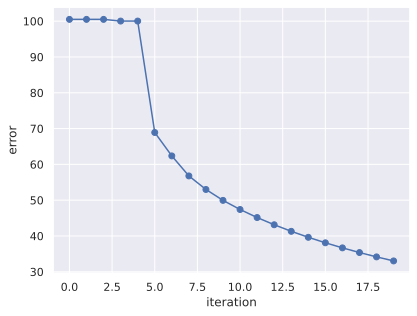

In [300]:
train_big['feature_vector'] = [features2sparse_array(f, big_vocabulary) for f in train_big.features]
test_big['feature_vector'] = [features2sparse_array(f, big_vocabulary) for f in test_big.features]

D = [(fv, 1 if label==1 else -1) for label, fv in train_big[['Sentiment', 'feature_vector']].values]

theta = np.zeros(len(big_vocabulary))
theta = gradient_descent(gradient_logistic, nll, theta, .3, D, .01, 20)

In [301]:
print('results on training data')
train_big['pr_pos_lr'] = [logistic(features2sparse_array(f, big_vocabulary), theta) for f in train_big.features]
train_big['predicted_label_lr'] = [1.0 if v >= .5 else 0.0 for v in train_big.pr_pos_lr]
print(classification_report(train_big.Sentiment, train_big.predicted_label_lr))

print('results on testing data')
test_big['pr_pos_lr'] = [logistic(features2sparse_array(f, big_vocabulary), theta) for f in test_big.features]
test_big['predicted_label_lr'] = [1.0 if v >= .5 else 0.0 for v in test_big.pr_pos_lr]
print(classification_report(test_big.Sentiment, test_big.predicted_label_lr))

results on training data
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        55
           1       0.97      0.99      0.98        90

    accuracy                           0.97       145
   macro avg       0.97      0.97      0.97       145
weighted avg       0.97      0.97      0.97       145

results on testing data
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.83      1.00      0.91        25

    accuracy                           0.86        35
   macro avg       0.92      0.75      0.79        35
weighted avg       0.88      0.86      0.84        35



<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))
<ipython-input-277-0c2f0fa021c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-f(x, theta)))


This looks a lot better!!!

In [302]:
reverse_vocab = {i:v for v,i in big_vocabulary.items()}
for i in np.argsort(theta)[::-1][:15]:
    print(reverse_vocab[i], theta[i])
print()
for i in np.argsort(theta)[:15]:
    print(reverse_vocab[i], theta[i])

learned 0.8506370580625059
course 0.8153020721309169
that 0.7988542995331237
to 0.7787869323771313
and 0.7749530042180957
really 0.7663584487642895
get 0.730677324961906
learning 0.6992828427924568
easy 0.6967641843004484
me 0.6793173810044661
fair 0.6441244110898109
my 0.6307903912542039
best 0.5400054444175355
great 0.5366546537010558
gained 0.5343383738900898

not -0.9468663483910178
yourself -0.8908453268410526
all -0.7756159108679271
so -0.7532928559849864
anything -0.752911374289676
doesn't -0.6881106439515853
teacher -0.6869091901978239
teach -0.675881515551512
no -0.6757748332933714
of -0.6552906008741008
never -0.6449488492389668
more -0.6173872343001278
rude -0.6015346212779321
take-home -0.591665566571559
everything -0.5756086776829237


In [303]:
vec = CountVectorizer(max_df=100, min_df=2, binary=True)
X_train = vec.fit_transform(train_big.Breakdown)
X_test = vec.transform(test_big.Breakdown)

nb.fit(X_train, train_big.Sentiment)
y_pred = nb.predict(X_test)
print(classification_report(test_big.Sentiment, y_pred))

lr = LogisticRegression(C=1e10)
lr.fit(X_train, train_big.Sentiment)
y_pred_lr = lr.predict(X_test)
print(classification_report(test_big.Sentiment, y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      0.30      0.46        10
           1       0.78      1.00      0.88        25

    accuracy                           0.80        35
   macro avg       0.89      0.65      0.67        35
weighted avg       0.84      0.80      0.76        35

              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.85      0.92      0.88        25

    accuracy                           0.83        35
   macro avg       0.80      0.76      0.78        35
weighted avg       0.82      0.83      0.82        35



Ultimately, a larger set of data did improve scores for logisitic regression and Naive Bayes

## Basic Neural Net Trial

For this trial, I decided to try and build a very simple Neural Net for my sentiment classification task.

In [304]:

sentences_from_breakdown = newdata['Breakdown'].values.tolist()
print(sentences_from_breakdown)

temp_vocab = []

stripped_sentences = []

for x in sentences_from_breakdown:

  x = str(x).lower()
  if "an a " in x:
    x = x.replace("an a", "an a+")

  testing_tokens = x.split()
  #testing_tokens2 = [tok.strip('.!,') for tok in testing_tokens if tok not in maddiestop]
  testing_tokens2 = [tok.strip('.!,-\()') for tok in testing_tokens]

  for q in testing_tokens2:
    q = q.strip()

    if '/' in q:
      #print(testing_tokens2)
      one, two = q.split('/')
      temp_vocab.append(one)
      temp_vocab.append(two)
    else:
      if q != '':
        temp_vocab.append(q)

  sent = ' '.join(testing_tokens2)
  if '/' not in sent:
    stripped_sentences.append(sent)
  else:
    newsent = sent.replace('/', ' ')
    print(newsent)
    stripped_sentences.append(newsent)

  #print(testing_tokens)
  #print(testing_tokens2)

print('total number of words in docs is: ', len(temp_vocab))

set_of_temp_vocab = sorted(set(temp_vocab))

print('total unique words is ', len(set_of_temp_vocab))
print(set_of_temp_vocab)
print(stripped_sentences)
print(len(stripped_sentences))

['Take the other biochem professor!!', "The professor doesn't teach you anything, you just draw pictures in class. ", "The tests aren't take-home anymore and were so unreasonable.", "You have to teach yourself everything, but still its hard to prepare for the tests because the professor doesn't give enough resources. ", "Doesn't prepare you well for the future if you are premed.", "It won't be hard to get at least an A- in this class. ", 'However, the professor is extremely lazy, and instead of teaching, they make their students draw pictures. ', 'Exams are take-home but take a full day to complete.', "Overall it's a pretty relaxed class", ' They can be very rude. ', "Premed students should know they won't learn anything for the MCAT.", "Extremely easy to get an A as you get credit for attendance and there's a lot of little assignments.", "lectures aren't great and you really don't learn anything from the class, so take another prof if you're taking this for MCAT review. ", "Otherwise 

In [305]:
# tried to write class to construct vocabulary
# this gave me the same result as above, but with more structure

class MakeVocab():
  def __init__(self, text):
    self.text = text
    self.word_to_id = {}
    self.id_to_word = {}
    self.vocabulary = set()
    self.create_index()

  def create_index(self):
    for sentence in self.text:
      self.vocabulary.update(sentence.split(' '))
    self.vocabulary = sorted(self.vocabulary)

    self.word_to_id['<pad>'] = 0

    for index, word in enumerate(self.vocabulary):
      self.word_to_id[word] = index + 1

    for word, index in self.word_to_id.items():
      self.id_to_word[index] = word

In [306]:
my_nonclean_vocab = MakeVocab(set_of_temp_vocab)

my_nonclean_vocab.vocabulary[0:10]

['', '"adult', '&', '1', '100%', '120', 'a', "a's", 'a+', 'ability']

In [307]:
input_encoding = [[my_nonclean_vocab.word_to_id[s] for s in sent.split(' ') if s != ''] for sent in stripped_sentences]

print(input_encoding[0:2]) #validifying that it worked

[[586, 612, 442, 89, 488], [612, 488, 174, 594, 702, 49, 702, 333, 178, 467, 308, 116]]


In [308]:
#function for finding the longest sentence out of all reviews

def find_max(tensor):
  return max(len(l) for l in tensor)

longest_sent = find_max(input_encoding)
print(longest_sent) #validifying that it worked

42


In [309]:
# knowing that my longest input sequence was 42 words, I was able to
# pad the rest of them

def pad_tensors(tensor, max_length):
  pad = np.zeros((max_length), dtype=np.int64)
  if len(tensor) > max_length:
    pad[:] = tensor[:max_length]
  else:
    pad[:len(tensor)] = tensor
  return pad


print(input_encoding)
padded_encoding = [pad_tensors(x, longest_sent) for x in input_encoding]
padded_tensor = torch.tensor(padded_encoding)

print(padded_encoding[0:2])
print(padded_tensor[0:2])

[[586, 612, 442, 89, 488], [612, 488, 174, 594, 702, 49, 702, 333, 178, 467, 308, 116], [612, 605, 57, 587, 48, 41, 680, 545, 657], [702, 281, 629, 594, 707, 207, 99, 559, 331, 276, 629, 479, 239, 612, 605, 78, 612, 488, 174, 257, 197, 521], [174, 479, 702, 679, 239, 612, 247, 304, 702, 56, 477], [329, 694, 77, 276, 629, 255, 68, 347, 38, 7, 308, 624, 116], [299, 612, 488, 326, 219, 343, 41, 317, 426, 597, 619, 371, 613, 569, 178, 467], [210, 56, 587, 99, 586, 7, 243, 152, 629, 129], [449, 330, 7, 484, 517, 116], [619, 102, 77, 664, 525], [477, 569, 535, 336, 619, 694, 344, 49, 239, 612, 381], [219, 184, 629, 255, 38, 9, 61, 702, 255, 149, 239, 70, 41, 617, 7, 366, 426, 364, 66], [351, 57, 268, 41, 702, 510, 175, 344, 49, 242, 612, 116, 545, 586, 43, 487, 304, 704, 590, 624, 239, 381, 522], [444, 510, 184, 557, 116, 610, 632, 364, 189, 41, 620, 34, 275, 629, 591, 629, 569, 447, 116], [268, 342, 488, 688, 105, 11, 569, 41, 510, 670, 614, 629, 577], [702, 175, 387, 206, 675, 239, 341, 41

In [310]:
# wanted to match the labels to each text sample

labels = newdata['Sentiment'].values.tolist()
print(len(labels))

order_of_text = []
for x in labels:
   if x == 0:
     order_of_text.append([0])
   else:
     order_of_text.append([1])

target_encoding = np.array(order_of_text)
target_tensor = torch.tensor(target_encoding)

print(target_encoding[0:2])
print(target_tensor[0:2])

173
[[0]
 [0]]
tensor([[0],
        [0]])


In [311]:
tensor_tuples = [(x,y) for x,y in zip(padded_tensor, target_tensor)]

#print(encode_tuples)

dataloader = DataLoader(tensor_tuples, batch_size=4, shuffle=True)

# Iterate over the dataloader to fetch batches
for batch_data, batch_labels in dataloader:
    print("Batch data:", batch_data)
    print("Batch labels:", batch_labels)
    break  # Just printing the first batch for demonstration

Batch data: tensor([[449, 330,   7, 484, 517, 116,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [268, 342, 488, 688, 105,  11, 569,  41, 510, 670, 614, 629, 577,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [488, 326, 664, 285,  41,  55,  41, 279,   7, 510, 263, 666,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [510,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])
Batch labels: tensor([[1],
        

now having turned these encodings into tensors, I wanted to split them up for training and testing

In [312]:
testing_size = 30

training_data = tensor_tuples[:-testing_size]
testing_data = tensor_tuples[-testing_size:]

print(testing_data)
print(len(training_data))

[(tensor([155,   7, 144, 610, 702, 248,   7, 366, 446, 426,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]), tensor([1])), (tensor([612, 234, 488, 610, 301, 281, 205, 273, 610, 301, 227, 359, 254, 105,
         11, 382,  41, 405, 578,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]), tensor([1])), (tensor([301, 345, 545, 403, 308,   7, 664, 517,  69,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]), tensor([1])), (tensor([121, 212,  41, 222, 266,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]), tensor([1

In [313]:
class simple_NN(nn.Module):

  def __init__(self, vocab_size, embedding_size, hidden_size, output_size):
    super(simple_NN, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_size)
    #self.linear1 = nn.Linear(embedding_size, hidden_size)
    #self.activation = nn.ReLU()
    self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True)
    self.linear2 = nn.Linear(hidden_size, output_size)
    #self.sig = nn.Sigmoid()

  def forward(self, x):
    #x = x.float()
    x = self.embedding(x)
    #print(x)
    #out = torch.mean(x, dim=1)
    out, hid = self.rnn(x)
    #out = self.activation(out)
    out = self.linear2(hid.squeeze(0))
    #out = self.sig(out)
    return out

now, can I build a very simple model?

In [314]:
vocab_size = len(my_nonclean_vocab.vocabulary) + 1
input_size = longest_sent + 1
hidden_size = 64
embedding_size = 100
output_size = 1
lr = 0.001

model = simple_NN(vocab_size, embedding_size, hidden_size, output_size)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [315]:
num_epochs = 10


for epoch in range(num_epochs):
    model.train()
    loss_total = 0.0
    for text, label in training_data:
        optimizer.zero_grad()
        #text = text.long()
        #label = label.float()
        #print(text)
        #print(label)
        output = model(text)
        output = torch.sigmoid(output)
        #print(output)
        loss = criterion(output, label.float())  # Ensure label is float
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss_total/len(training_data)}")

Epoch 1/10, Loss: 0.7120883762836456
Epoch 2/10, Loss: 0.6765423938110992
Epoch 3/10, Loss: 0.6637252254502757
Epoch 4/10, Loss: 0.6583184641557973
Epoch 5/10, Loss: 0.6509369460644422
Epoch 6/10, Loss: 0.6459118572773633
Epoch 7/10, Loss: 0.6617620985407929
Epoch 8/10, Loss: 0.6601812789490172
Epoch 9/10, Loss: 0.6584512635127647
Epoch 10/10, Loss: 0.6575231924132033


In [316]:
model.eval()
correct = 0
total = 0

true = []
pred = []

with torch.no_grad():
    for text, label in testing_data:
        #text = text.float()
        y_predict = model(text)
        y_predict = torch.sigmoid(y_predict)
        #print(y_predict)
        predicted = (y_predict > 0.5).float()
        loss = criterion(predicted, label.float())
        total += label.size(0)
        correct += (predicted == label).sum().item()
        true.append(label)
        pred.append(predicted)

print(correct)
print(total)

print(classification_report(true, pred))

15
30
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.50      1.00      0.67        15

    accuracy                           0.50        30
   macro avg       0.25      0.50      0.33        30
weighted avg       0.25      0.50      0.33        30



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


currrently I'm getting zero predictions for 0, which is really throwing off accuracy. However, practicing with a NN will help me as I move onto more complicated representations

## trial 3 - moving on to more complex models and word representations

Now I wanted to determine if I could successfully build a more complicated model. I figured the strategies practiced in HW2 could be a good starting point

In [317]:
# now looking at word embedding


w2v = api.load('glove-wiki-gigaword-50')

print('word embeddings for %d words of dimension %d' % (len(w2v.index_to_key), len(w2v['love'])))


word embeddings for 400000 words of dimension 50


In [318]:
#functs i wrote for combining vectors

def average_vectors(words, w2v):
    trial = []

    for i in range(50):
      temp = 0
      for x in words:
        temp += w2v[x][i]
      final = temp / len(words)
      trial.append(final)

    return np.array(trial)

def max_vectors(words, w2v):
    newmax = []

    for i in range(50):
      temp = []
      for x in words:
        temp.append(w2v[x][i])
      final = max(temp)
      newmax.append(final)

    return np.array(newmax)


def min_vectors(words, w2v):
    newmin = []

    for i in range(50):
      temp = []
      for x in words:
        temp.append(w2v[x][i])
      final = min(temp)
      newmin.append(final)
    return np.array(newmin)

def min_max_vectors(words, w2v):
    minmax = []
    themin = min_vectors(words, w2v)
    themax = max_vectors(words, w2v)
    for x in range(len(themin)):
       minmax.append(themin[x])
    for x in range(len(themax)):
       minmax.append(themax[x])

    return np.array(minmax)

I decided to start with the small dataset before moving onto the larger

In [319]:
# make bag-of-words feature matrix for train and test, using default tokenization.
# we remove a few terms that are not in the w2v model
vec_big = CountVectorizer(max_df=100, min_df=2, binary=True)
X_train_big = vec_big.fit_transform(train_big.Breakdown)
X_test_big = vec_big.transform(test_big.Breakdown)
print('training matrix shape', X_train_big.shape, 'testing matrix shape', X_test_big.shape)
y_train_big = train_big.Sentiment
y_test_big = test_big.Sentiment
print('training label distribution', Counter(y_train_big))
print('testing label distribution', Counter(y_test_big))

vocab = np.array(vec_big.get_feature_names_out())
vocab

training matrix shape (145, 244) testing matrix shape (35, 244)
training label distribution Counter({1: 90, 0: 55})
testing label distribution Counter({1: 25, 0: 10})


array(['ability', 'about', 'accommodating', 'after', 'again', 'all',
       'also', 'always', 'amazing', 'an', 'and', 'another', 'answer',
       'answers', 'anything', 'are', 'aren', 'as', 'assignments', 'at',
       'attendance', 'attending', 'based', 'be', 'because', 'before',
       'best', 'biochem', 'biochemistry', 'book', 'boring', 'but', 'by',
       'can', 'cares', 'caring', 'cell', 'class', 'classes', 'classroom',
       'classwork', 'clear', 'comes', 'complete', 'complex', 'concepts',
       'content', 'could', 'course', 'creative', 'credit', 'definitely',
       'did', 'difficult', 'directly', 'do', 'does', 'doesn', 'don',
       'draw', 'drawing', 'dry', 'each', 'easy', 'effectively', 'effort',
       'etc', 'every', 'everything', 'exam', 'exams', 'expectations',
       'extremely', 'fair', 'feel', 'felt', 'for', 'from', 'gained',
       'get', 'gets', 'gives', 'go', 'good', 'grading', 'great', 'had',
       'hard', 'has', 'have', 'help', 'helpful', 'home', 'hours', 'how',

In [320]:
#funct to make word vecs I wrote

def make_word_vector_features(X, vocab, w2v, aggregation_fn):
    """
    a numpy.ndarray with n rows and d columns, where n is the number of documents
    in X and d is the word vector dimension resulting from aggregation_fn
    """

    return np.stack([aggregation_fn([vocab[i] for i in d.indices], w2v) for d in X])

    bigarray = []
    for n in X:
      listlist = []

      for i in n.indices:
        #print(i)
        listlist.append(vocab[i])
      ag = aggregation_fn(listlist, w2v)
      bigarray.append(ag)


X_train_big_avg = make_word_vector_features(X_train_big, vocab, w2v, average_vectors)
X_test_big_avg = make_word_vector_features(X_test_big, vocab, w2v, average_vectors)

X_train_big_avg[0]

array([ 0.03417999,  0.01718447, -0.366251  ,  0.03179   ,  0.29559001,
        0.092997  , -0.291996  , -0.44018999,  0.00737994, -0.06978525,
        0.456705  ,  0.25853501, -0.53577001, -0.31618425,  0.05282037,
        0.17173825, -0.01213751,  0.1391525 , -0.638055  ,  0.07015349,
        0.12464975,  0.239381  , -0.0051466 , -0.0246725 , -0.2575125 ,
       -1.46679749, -0.2705625 , -0.26668473, -0.56127749, -0.44100751,
        1.86212504,  0.11083249, -0.25713574, -0.50283677,  0.00581529,
       -0.26973877, -0.26823499,  0.114815  ,  0.77562525,  0.07881925,
        0.00909351,  0.19858675, -0.01233999,  0.00961725,  0.19254749,
        0.2409    ,  0.29865422,  0.10006999, -0.16681675,  0.09031499])

In [321]:
def test_lr(X_train, y_train, X_test, y_test):
    """
    fit a logistic regression classifier and report
    accuracy on the testing data.
    """
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, train_big.Sentiment)
    y_pred_lr = lr.predict(X_test)
    print(classification_report(test_big.Sentiment, y_pred_lr))
    return lr

# here is the accuracy on the original bag-of-words representation
test_lr(X_train_big, y_train_big, X_test_big, y_test_big)

              precision    recall  f1-score   support

           0       0.80      0.40      0.53        10
           1       0.80      0.96      0.87        25

    accuracy                           0.80        35
   macro avg       0.80      0.68      0.70        35
weighted avg       0.80      0.80      0.78        35



LogisticRegression(max_iter=1000)

In [322]:
# loop over all four aggreagation functions and report acccuracy.
for agg_fn in [average_vectors, min_vectors, max_vectors, min_max_vectors]:
    print(agg_fn.__name__)
    X_train_i = make_word_vector_features(X_train_big, vocab, w2v, agg_fn)
    X_test_i = make_word_vector_features(X_test_big, vocab, w2v, agg_fn)
    test_lr(X_train_i, y_train_big, X_test_i, y_test_big)

average_vectors
              precision    recall  f1-score   support

           0       0.50      0.20      0.29        10
           1       0.74      0.92      0.82        25

    accuracy                           0.71        35
   macro avg       0.62      0.56      0.55        35
weighted avg       0.67      0.71      0.67        35

min_vectors
              precision    recall  f1-score   support

           0       0.50      0.30      0.37        10
           1       0.76      0.88      0.81        25

    accuracy                           0.71        35
   macro avg       0.63      0.59      0.59        35
weighted avg       0.68      0.71      0.69        35

max_vectors
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        10
           1       0.80      0.80      0.80        25

    accuracy                           0.71        35
   macro avg       0.65      0.65      0.65        35
weighted avg       0.71      0.71 

In [323]:
X_train_hw2_avg = make_word_vector_features(X_train_big, vocab, w2v, average_vectors)
X_test_hw2_avg = make_word_vector_features(X_test_big, vocab, w2v, average_vectors)
lr = test_lr(X_train_big_avg, y_train_big, X_test_big_avg, y_test_big)

              precision    recall  f1-score   support

           0       0.50      0.20      0.29        10
           1       0.74      0.92      0.82        25

    accuracy                           0.71        35
   macro avg       0.62      0.56      0.55        35
weighted avg       0.67      0.71      0.67        35



In [324]:
def embed_words(words, w2v):
    return np.vstack([w2v[w] for w in words])

vocab_embedding = embed_words(vocab, w2v)
print(vocab_embedding[0])
vocab_embedding.shape

[ 1.3523e-01 -2.4144e-01  5.8442e-01 -1.5259e-01  5.2884e-01  2.3586e-01
  4.4188e-01  3.6656e-01  8.2703e-01  7.5021e-01  7.7997e-01  8.4343e-01
 -1.1577e-01 -1.2596e-01 -6.4302e-01  5.6060e-01  6.2425e-01 -2.1713e-01
  3.2437e-01 -1.1722e+00 -1.9168e-01  1.8091e-01 -1.1798e-02 -4.6760e-01
  7.9003e-01 -1.5343e+00 -4.1140e-01 -7.7469e-01  5.9486e-01 -2.5341e-01
  3.2951e+00  1.1080e+00 -8.9607e-02 -1.4158e+00  1.2885e-01  4.5275e-01
 -4.7027e-01  1.7661e-01 -5.8128e-01 -6.3758e-01 -6.0980e-02 -1.2510e-01
 -5.2429e-02  4.4401e-01  7.2964e-05 -2.1181e-01  4.4934e-01  3.8505e-01
 -3.5457e-01  2.0372e-01]


(244, 50)

In [325]:
def get_probability_of_positive_class(vocab_embedding, lr):
    save = lr.predict_proba(vocab_embedding)
    return [x[1] for x in save]

get_probability_of_positive_class(vocab_embedding, lr)

[0.9903977119089384,
 0.5356282051998489,
 0.6423729427480541,
 0.33063264525754266,
 0.23759050638526216,
 0.29413668451956976,
 0.4756223745078175,
 0.748079109062403,
 0.9909814579295674,
 0.7396462355672607,
 0.7072730631291035,
 0.5033081781922217,
 0.6059754933618074,
 0.8737943621714248,
 0.4517931240661379,
 0.1261679554685251,
 0.02653933702199465,
 0.35317342851077316,
 0.6899470478429611,
 0.5568205946270418,
 0.23374820594594461,
 0.523857365393198,
 0.956147847450591,
 0.1523718863869827,
 0.25813254494249643,
 0.2327200283631457,
 0.9702479966270383,
 0.4901445557825586,
 0.9747553225353065,
 0.6657101541266858,
 0.2729150847326694,
 0.7133544296706944,
 0.339212403389366,
 0.20302690978282129,
 0.708636465014699,
 0.9768600490020338,
 0.0999980637712594,
 0.09709533786538026,
 0.28209110122681147,
 0.5381872783343093,
 0.7476396829974605,
 0.796655085174744,
 0.8566667600280944,
 0.7494917177176129,
 0.8172388747963203,
 0.9897417103459765,
 0.493632666474606,
 0.4762161

In [326]:
def get_top_words(lr, vocab_embeddings, vocab, topn=10):
    theta = lr.predict_proba(vocab_embedding)[:,1]
    ret = []
    print('positive terms')
    for i in np.argsort(theta)[::-1][:topn]:
        print('%20s\t%.10f' % (vocab[i], theta[i]))
        ret.append(vocab[i])
    print()
    print('negative terms')
    for i in np.argsort(theta)[:topn]:
        print('%20s\t%.10f' % (vocab[i], theta[i]))
        ret.append(vocab[i])
    return ret
top_words = get_top_words(lr, vocab_embedding, vocab, topn=10)

positive terms
            creative	0.9995133835
              skills	0.9994499358
       understanding	0.9994026470
              effort	0.9970173736
              gained	0.9939799840
             science	0.9910825242
           knowledge	0.9909852953
             amazing	0.9909814579
             ability	0.9903977119
             overall	0.9900603167

negative terms
                were	0.0176015445
                 etc	0.0257397759
                aren	0.0265393370
              people	0.0319720935
                  or	0.0393858659
               super	0.0452606764
           literally	0.0480143303
               hours	0.0512564703
           mentioned	0.0582339604
               reads	0.0664186447


these words feel even more accurate! this professor specifically tries to implement accessible policies thaat value creativity and flexibility. it makes sense that 'creative' would rank positively

*now* I want to see if I can try out some sequence models [HMMs and RNNs]

In [327]:
# as written in my HW2

class HMM:
    def __init__(self, states, vocab, smoothing=0):
        self.states = states
        self.vocab = vocab
        self.smoothing = smoothing
        # we'll set these below.
        self.transition_probas = None
        self.emission_probas = None
        self.start_probas = None

In [328]:
def fit_transition_probas(hmm, tags):
    """
    Given an HMM and a dataset, return the transition probabilities between each pair of states.

    Params:
      hmm.....an HMM
      tags....a list of list of strings representing the POS tags for a list of sentences.
    """

    enddict = {}
    numcases = len(tags)
    #if hmm.smoothing != 0:
     # numcases *= hmm.smoothing


    #print(hmm.states)
   # print(hmm.vocab)
    for st in hmm.states:
      enddict[st] = {}
      for next in hmm.states:
        enddict[st][next] = 0.0

    # transitions occuring
    #print(hmm.states)
    for t in tags:
      for index in range(len(t) - 1):
        current = t[index]
        next = t[index + 1]
        if hmm.smoothing == 0:
          enddict[current][next] += (float(1/numcases)) #(float(1+ hmm.smoothing) / numcases)
        else:
          enddict[current][next] += 1.0
    if hmm.smoothing == 0:
      return enddict

    for s in hmm.states:
      total = sum(enddict[s].values()) + (hmm.smoothing * len(hmm.states))
      for next in hmm.states:
         #enddict[s][next] += hmm.smoothing
         #total += hmm.smoothing * len(hmm.states)

         enddict[s][next] = (enddict[s][next] + hmm.smoothing) / total

    #print(enddict)
    return enddict

In [329]:
import nltk
def fit_emission_probas(hmm, sentences, tags):

    #print('sentences: ', sentences)
    #print('tags: ', tags)
    print('vocab: ', hmm.vocab)
    print('states:', hmm.states)
    em_dict = {}
    for st in hmm.states:
      em_dict[st] = {}
      for word in hmm.vocab:
        em_dict[st][word] = 0.0
    #print('em_dict = ')
    #print(em_dict)

    #for val in the range of len of each list of tags in total list
    # [of same len of # of sentences]
    for t in range(len(tags)):
      # list of tags we looking at
      sent_tag = tags[t]
      # the specific sentence we are looking at
      sent_word = sentences[t]
      breakdown = nltk.word_tokenize(sent_word)
      for prop in range(len(sent_tag)):
        state = sent_tag[prop]
        word = breakdown[prop]
        em_dict[state][word] += 1
    #print(em_dict)
    #print(em_dict['VB']['take'])
    #print(em_dict['NN']['professor'])


    for s in hmm.states:
      total = sum(em_dict[s].values()) + (hmm.smoothing * len(hmm.vocab))
      #print(total)
      for word in hmm.vocab:
         em_dict[s][word] = (em_dict[s][word] + hmm.smoothing) / total



    #print(em_dict)

    #print(em_dict['VB']['take'])
    #print(em_dict['NN']['professor'])
    #print(em_dict['NN']['biochem'])
    return em_dict

def fit_start_probas(hmm, tags):
    start_dict = {}
    #print('tags: ', tags)

    for s in hmm.states:
      start_dict[s] = 0.0
    print(start_dict)
    for t in tags:
      start = t[0]
      #print(start)
      start_dict[start] += 1.0

    #print(start_dict)
    # if hmm.smoothing == 0:
    #   return start_dict

    total = sum(start_dict.values()) + hmm.smoothing
    #print(total)
    for s in hmm.states:
      start_dict[s] = (start_dict[s] +hmm.smoothing) / total

    return start_dict


In [330]:
def viterbi(hmm, sentence):

    N = len(hmm.states) #num states
    #print('states i guess: ', N)
    T = len(sentence) #num tokens
    #print('the tokens: ', T)
    prob_matrix = [[0.0]*N for _ in range(T)]
    back = [[None]* N for _ in range(T)]

    #print('prob matrix: ', prob_matrix)
    #print('backward matrix: ', back)

    #base case
    #print(hmm.start_probas)

    for index, state in enumerate(hmm.states):

      #print('first index: ', index)
      #print('first state: ', state)
      #print('first part of eq: ', hmm.start_probas[state])
      #print('sentence 0:', sentence[0])
      #print('second part of eq [first half]: ', hmm.emission_probas[state])
      #print('the whole location :', hmm.emission_probas[state].get(sentence[0]))
      prob_matrix[0][index] = hmm.start_probas[state] * hmm.emission_probas[state].get(sentence[0], 0.0)

    #print('updated prob matrix: ', prob_matrix)
    #recursive case

    for token in range(1, T):
      for index, state in enumerate(hmm.states):
        max_probability = -100
        max_prev_state = None
        for j, previous in enumerate(hmm.states):
          transition_proba = prob_matrix[token-1][j] * hmm.transition_probas[previous].get(state, 0.0)
          if transition_proba > max_probability:
            max_probability = transition_proba
            max_prev_state = previous
        emission_proba = hmm.emission_probas[state].get(sentence[token], 0.0)
        #print(emission_proba)
        prob_matrix[token][index] = max_probability * emission_proba
        back[token][index] = max_prev_state

    max_probability = max(prob_matrix[T-1])
    max_stateind = prob_matrix[T-1].index(max_probability)
    best = [hmm.states[max_stateind]]

    print(prob_matrix)
    #print(best)

    for token in range(T-1, 0, -1):
      max_prev_state = back[token][max_stateind]
      best.insert(0, max_prev_state)
      max_stateind = hmm.states.index(max_prev_state)

    return best, max_probability

In [331]:
# im going to try to do some POS tagging for my sentences
#stripped_sentences

## Accidental Sidequest - POS Tagging

After defining my HMM start and emission probablities, I figured I would need to define the parts of speech for each word! my intention was to label my samples to give more information to my model.

HOWEVER, I accidentally ended up building a model to predict POS tagging

In [332]:
pos_stripped_sentences = []
total_tokens = []
total_tags = []
silly_token = []
silly_tag = []
by_sentence_list = []
tokens_and_labels = []
classific = [x for x in newdata['Sentiment']]
print(classific)
counter = 0

for s in stripped_sentences:
  #print(s)
  by_sentence_list.append([s])
  temp_word = []
  temp_tag = []
  token_doc = nltk.word_tokenize(s) #using nltk library for POS tagging [since my data is not prelabeled]
  tags = nltk.pos_tag(token_doc)
  for tup in tags:
    total_tokens.append(tup[0])
    temp_word.append(tup[0])
    total_tags.append(tup[1])
    temp_tag.append(tup[1])
  silly_token.append(temp_word)
  silly_tag.append(temp_tag)
  tokens_and_labels.append((temp_word, classific[counter]))
  counter += 1


  #print(tags)
  pos_stripped_sentences.append(tags)

print(len(stripped_sentences))
print(silly_token)
print(silly_tag)
print(by_sentence_list)
print(total_tokens)
print(total_tags)
print(tokens_and_labels)


[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
173
[['take', 'the', 'other', 'biochem', 'professor'], ['the', 'professor', 'does', "n't", 'teach', 'you', 'anything', 'you', 'just', 'draw', 'pictures', 'in', 'class'], ['the', 'tests', 'are', "n't", 'take-home', 'anymore', 'and', 'were', 'so', 'unreasonable'], ['you', 'have', 'to', 'teach', 'yourself', 'everything', 'but', 'still', 'its', 'hard', 'to', 'prepare', 'for', 'the', 'tests', 'because', 'the', 'professor', 'does', "n't", 'give', 'enough', 'resources'], ['does', "n

In [333]:
states = set()
for tag_list in silly_tag:
    states.update(tag_list)
states = sorted(list(states))
print('%d unique states' % len(states))

# find the vocabulary
pos_vocab = set(total_tokens)

print('%d unique words' % len(vocab))

31 unique states
244 unique words


In [334]:
train_sentences_split, test_sentences_split = silly_token[:-10], silly_token[-10:]
train_sentences, test_sentences = stripped_sentences[:-10], stripped_sentences[-10:]
print(train_sentences)
train_tags, test_tags = silly_tag[:-10], silly_tag[-10:]
print(train_tags)

hmm = HMM(states=states, vocab=pos_vocab, smoothing=0.001)
#print(hmm)
hmm.start_probas = fit_start_probas(hmm, train_tags)
print('start probabilities: ',hmm.start_probas)
hmm.transition_probas = fit_transition_probas(hmm, train_tags)
#print(hmm.transition_probas)
hmm.emission_probas = fit_emission_probas(hmm, train_sentences, train_tags)
#print(hmm.emission_probas)
sentence = ['if', 'you', 'keep', 'up', 'with', 'readings', 'the', 'tests', 'are', 'mostly', 'straightforward']
print('predicted parts of speech for the sentence %s' % str(sentence))
path, proba = viterbi(hmm, sentence)
print(path, proba)

['take the other biochem professor', "the professor doesn't teach you anything you just draw pictures in class", "the tests aren't take-home anymore and were so unreasonable", "you have to teach yourself everything but still its hard to prepare for the tests because the professor doesn't give enough resources", "doesn't prepare you well for the future if you are premed", "it won't be hard to get at least an a in this class", 'however the professor is extremely lazy and instead of teaching they make their students draw pictures', 'exams are take-home but take a full day to complete', "overall it's a pretty relaxed class", 'they can be very rude', "premed students should know they won't learn anything for the mcat", "extremely easy to get an a+ as you get credit for attendance and there's a lot of little assignments", "lectures aren't great and you really don't learn anything from the class so take another prof if you're taking this for mcat review", "otherwise really easy stem class tha

In [335]:
def evaluate(hmm, sentences, tags):
    truths = []
    preds = []
    for sentence, tag_list in zip(sentences, tags):
        print(sentence)
        print(tag_list)
        path, proba = viterbi(hmm, sentence)
        print('path = ', path)
        print(proba)
        truths.extend(tag_list)
        preds.extend(path)
    print(classification_report(truths, preds, zero_division=0))

evaluate(hmm, test_sentences_split, test_tags)

['all', 'i', 'have', 'to', 'say', 'is', ':', 'dear', 'god']
['DT', 'NNS', 'VBP', 'TO', 'VB', 'VBZ', ':', 'JJ', 'NN']
[[3.608783345609211e-09, 3.608783345609211e-09, 5.5980552590913345e-08, 6.330996514663087e-07, 0.0051203374125132674, 1.6597477349251877e-06, 1.7270067046416225e-07, 4.2585611580162004e-07, 1.658089645279908e-09, 4.835485526947398e-07, 2.387132952348506e-10, 6.246295855988317e-07, 4.538694249803617e-07, 1.658089645279908e-09, 4.814343515214337e-07, 5.407928769497292e-07, 6.467399715259801e-07, 9.156614459008447e-10, 2.2721969213095034e-09, 7.967443750046311e-10, 7.697530348225419e-11, 2.3839000286997546e-07, 1.4367521516476954e-10, 3.8597337514244253e-07, 3.3449586666917855e-07, 5.7497016752911514e-11, 2.9586107395724044e-07, 5.733581016388467e-10, 5.243531356868085e-10, 9.156614459008447e-10, 3.608783345609211e-09], [1.3444403604105383e-11, 1.3444403604105383e-11, 2.085537065916694e-10, 2.3585919188769213e-09, 1.0047580857754122e-10, 6.177158412697068e-12, 2.75791370595

lowkey that kind of worked???? I got an accuracy of 0.68 for predicting sentence parsing POS with an HMM --> now
gonna try my luck with an RNN

In [336]:
# RNN from homework assignment
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, states, verbose=True):
        super(RNN, self).__init__()
        self.states = states
        self.verbose = verbose
        self.n_hidden = hidden_size
        # W_xh
        self.input_to_hidden = nn.Linear(input_size, hidden_size)
        # W_hh
        self.hidden_to_hidden = nn.Linear(hidden_size, hidden_size)
        # W_hy
        self.hidden_to_output = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, h_prev):
        # tanh(𝑊_hh h_t-1 + W_xh x_t)
        h_new = self.tanh(self.hidden_to_hidden(h_prev) + self.input_to_hidden(x))
        # y_h = softmax(W_hy h)
        output = self.softmax(self.hidden_to_output(h_new))

        if self.verbose: print('h_new\n', h_new, '\noutput\n',output, '\ntop output\n', output2label(output, self.states))
        return output, h_new

    def forward_unrolled(self, x_list):
        """
        Given a character list, unroll the network and gather
        predictions for each time step.
        """
        hidden = torch.zeros(1, self.n_hidden)
        outputs = []
        hiddens = []
        for x in x_list:
            output, hidden = self.forward(x, hidden)
            outputs.append(output)
            hiddens.append(hidden)
        return torch.cat(outputs), hidden

def output2label(output, states):
    """
    return the letter for the most probable prediction
    """
    top_n, top_i = output.topk(1)
    return states[top_i.item()] # , math.exp(top_n)


def one_hot(vocab, word):
    x = torch.zeros((1, len(vocab)))
    x[0][vocab.index(word)] = 1.0
    return x

def one_hots(vocab, words):
    return torch.cat([one_hot(vocab, w) for w in words])

torch.random.manual_seed(32)


In [337]:
torch.random.manual_seed(32)
listed_vocab = [x for x in pos_vocab]
rnn = RNN(len(listed_vocab), 2, len(states), states)
outputs, hiddens = rnn.forward_unrolled(one_hots(listed_vocab, ['the', 'biochem', 'professor']))

h_new
 tensor([[ 0.0527, -0.0060]], grad_fn=<TanhBackward0>) 
output
 tensor([[0.0398, 0.0471, 0.0241, 0.0403, 0.0210, 0.0215, 0.0258, 0.0212, 0.0560,
         0.0433, 0.0268, 0.0320, 0.0541, 0.0555, 0.0310, 0.0258, 0.0245, 0.0223,
         0.0391, 0.0303, 0.0237, 0.0204, 0.0191, 0.0169, 0.0251, 0.0246, 0.0184,
         0.0536, 0.0398, 0.0387, 0.0382]], grad_fn=<SoftmaxBackward0>) 
top output
 JJR
h_new
 tensor([[ 0.0536, -0.0695]], grad_fn=<TanhBackward0>) 
output
 tensor([[0.0388, 0.0475, 0.0246, 0.0415, 0.0212, 0.0209, 0.0249, 0.0215, 0.0559,
         0.0419, 0.0269, 0.0320, 0.0564, 0.0537, 0.0302, 0.0255, 0.0248, 0.0233,
         0.0397, 0.0299, 0.0229, 0.0210, 0.0193, 0.0162, 0.0250, 0.0246, 0.0184,
         0.0532, 0.0398, 0.0382, 0.0401]], grad_fn=<SoftmaxBackward0>) 
top output
 NNS
h_new
 tensor([[ 0.0718, -0.0869]], grad_fn=<TanhBackward0>) 
output
 tensor([[0.0383, 0.0475, 0.0250, 0.0421, 0.0214, 0.0210, 0.0248, 0.0217, 0.0553,
         0.0413, 0.0270, 0.0319, 0.0577, 0.0536

In [338]:
#rnn_data_small = [(one_hots(listed_vocab, sentence), one_hots(states, tag_list))
 #                   for sentence, tag_list in zip(train_sentences_split, train_tags)]
#rnn_data_small[0]

rnn_data = [(one_hots(listed_vocab, sentence), one_hots(states, tag_list))
            for sentence, tag_list in zip(silly_token, silly_tag)]
rnn_data_train, rnn_data_test = rnn_data[:-30], rnn_data[-30:]
print('%d training and %d testing sentences' % (len(rnn_data_train), len(rnn_data_test)))

143 training and 30 testing sentences


In [339]:
def train_rnn(rnn, train_data, test_data, epochs=20, learning_rate=0.1):
    torch.random.manual_seed(32)  # for reproducibility
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
    rnn.verbose = False
    loss_val = []
    test_acc = []

    for epoch in tqdm(range(epochs), total=epochs):
        for sentence, tags in train_data:
            optimizer.zero_grad()
            outputs, hiddens = rnn.forward_unrolled(sentence)
            loss = criterion(outputs, tags)
            loss.backward()
            optimizer.step()
            loss_val.append(loss.item())
        # after each epoch, record the test accuracy.
        test_acc.append(evaluate_rnn(rnn, test_data, verbose=False))


    plt.figure()
    plt.plot(loss_val, 'bo-')
    plt.ylabel('loss')
    plt.xlabel('instance')
    plt.title('training')
    plt.show()
    # plot testing F1
    plt.figure()
    plt.plot(test_acc, 'bo-')
    plt.ylabel('f1')
    plt.xlabel('epoch')
    plt.title('testing')
    plt.show()

    return rnn


def evaluate_rnn(rnn, data, verbose=True):
    rnn.verbose = False
    truths = []
    preds = []
    for sentence, tag_list in data:
        outputs, _ = rnn.forward_unrolled(sentence)
        pred = [output2label(output, rnn.states) for output in outputs]
        truth = [output2label(tag, rnn.states) for tag in tag_list]
        truths.extend(truth)
        preds.extend(pred)
    if verbose:
        print(classification_report(truths, preds, zero_division=0))
    return f1_score(truths, preds, average='weighted')



  0%|          | 0/15 [00:00<?, ?it/s]

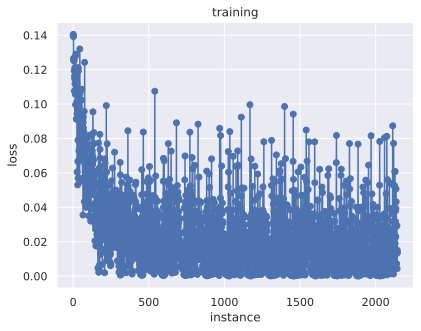

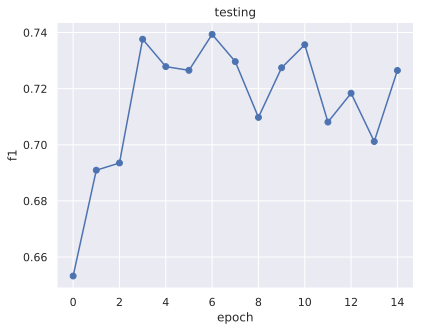

RNN(
  (input_to_hidden): Linear(in_features=700, out_features=5, bias=True)
  (hidden_to_hidden): Linear(in_features=5, out_features=5, bias=True)
  (hidden_to_output): Linear(in_features=5, out_features=31, bias=True)
  (tanh): Tanh()
  (softmax): Softmax(dim=1)
)

In [340]:
big_rnn = RNN(len(listed_vocab), 5, len(states), states)
train_rnn(big_rnn, rnn_data_train, rnn_data_test, epochs=15)

In [341]:
big_rnn.verbose=True
_, _ = big_rnn.forward_unrolled(one_hots(listed_vocab, ['the', 'biochem', 'professor']))

h_new
 tensor([[ 0.9999, -1.0000,  0.9999,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>) 
output
 tensor([[1.1157e-06, 2.6537e-07, 4.4041e-17, 4.6795e-06, 9.9924e-01, 2.0466e-08,
         7.2013e-08, 3.8339e-04, 1.4804e-05, 4.2726e-05, 1.0310e-11, 1.6239e-04,
         7.7038e-06, 3.7085e-06, 2.0173e-16, 2.7988e-15, 2.1564e-10, 7.3556e-08,
         4.4522e-08, 5.8965e-06, 1.6900e-17, 2.1264e-05, 9.0679e-09, 1.3585e-07,
         6.4962e-08, 5.4874e-05, 6.9632e-07, 5.0318e-05, 6.9069e-10, 2.1736e-08,
         2.1464e-06]], grad_fn=<SoftmaxBackward0>) 
top output
 DT
h_new
 tensor([[-0.6473, -1.0000,  1.0000, -1.0000, -0.0607]],
       grad_fn=<TanhBackward0>) 
output
 tensor([[3.7983e-10, 1.1024e-09, 5.2655e-09, 1.0222e-08, 1.4499e-08, 3.1529e-09,
         4.5121e-07, 2.8227e-02, 3.6113e-10, 6.0946e-08, 4.3420e-05, 2.7453e-01,
         6.0511e-01, 7.0665e-06, 5.9236e-05, 2.8972e-11, 8.4554e-02, 9.9540e-07,
         2.4929e-08, 2.2723e-06, 2.8602e-09, 6.0288e-07, 1.4839e-09, 7.3700e-

In [342]:
evaluate_rnn(big_rnn, rnn_data_test)

              precision    recall  f1-score   support

           :       0.00      0.00      0.00         1
          CC       1.00      1.00      1.00        18
          DT       1.00      1.00      1.00        37
          IN       0.98      0.86      0.91        49
          JJ       0.55      0.52      0.54        42
         JJR       0.00      0.00      0.00         1
         JJS       0.00      0.00      0.00         4
          MD       0.43      1.00      0.60         3
          NN       0.92      0.73      0.81        66
         NNS       0.60      0.64      0.62        28
         POS       0.00      0.00      0.00         1
         PRP       1.00      0.88      0.94        26
        PRP$       1.00      0.50      0.67         4
          RB       0.42      0.74      0.54        35
         RBR       0.00      0.00      0.00         3
         RBS       0.00      0.00      0.00         1
          RP       0.00      0.00      0.00         1
          TO       1.00    

0.7264725029249245

not bad

now RNN with text embeddings

In [343]:
MEAN_VEC = w2v.vectors.mean(axis=0)

def embed_words_rnn(w2v, sentence):
    """
    Embed each token with its vector from w2v.
    """
    return torch.tensor([w2v[w.lower()] if w.lower() in w2v else MEAN_VEC for w in sentence])

rnn_data_embed = [(embed_words_rnn(w2v, sentence), one_hots(states, tag_list))
                    for sentence, tag_list in zip(silly_token, silly_tag)]
rnn_data_embed_train, rnn_data_embed_test = rnn_data_embed[:-30], rnn_data_embed[-30:]
print('%d training and %d testing sentences' % (len(rnn_data_embed_train), len(rnn_data_embed_test)))

143 training and 30 testing sentences


  0%|          | 0/30 [00:00<?, ?it/s]

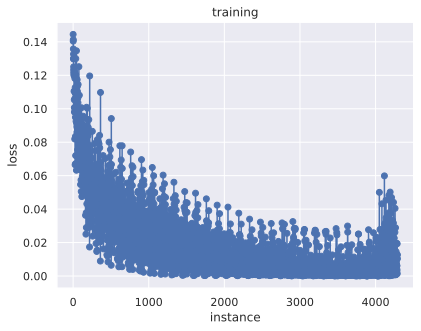

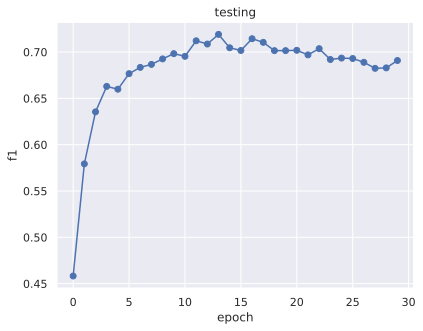

RNN(
  (input_to_hidden): Linear(in_features=50, out_features=40, bias=True)
  (hidden_to_hidden): Linear(in_features=40, out_features=40, bias=True)
  (hidden_to_output): Linear(in_features=40, out_features=31, bias=True)
  (tanh): Tanh()
  (softmax): Softmax(dim=1)
)

In [344]:
embed_rnn = RNN(50, 40, len(states), states)
train_rnn(embed_rnn, rnn_data_embed_train, rnn_data_embed_test, epochs=30, learning_rate=.005)

In [345]:
evaluate_rnn(embed_rnn, rnn_data_embed_test)

              precision    recall  f1-score   support

           :       0.00      0.00      0.00         1
          CC       0.94      0.83      0.88        18
          CD       0.00      0.00      0.00         0
          DT       0.85      0.95      0.90        37
          EX       0.00      0.00      0.00         0
          IN       0.83      0.80      0.81        49
          JJ       0.60      0.36      0.45        42
         JJR       0.00      0.00      0.00         1
         JJS       0.60      0.75      0.67         4
          MD       1.00      1.00      1.00         3
          NN       0.70      0.76      0.73        66
         NNS       0.54      0.68      0.60        28
         POS       0.00      0.00      0.00         1
         PRP       0.88      0.88      0.88        26
        PRP$       1.00      1.00      1.00         4
          RB       0.66      0.77      0.71        35
         RBR       0.50      0.33      0.40         3
         RBS       0.00    

0.6908493592476593

slightly worse accuracy when using word embeddings

## trial 3 pt 2 - back on track with building an RNN

now realizing my previous efforts did not accomplish what I was looking for, I had to reorient

In [346]:
def clean_up_word(val):

    val = re.sub(r"[^\w\s]", '', val)
    val = re.sub(r"\s+", '', val)
    val = re.sub(r"\d", '', val)

    #more for good measure in case i dont understand re
    val = val.strip('.!,-\()')

    return val


def final_tokenizing_funct(x_train,x_test):

    vocab_list = []

    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = clean_up_word(word)
            if word not in stop_words and word != '':
                vocab_list.append(word)

    the_corpus = Counter(vocab_list)
    corpus = sorted(the_corpus,key=the_corpus.get,reverse=True)[:1000]
    onehot_dict = {w:i+1 for i,w in enumerate(corpus)}


    train_sents_clean = []
    test_sents_clean = []
    for sent in x_train:
          train_sents_clean.append([onehot_dict[clean_up_word(word)] for word in sent.lower().split()
                                     if clean_up_word(word) in onehot_dict.keys()])
    for sent in x_test:
            test_sents_clean.append([onehot_dict[clean_up_word(word)] for word in sent.lower().split()
                                    if clean_up_word(word) in onehot_dict.keys()])


    return train_sents_clean, test_sents_clean, onehot_dict


In [347]:
classific = [x for x in newdata['Sentiment']]
unclean_sentences = [x for x in newdata['Breakdown']]

print(unclean_sentences)

# decided to use stratify to ensure even representations
x_train,x_test,y_train,y_test = train_test_split(unclean_sentences ,classific,stratify=classific, random_state=32)


real_train, real_test, real_vocab = final_tokenizing_funct(x_train, x_test)


print(len(real_vocab))


['Take the other biochem professor!!', "The professor doesn't teach you anything, you just draw pictures in class. ", "The tests aren't take-home anymore and were so unreasonable.", "You have to teach yourself everything, but still its hard to prepare for the tests because the professor doesn't give enough resources. ", "Doesn't prepare you well for the future if you are premed.", "It won't be hard to get at least an A- in this class. ", 'However, the professor is extremely lazy, and instead of teaching, they make their students draw pictures. ', 'Exams are take-home but take a full day to complete.', "Overall it's a pretty relaxed class", ' They can be very rude. ', "Premed students should know they won't learn anything for the MCAT.", "Extremely easy to get an A as you get credit for attendance and there's a lot of little assignments.", "lectures aren't great and you really don't learn anything from the class, so take another prof if you're taking this for MCAT review. ", "Otherwise 

In [348]:
def find_max(sentences):
  return max(len(s) for s in sentences)

sents_as_tokens = [[s for s in sent.split(' ') if s != ''] for sent in unclean_sentences]
longest_sent = find_max(sents_as_tokens)
print(longest_sent)

def pad_for_model(sentences, longest_sentence):
    features = np.zeros((len(sentences), longest_sentence),dtype=int)

    for index, review in enumerate(sentences):

        if len(review) != 0:
            features[index, -len(review):] = np.array(review)[:longest_sentence]

    return features

not_used_x = []
not_used_y = []
for sen in real_train[126:]:
  not_used_x.append(sen)
for sen in real_test[42:]:
  not_used_x.append(sen)
for sen in y_train[126:]:
  not_used_y.append(sen)
for sen in y_test[42:]:
  not_used_y.append(sen)

x_train_pad = pad_for_model(real_train, longest_sent)
print(len(x_train_pad))
x_test_pad = pad_for_model(real_test, longest_sent)

x_train_pad = np.array(x_train_pad)
x_test_pad = np.array(x_test_pad)
y_train_pad = np.array(y_train)
y_test_pad = np.array(y_test)

#shortening these so I can send them through the model in equal chunks

x_train_pad = x_train_pad[:126]
print(len(x_train_pad))

x_testtt = x_test_pad[:42]

x_test_pad = x_testtt[21:]
x_valid_pad = x_testtt[:21]
print(len(x_test_pad))

y_train_pad = y_train_pad[:126]

y_testtt = y_test_pad[:42]
y_test_pad = y_testtt[21:]
y_valid_pad = y_testtt[:21]

print(len(y_valid_pad))


42
129
126
21
21


^ I decided to split the training and testing samples to ensure I can batch samples properly

In [349]:
training_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train_pad))
validation_data = TensorDataset(torch.from_numpy(x_valid_pad), torch.from_numpy(y_valid_pad))

batch_size = 3

training_loader = DataLoader(training_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(validation_data, shuffle=True, batch_size=batch_size)

In [350]:
it = iter(training_loader)
sample_x, sample_y = next(it)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([3, 42])
Sample input: 
 tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,  45,  30,   6,  16, 225, 226,  46],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,  97, 108,  27, 218,   1, 219, 220,   2,   7, 109,  28,  29],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0, 276, 132, 277, 133, 278,  19, 279]])
Sample input: 
 tensor([1, 1, 1])


Now that I have the data converted, I will pass it to an RNN

In [351]:
class SentimentReviewRNN(nn.Module):
    #def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
    def __init__(self, num_layers, vocab_size, hidden_size, embedding_size, drop_prob=0.5):
        super(SentimentReviewRNN,self).__init__()

        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, embedding_size)

        self.lstm = nn.LSTM(input_size=embedding_size,hidden_size=self.hidden_size,
                           num_layers=num_layers, batch_first=True)

        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_size, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        # x = the batch of input sequences
        batch_size = x.size(0)

        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_size)
        out = self.dropout(lstm_out)
        out = self.fc(out)

        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1]
        return sig_out, hidden

    def init_hidden(self, batch_size):

        h0 = torch.zeros((self.num_layers,batch_size,self.hidden_size))
        c0 = torch.zeros((self.num_layers,batch_size,self.hidden_size))
        hidden = (h0,c0)
        return hidden


In [352]:
num_layers = 2
vocab_size = len(real_vocab) + 1
embedding_size = 64
output_size = 2
hidden_size = 256


model = SentimentReviewRNN(num_layers, vocab_size, hidden_size, embedding_size, drop_prob=0.5)


print(model)

SentimentReviewRNN(
  (embedding): Embedding(527, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (sig): Sigmoid()
)


In [353]:
lr=0.001 #yuh learning rate

criterion = nn.BCELoss() #choice of loss function

optimizer = torch.optim.Adam(model.parameters(), lr=lr)


def acc(pred,label):
    pred = torch.round(pred.squeeze()) #rounds to zero or one
    return torch.sum(pred == label.squeeze()).item()

In [354]:
testing_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test_pad))
print(len(testing_data))
testing_loader = DataLoader(testing_data, shuffle=True, batch_size=batch_size)
print(len(testing_loader))

def test_sentReviewRNN(model, data_loader):
  testing_loss = 0.0
  num_correct = 0
  total = 0

  predictions = []
  true_labels = []

  model.eval()


  with torch.no_grad():
    for inputs, labels in data_loader:

      batch_size = labels.size(0)

      test_h = model.init_hidden(batch_size)
      test_h = tuple([each.data for each in test_h])

      output, test_h = model(inputs, test_h)
     # loss = loss_funct(output.squeeze(), labels.float())
      #testing_loss += loss.item()

      prediction = torch.round(output)
      print(prediction)

      num_correct += (prediction == labels).sum().item()
      total += labels.size(0)

      predictions.extend(prediction.numpy())
      true_labels.extend(labels.numpy())


  #testing_loss = testing_loss / len(data_loader)
  accuracy = num_correct / total
  predictions = [int(x) for x in predictions]
  print(predictions)
  print(true_labels)


  return predictions, true_labels,accuracy


21
7


In [355]:
def train_sentRNN(param_grid, model_type, training_load, valid_load):
  clip = 5 #attempt to avoid exploding gradient
  #epochs = 10
  valid_loss_min = np.Inf

  epoch_train_loss = []
  epoch_valid_loss = []
  epoch_train_acc = []
  epoch_valid_acc = []

  best_params = None
  best_accuracy = 0.0
  param_combinations = list(itertools.product(*param_grid.values()))

  for p in param_combinations:
    model = model_type
    optimizer = torch.optim.Adam(model.parameters(), lr=p[0])
    for epoch in range(p[1]):
        train_losses = []
        train_acc = 0.0
        model.train()

        h = model.init_hidden(batch_size)
        for inputs, labels in training_loader:
            h = tuple([each.data for each in h])

            model.zero_grad()
            output, h = model(inputs, h)

            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            train_losses.append(loss.item())
            accuracy = acc(output, labels)
            train_acc += accuracy

            #`clip_grad_norm` - prevent the exploding gradient problem
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()


            val_h = model.init_hidden(batch_size)


        val_losses = []
        val_acc = 0.0
        model.eval()
        for inputs, labels in valid_loader:
                val_h = tuple([each.data for each in val_h])


                output, val_h = model(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

                accuracy = acc(output,labels)
                val_acc += accuracy

        epoch_tr_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_tr_acc = train_acc/len(training_loader.dataset)
        epoch_val_acc = val_acc/len(valid_loader.dataset)
        #epoch_train_loss.append(epoch_tr_loss)
        #epoch_valid_loss.append(epoch_val_loss)
        epoch_train_acc.append(epoch_tr_acc)
        epoch_valid_acc.append(epoch_val_acc)


    pred, true, test_acc = test_sentReviewRNN(model, testing_loader)
    if test_acc > best_accuracy:
      best_accuracy = test_acc
      best_params = p


  return best_params, best_accuracy



params_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'num_epochs': [5, 10, 15]
}

modelhold = SentimentReviewRNN(num_layers, vocab_size, hidden_size, embedding_size, drop_prob=0.5)

print(train_sentRNN(params_grid, modelhold, training_loader, valid_loader))

tensor([0., 0., 0.])
tensor([0., 1., 0.])
tensor([0., 0., 0.])
tensor([0., 0., 0.])
tensor([1., 0., 1.])
tensor([0., 0., 1.])
tensor([0., 0., 0.])
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0]
[1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]
tensor([0., 1., 0.])
tensor([1., 0., 1.])
tensor([0., 0., 1.])
tensor([0., 1., 0.])
tensor([1., 1., 1.])
tensor([1., 1., 0.])
tensor([0., 0., 0.])
[0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0]
[0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]
tensor([1., 1., 0.])
tensor([0., 0., 1.])
tensor([1., 0., 1.])
tensor([1., 1., 1.])
tensor([1., 1., 0.])
tensor([0., 0., 0.])
tensor([1., 1., 1.])
[1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1]
[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1]
tensor([0., 1., 1.])
tensor([1., 1., 1.])
tensor([1., 1., 1.])
tensor([1., 0., 1.])
tensor([1., 1., 0.])
tensor([1., 1., 1.])
tensor([1., 1., 0.])
[0, 1, 1, 1, 1, 1, 1, 1, 1, 

After doing a gridsearch, I was able to achieve an accuracy of 0.7143 on the testing data!! this was achieved with a learning rate of 0.001 and 15 epochs. Now I'm hoping to get an even better result [now that I've narrowed down what seems to work]

In [356]:
params_grid = {
    'learning_rate': [0.0001, 0.001, 0.005, 0.008],
    'num_epochs': [12, 15, 20, 25, 30]
}

#commenting out bc it takes forever to run

#model_2 = SentimentReviewRNN(num_layers, vocab_size, hidden_size, embedding_size, drop_prob=0.5)

#print(train_sentRNN(params_grid, model_2, training_loader, valid_loader))

with my new hyperparameter grid, my cell block took over 20 minutes to run. Although I ended up discovering that a learning rate of 0.008 and 20 epochs was better, I still ended up with nearly the same accuracy!! clearly that was not worth it

In [357]:
'''
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_train_acc, label='Train Acc')
plt.plot(epoch_valid_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_train_loss, label='Train loss')
plt.plot(epoch_valid_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()
'''

'\nfig = plt.figure(figsize = (20, 6))\nplt.subplot(1, 2, 1)\nplt.plot(epoch_train_acc, label=\'Train Acc\')\nplt.plot(epoch_valid_acc, label=\'Validation Acc\')\nplt.title("Accuracy")\nplt.legend()\nplt.grid()\n\nplt.subplot(1, 2, 2)\nplt.plot(epoch_train_loss, label=\'Train loss\')\nplt.plot(epoch_valid_loss, label=\'Validation loss\')\nplt.title("Loss")\nplt.legend()\nplt.grid()\n\nplt.show()\n'

I figured it might be fun to see if I could predict the sentiment of individual sentences too [rather than just looking at the large scale metrics]

In [358]:
def predict_text(text):
        word_order = np.array([real_vocab[clean_up_word(word)] for word in text.split()
                         if clean_up_word(word) in real_vocab.keys()])
        word_order = np.expand_dims(word_order,axis=0)
        pad =  torch.from_numpy(pad_for_model(word_order,longest_sent))
        inputs = pad
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [359]:
print(not_used_x)
print(real_vocab)
print(not_used_y)


keys = list(real_vocab.keys())
values = list(real_vocab.values())

not_used_sents_x = []
for tens in not_used_x:
  temp = ''
  for num in tens:
    word = keys[num-1]
    temp += word + ' '
  not_used_sents_x.append(temp)

print(not_used_sents_x)

[[2, 522, 12, 523, 1, 13, 68, 159], [25, 524, 50, 10], [1, 525, 156, 8, 154, 168, 526], [152, 63, 2, 1, 165, 166], [469, 129, 155, 8]]
{'professor': 1, 'class': 2, 'tests': 3, 'material': 4, 'students': 5, 'learned': 6, 'really': 7, 'lectures': 8, 'science': 9, 'course': 10, 'know': 11, 'hard': 12, 'makes': 13, 'great': 14, 'get': 15, 'lot': 16, 'one': 17, 'stem': 18, 'learning': 19, 'understand': 20, 'lab': 21, 'way': 22, 'easy': 23, 'little': 24, 'gained': 25, 'creative': 26, 'biochem': 27, 'well': 28, 'mcat': 29, 'like': 30, 'gives': 31, 'fair': 32, 'lecture': 33, 'make': 34, 'dont': 35, 'work': 36, 'learn': 37, 'tulane': 38, 'study': 39, 'always': 40, 'complex': 41, 'take': 42, 'interesting': 43, 'ability': 44, 'feel': 45, 'biochemistry': 46, 'extremely': 47, 'never': 48, 'questions': 49, 'knowledge': 50, 'succeed': 51, 'cares': 52, 'super': 53, 'concepts': 54, 'assignments': 55, 'also': 56, 'put': 57, 'based': 58, 'understanding': 59, 'open': 60, 'book': 61, 'effort': 62, 'outside

In [360]:
testing_predictions, true_labels, testing_acc = test_sentReviewRNN(model, testing_loader)
print(f"Accuracy: {testing_acc:.4f}")

testing_predictions = np.array(testing_predictions)
true_labels = np.array(true_labels)

print(classification_report(true_labels, testing_predictions))
print('accuracy = ', testing_acc)

tensor([1., 1., 1.])
tensor([1., 1., 1.])
tensor([1., 1., 1.])
tensor([1., 1., 1.])
tensor([1., 1., 1.])
tensor([1., 1., 1.])
tensor([1., 1., 1.])
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0]
Accuracy: 0.7143
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.71      1.00      0.83        15

    accuracy                           0.71        21
   macro avg       0.36      0.50      0.42        21
weighted avg       0.51      0.71      0.60        21

accuracy =  0.7142857142857143


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


okay, this breakdown had WAY too many positive responses - it looks like my model didn't do a great job assessing negative reviews

In [361]:

index = 3
#print(newdata['Breakdown'][index])
print(not_used_sents_x[index])
print('='*70)
#print(f'Actual sentiment is  : {newdata["Sentiment"][index]}')
print(f'Actual sentiment is  : {not_used_y[index]}')
print('='*70)
pro = predict_text(not_used_sents_x[index])
print(pro)
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')


difficult outside class professor office hours 
Actual sentiment is  : 0
0.5043167471885681
Predicted sentiment is positive with a probability of 0.5043167471885681


## Extras

I had a number of other ideas and things I was hoping to get to. However, due to time constraints, this was not fully possible. Below are some more things I was looking at implementing

### GloVe embeddings --> RNN

In [362]:
glove = torchtext.vocab.GloVe(name="6B", dim=50)
print(glove)

In [363]:
def get_review_words(vector):
  newtensors = []
  for review, sentiment in tokens_and_labels:
    ids = [vector.stoi[word] for word in review if word in vector.stoi]
    if not ids:
      continue
    ids = torch.tensor(ids)
    label = torch.tensor(int(sentiment)).long()
    #print('label tensor =', label)
    newtensors.append((ids, label))
  return newtensors

tensor_glove = get_review_words(glove)
print(tensor_glove)

[(tensor([   190,      0,     68, 101842,   1282]), tensor(0)), (tensor([   0, 1282,  260,   70, 5293,   81, 1096,   81,  120, 1707, 2490,    6,
         905]), tensor(0)), (tensor([     0,   1798,     32,     70, 249669,   5717,      5,     35,    100,
         16530]), tensor(0)), (tensor([  81,   33,    4, 5293, 4961, 1174,   34,  149,   47,  605,    4, 3298,
          10,    0, 1798,  113,    0, 1282,  260,   70,  455,  575, 1540]), tensor(0)), (tensor([   260,     70,   3298,     81,    143,     10,      0,    581,     83,
            81,     32, 179094]), tensor(0)), (tensor([  20, 1369,   70,   30,  605,    4,  169,   22,  338,   29,    7,    6,
          37,  905]), tensor(1)), (tensor([  212,     0,  1282,    14,  2708, 16531,     5,   773,     3,  3174,
           39,   159,    44,   543,  1707,  2490]), tensor(0)), (tensor([ 11810,     32, 249669,     34,    190,      7,    549,    122,      4,
          1336]), tensor(0)), (tensor([1250,   20,    9,    7, 1922, 8213,  905])

In [364]:
for i in range(10):
  val, label = tensor_glove[i]
  print(val.shape)

torch.Size([5])
torch.Size([13])
torch.Size([10])
torch.Size([23])
torch.Size([12])
torch.Size([14])
torch.Size([16])
torch.Size([10])
torch.Size([7])
torch.Size([5])


In [365]:
glove_embedding = nn.Embedding.from_pretrained(glove.vectors)


In [366]:
base_sent, base_label = tensor_glove[0]
print(base_sent)
print(base_label)

tensor([   190,      0,     68, 101842,   1282])
tensor(0)


In [367]:
review_embed = glove_embedding(base_sent)
review_embed.shape

torch.Size([5, 50])

In [368]:
rnn_modeling = nn.RNN(input_size=50, hidden_size=50, batch_first=True)

In [369]:
#try to get dimension
review_ = review_embed.unsqueeze(0)
review_.shape

torch.Size([1, 5, 50])

In [370]:
h0 = torch.zeros(1, 1, 50)
outtest, last_hidden = rnn_modeling(review_, h0)
print(outtest.shape)
print(last_hidden.shape)

torch.Size([1, 5, 50])
torch.Size([1, 1, 50])


In [371]:
class reviewSentimentRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, verbose=True):
        super(reviewSentimentRNN, self).__init__()
        self.verbose = verbose
        self.n_hidden = hidden_size
        #using glove embeddings
        self.embed = nn.Embedding.from_pretrained(glove.vectors)
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.hidden_to_output = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        h_new = self.embed(x)
        output, _ = self.rnn(h_new)

        output = self.hidden_to_output(output[:, -1, :])


        return output

In [372]:
padded_review = pad_sequence([x for x, label in tensor_glove], batch_first=True)

padded_review.shape
print(padded_review)


tensor([[  190,     0,    68,  ...,     0,     0,     0],
        [    0,  1282,   260,  ...,     0,     0,     0],
        [    0,  1798,    32,  ...,     0,     0,     0],
        ...,
        [   43,   580,    13,  ...,     0,     0,     0],
        [43230, 32035,   905,  ...,     0,     0,     0],
        [ 1798,    35,  1786,  ...,     0,     0,     0]])


In [373]:
rnn_sent_model = reviewSentimentRNN(50, 50, 2)

In [374]:
test_review, test_label = tensor_glove[0]
test_review = test_review.unsqueeze(0)
rnn_sent_model(test_review)

tensor([[0.1207, 0.0826]], grad_fn=<AddmmBackward0>)

Based on the output, [I think] the first sentence was predicted to have a label of 1 because this value was higher.

Ultimately, I wasn't able to scale this very far and decided to take a different route

In [375]:
# then I tried to actually load this data and do a test/train/split

sents_glove = []
labels_glove = []

for sent, label in tensor_glove:
  #sents_glove.append(sent)
  labels_glove.append(label)
for sent in padded_review:
  sents_glove.append(sent)

print(len(sents_glove))
print(labels_glove)

173
[tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(0), tensor(0), tensor(1), tensor(0), tensor(0), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(0), tensor(1), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(0), tensor(0), tensor(0), tensor(1), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tenso

In [376]:
glov_trainX, glov_testX = sents_glove[:-30], sents_glove[-30:]
yglov_train, yglov_test = labels_glove[:-30], labels_glove[-30:]

val_glovX, test_glovX = glov_testX[:-15], glov_testX[-15:]
val_glovy , test_glovy = yglov_test[:-15], yglov_test[-15:]

print(len(test_glovX))
print(len(yglov_train))

15
143


In [377]:
#built an LStm layer to input for my model

lstm_layer = nn.LSTM(input_size=50, hidden_size=50, batch_first=True)

lstm_review0 = glove_embedding(padded_review[0])
lstm_review0.shape


torch.Size([42, 50])

In [378]:
my_input = lstm_review0.unsqueeze(0)
h0 = torch.zeros(1, 1, 50)
c0 = torch.zeros(1, 1, 50)

outtt, lasttt_hidden = lstm_layer(my_input, (h0, c0))
outtt.shape

torch.Size([1, 42, 50])

In [379]:
class reviewSentimentLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, verbose=True):
        super(reviewSentimentLSTM, self).__init__()
        self.verbose = verbose
        self.n_hidden = hidden_size
        #using glove embeddings
        self.embed = nn.Embedding.from_pretrained(glove.vectors)
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.hidden_to_output = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

        #self.input_to_hidden = nn.Linear(input_size, hidden_size)
        #self.hidden_to_hidden = nn.Linear(hidden_size, hidden_size)
        #self.tanh = nn.Tanh()


    def forward(self, x):
        x = self.embed(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        output, _ = self.rnn(x, (h0, c0))

        output = self.hidden_to_output(output[:, -1, :])


        return output

In [380]:
def get_data_for_model(rev, lab):
  data = []
  for x in range(len(rev)):
    data.append((glove_embedding(rev[x]), lab[x]))
  return data


def get_accuracy(model, data):
    correct, total = 0, 0
    for review, labels in data:
        output = model(review)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

#lstm_review0 = glove_embedding(padded_review[0])

def train_model(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        print('epoch: ', epoch)
        for review, labels in train:
            print(review.shape)
            print(labels)
            #review = review.unsqueeze(0)
            optimizer.zero_grad()
            pred = model(review)
            print('we predicted')
            loss = criterion(pred, labels)
            print('we lost')
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [381]:
modeling_lstm = reviewSentimentLSTM(50, 50, 2)


In [382]:
lstm_train_data = get_data_for_model(glov_trainX, yglov_train)
lstm_valid_data = get_data_for_model(val_glovX, val_glovy)

print(lstm_train_data[0])
lstm_train_data = [(torch.tensor(review, dtype=torch.long), labels) for review, labels in lstm_train_data]
#print(lstm_train_data[0])
#lstm_train_data = [(torch.unsqueeze(review, 0), labels) for review, labels in lstm_train_data]
#print(lstm_train_data[0])
lstm_valid_data = [(torch.tensor(review, dtype=torch.long), labels) for review, labels in lstm_valid_data]
lstm_valid_data = [(torch.unsqueeze(review, 0), labels) for review, labels in lstm_valid_data]

print(len(lstm_train_data))
train_model(modeling_lstm, lstm_train_data, lstm_valid_data, num_epochs=20, learning_rate=1e-4)

(tensor([[ 0.6226,  0.0719,  0.0243,  ...,  0.1811,  0.0390,  0.2385],
        [ 0.4180,  0.2497, -0.4124,  ..., -0.1841, -0.1151, -0.7858],
        [ 0.6476,  0.1600,  0.0292,  ...,  0.1032, -0.3096, -0.4421],
        ...,
        [ 0.4180,  0.2497, -0.4124,  ..., -0.1841, -0.1151, -0.7858],
        [ 0.4180,  0.2497, -0.4124,  ..., -0.1841, -0.1151, -0.7858],
        [ 0.4180,  0.2497, -0.4124,  ..., -0.1841, -0.1151, -0.7858]]), tensor(0))
143
epoch:  0
torch.Size([42, 50])
tensor(0)


<ipython-input-382-6a36b8b25afc>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lstm_train_data = [(torch.tensor(review, dtype=torch.long), labels) for review, labels in lstm_train_data]
<ipython-input-382-6a36b8b25afc>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lstm_valid_data = [(torch.tensor(review, dtype=torch.long), labels) for review, labels in lstm_valid_data]


IndexError: index out of range in self

Ultimately I kept getting this really annoying "index out of range" error, which I spent hours trying to modify. This inspired me to go a different route for the project [but I still wanted to include it]